# Final Project : Traffic flow short-term prediction

## Introduction

### Description of the project

Trafikverket (TRV) is looking to using clustering and AI for short-term prediction application. The TRV selected a test bottleneck in Stockholm (MCS data) as "Proof of Concept" (POC) consisting of interchange between the Pampas exit and the Hornsberg exit, see Figure below. 

The starting point for the short-term prediction is data from MCS/TDIS for the current situation, which are used to calculate the current situation and the predicted situation in 15 minutes, 30 minutes, and 60 minutes. The premise is to use clustering or AI with historical data updating prediction every minute. 

Short-term prediction is essential for data-driven Traffic Management and evolving from re-active to pro-active traffic management. Trafik Stockholm and TRV are investing in understanding better highway traffic and how incidents and planned work impact mobility in affected urban areas using data-driven and AI approaches. To the best of our knowledge, this is the first dataset benchmark prepared and decided by TRV that should enable cross-model, industry and research comparison for short-term prediction applications. 

In this project, I will be working on building machine learning models that predict in real-time (each minute) the flow or average speed for the future 15 minutes. The model wil be trained and validated for the morning peak period 07:30 – 08:30. Thus at 7:00, predict flow for 7:01-7:16, at 7:02, predict flow for 7:02-7:17.

### Description for the highway traffic dataset

The dataset contains historical 1 -minute traffic observations (flow and speed) on the Motorway Control Sy stem (MCS)
microwave sensors around Stockholm City. Particularly for this case study (see Figure 1), 8 portals in the south traffic
flow direction are selected (selected portals in their downstream order E4S 58.140, E4S 57.820, E4S 57.435,
E4S 57.055, E4S 56.780, E4S 56.490, E4S 56.160, E4S 55.620). Each portal consists of several sensors per line.
The chosen path is part of the busiest route in Sweden, the E4 -Essigne-bypass of Stockholm City . The dataset covers
the morning peak (04:00 – 10:00) from 2021-06-01 – 2021-12-31. While 2022-01-01 – 2022-06-30 should be used
for evaluating the model performance.

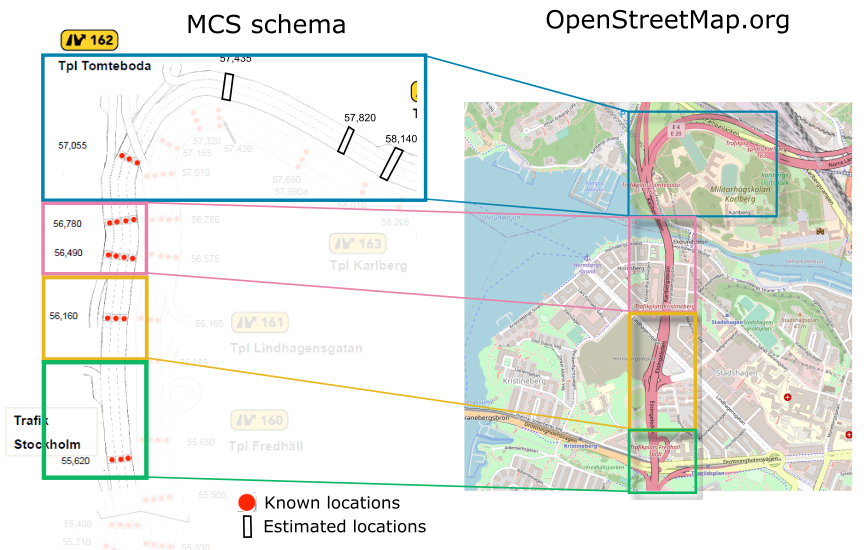

Figure 1 Shows the location of sensor portals in both schema (left) and real -world space (right)

There are two datasets provided, first for training and second for evaluation. Note that the evaluation dataset should
not be a part of the training. Training dataset can be split into training and testing datasets according to y our design.
Please also note that y ou do not have to use a complete training dataset, and y ou can choose a sub -set. Anyway, at the
end, y ou should provide a prediction performance of y our final selected model using a complete evaluation dataset.
This dataset shows how y our model performs in the application.



|Variable    |Data Type    |Description                                              |
|------------|--------|---------------------------------------------------------|
|DP_ID       |Int       |ID of sensor at a portal location                   |
|PORTAL      |Str       |ID of portal                              |
|Date        |Int     |Date format YYYYmmdd                                            |
|Time        |Time.   |Time format HH:MM:SS                                 |
|Interval_1  |Int   |1‑minute bin index (0: 00:00–00:00:59, 1: 00:01–00:01:59)|
|Interval_5  |Int   |5‑minute bin index (0: 00:00–00:04:59, 1: 00:05–00:09:59)|
|Interval_15 |Int   |15‑minute bin index(0: 00:00–00:14:59, 1: 00:15–00:29:59)|
|Interval_30 |Int   |30‑minute bin index(0: 00:00–00:29:59, 1: 00:30–00:59:59)|
|Interval_60 |Int   |60‑minute bin index(0: 00:00–00:59:59, 1: 01:00–00:01:59)|
|SPEED_MS_AVG|Float     |Average speed over the minute (m/s)                         |
|FLOW        |Float |Count of vehicles in the minute  (veh/min)                         |

The dataset is extracted from the dataset provided by Trafikverket.

## A. Descriptive Analysis

In [1]:
import pandas as pd

/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_train = pd.read_csv('training_dataset.csv', sep=';')
print("Shape of the DataFrame:", df_train.shape)
df_train.head()

Shape of the DataFrame: (1921967, 11)


,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0


In [3]:
print("Missing values:")
print(df_train.isnull().sum())

Missing values:
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            62
dtype: int64


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### 1. Basic Descriptive Statistics

In [5]:
# Basic descriptive statistics for flow and speed
print("=== DESCRIPTIVE STATISTICS ===")
print("\nFlow Statistics:")
print(df_train['FLOW'].describe())
print(f"\nFlow - Missing values: {df_train['FLOW'].isnull().sum()}")
print(f"Flow - Zero values: {(df_train['FLOW'] == 0).sum()}")

print("\nSpeed Statistics:")
print(df_train['SPEED_MS_AVG'].describe())
print(f"\nSpeed - Missing values: {df_train['SPEED_MS_AVG'].isnull().sum()}")
print(f"Speed - Zero values: {(df_train['SPEED_MS_AVG'] == 0).sum()}")

=== DESCRIPTIVE STATISTICS ===

Flow Statistics:
count    1.921905e+06
mean     1.236552e+01
std      8.023255e+00
min      1.000000e+00
25%      5.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      4.500000e+01
Name: FLOW, dtype: float64

Flow - Missing values: 62
Flow - Zero values: 0

Speed Statistics:
count    1.921967e+06
mean     2.002764e+01
std      3.027135e+00
min      0.000000e+00
25%      1.809000e+01
50%      1.985000e+01
75%      2.194000e+01
max      4.583000e+01
Name: SPEED_MS_AVG, dtype: float64

Speed - Missing values: 0
Speed - Zero values: 2


### 2. Time-based Analysis

In [6]:
# Convert Date and Time to datetime format for time series analysis
df_train['DateTime'] = pd.to_datetime(df_train['Date'].astype(str) + ' ' + df_train['Time'])
df_train['Hour'] = df_train['DateTime'].dt.hour
df_train['DayOfWeek'] = df_train['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df_train['Month'] = df_train['DateTime'].dt.month

print("=== TIME-BASED ANALYSIS ===")
print(f"Total records: {len(df_train):,}")
print(f"Date range: {df_train['DateTime'].min()} to {df_train['DateTime'].max()}")
print(f"Number of days: {df_train['DateTime'].dt.date.nunique()}")
print(f"Hours covered: {sorted(df_train['Hour'].unique())}")

=== TIME-BASED ANALYSIS ===
Total records: 1,921,967
Date range: 2021-06-01 04:00:00 to 2021-12-31 10:00:00
Number of days: 214
Hours covered: [4, 5, 6, 7, 8, 9, 10]


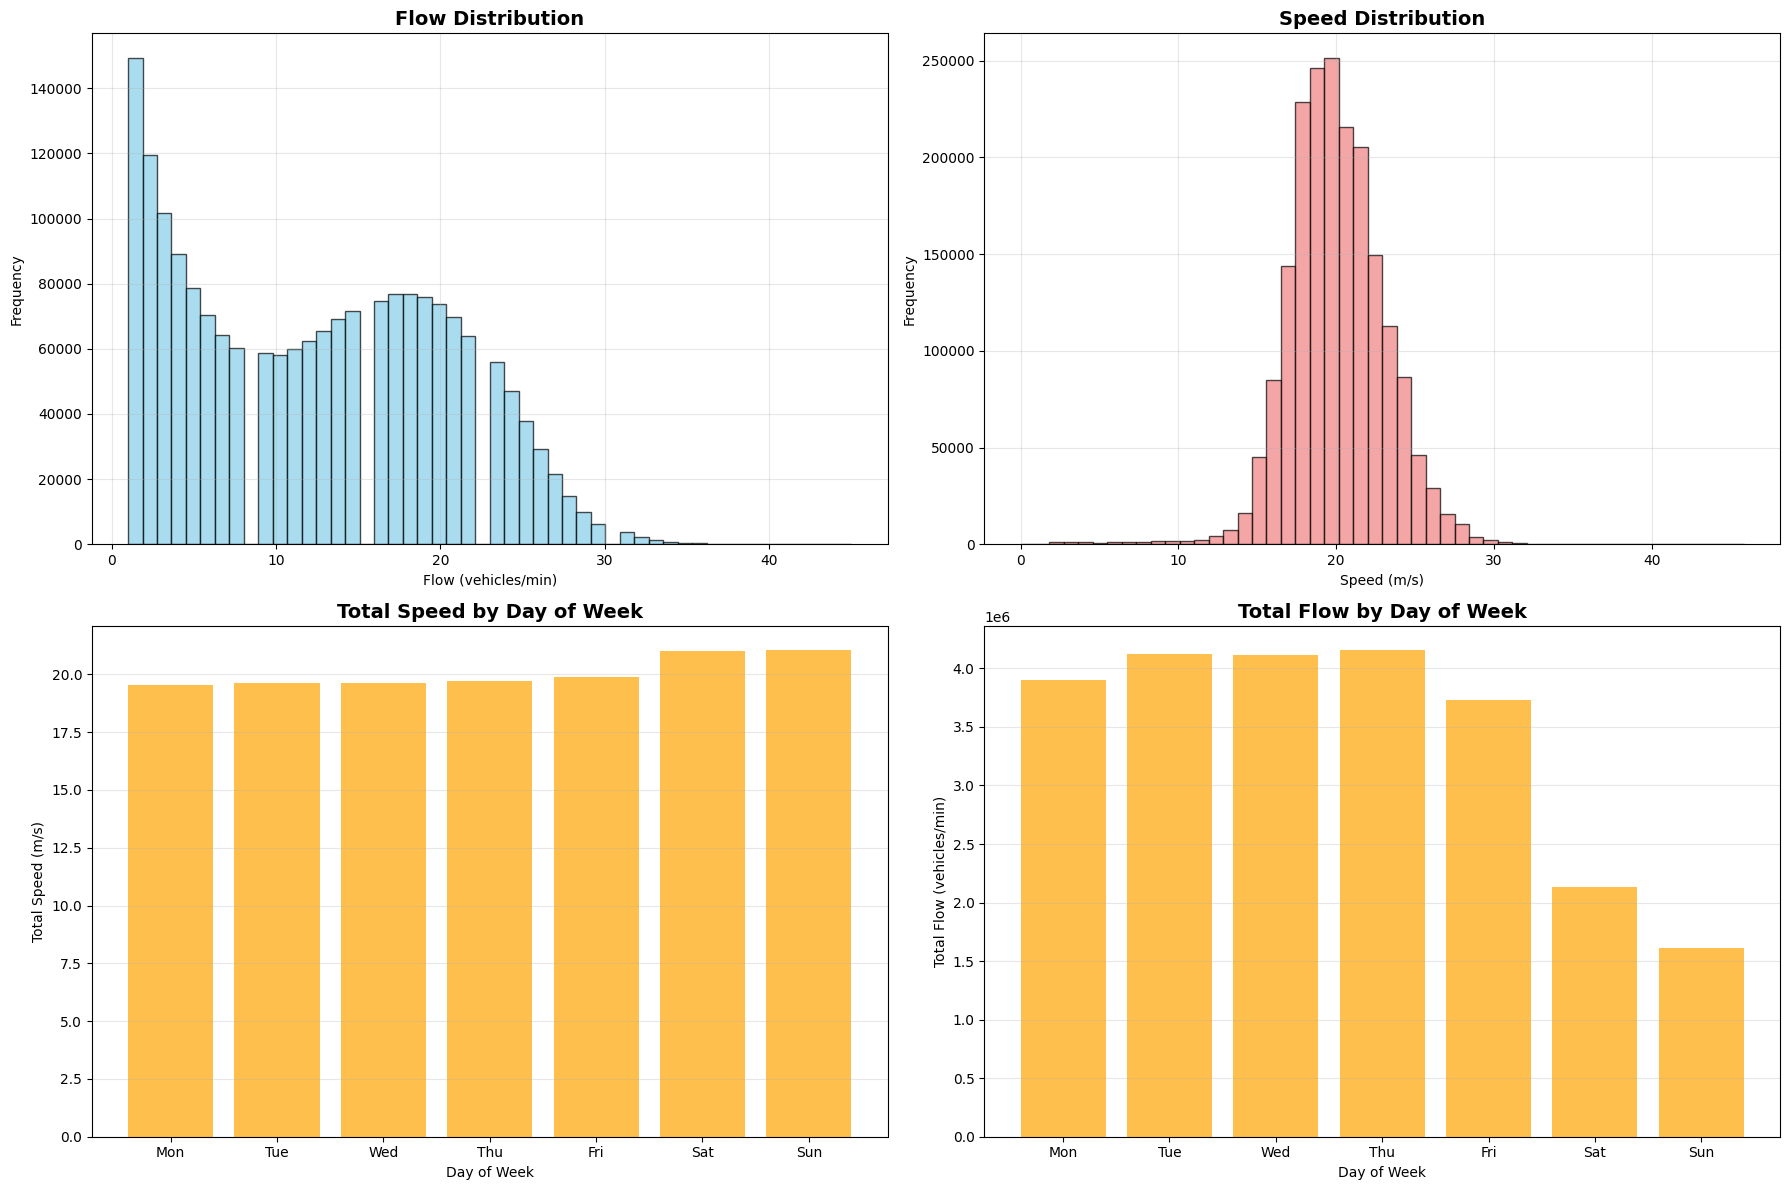

In [7]:
# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Flow histogram
axes[0,0].hist(df_train['FLOW'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Flow Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Flow (vehicles/min)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Speed histogram
axes[0,1].hist(df_train['SPEED_MS_AVG'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Speed Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Speed (m/s)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)


# Day of week analysis
dow_flow = df_train.groupby('DayOfWeek')['SPEED_MS_AVG'].mean()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].bar(range(7), dow_flow.values, color='orange', alpha=0.7)
axes[1,0].set_title('Total Speed by Day of Week', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Total Speed (m/s)')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(dow_names)
axes[1,0].grid(True, alpha=0.3, axis='y')

# Day of week analysis
dow_flow = df_train.groupby('DayOfWeek')['FLOW'].sum()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(range(7), dow_flow.values, color='orange', alpha=0.7)
axes[1,1].set_title('Total Flow by Day of Week', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Total Flow (vehicles/min)')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(dow_names)
axes[1,1].grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

### 3. Adding Sector Classification Based on Highway Geography

In [8]:
# Based on the MCS schema and Stockholm highway map, define sectors for each portal

def assign_sector(portal):
    """
    Assign sector based on portal location and highway geography
    
    Sectors based on the provided MCS schema:
    - Blue Sector : E4S 58,140, E4S 57,820, E4S 57,435, E4S 57,055
    - Pink Sector : E4S 56,780, E4S 56,490 
    - Yellow Sector : E4S 56,160 
    - Green Sector : E4S 55,620 
    """
    
    sector_mapping = {
        'E4S 58,140': 'Blue Sector',
        'E4S 57,820': 'Blue Sector',
        'E4S 57,435': 'Blue Sector',
        'E4S 57,055': 'Blue Sector',
        'E4S 56,780': 'Pink Sector',
        'E4S 56,490': 'Pink Sector',
        'E4S 56,160': 'Yellow Sector',
        'E4S 55,620': 'Green Sector'
    }
    
    return sector_mapping.get(portal, 'Unknown')

# Add the sector column to the dataframe
df_train['SECTOR'] = df_train['PORTAL'].apply(assign_sector)

print(f"\nTotal records: {len(df_train):,}")
print("\nPortal-to-Sector Mapping:")
portal_sector_mapping = df_train[['PORTAL', 'SECTOR']].drop_duplicates().sort_values('PORTAL')
for _, row in portal_sector_mapping.iterrows():
    print(f"  {row['PORTAL']} → {row['SECTOR']}")

# Verify the mapping
print("All portals successfully mapped to sectors:", df_train['SECTOR'].isna().sum() == 0)


Total records: 1,921,967

Portal-to-Sector Mapping:
  E4S 55,620 → Green Sector
  E4S 56,160 → Yellow Sector
  E4S 56,490 → Pink Sector
  E4S 56,780 → Pink Sector
  E4S 57,055 → Blue Sector
  E4S 57,435 → Blue Sector
  E4S 57,820 → Blue Sector
  E4S 58,140 → Blue Sector
All portals successfully mapped to sectors: True


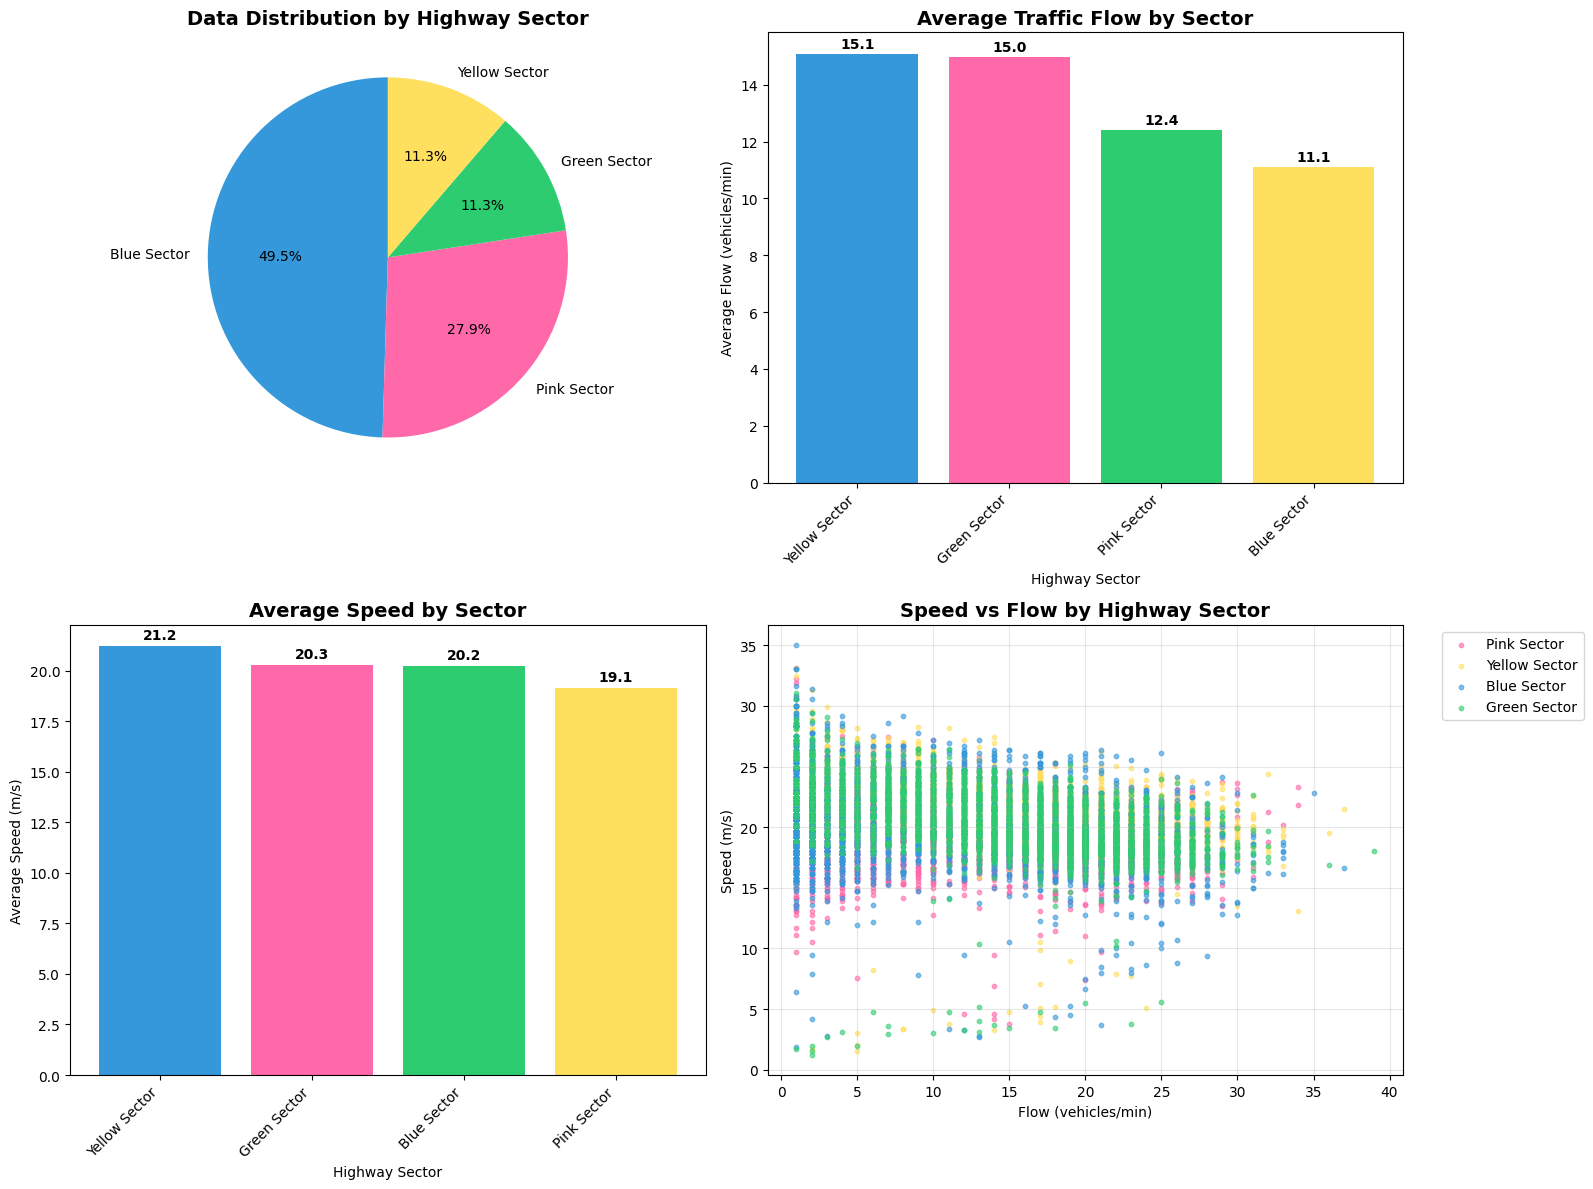

In [9]:
# Visualize sector distribution and traffic characteristics by sector
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sector data distribution (pie chart)
sector_counts = df_train['SECTOR'].value_counts()

# Define colors that match sector names
sector_color_mapping = {
    'Blue Sector': '#3498db',    # Blue
    'Pink Sector': "#ff68a9",    # Pink
    'Yellow Sector': "#ffdf5e",  # Yellow
    'Green Sector': '#2ecc71'    # Green
}

# Create color list in the order of sector_counts
colors = [sector_color_mapping.get(sector, '#95a5a6') for sector in sector_counts.index]
axes[0,0].pie(sector_counts.values, labels=sector_counts.index, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,0].set_title('Data Distribution by Highway Sector', fontsize=14, fontweight='bold')

# 2. Average flow by sector
sector_flow = df_train.groupby('SECTOR')['FLOW'].mean().sort_values(ascending=False)
bars1 = axes[0,1].bar(range(len(sector_flow)), sector_flow.values, color=colors)
axes[0,1].set_title('Average Traffic Flow by Sector', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Highway Sector')
axes[0,1].set_ylabel('Average Flow (vehicles/min)')
axes[0,1].set_xticks(range(len(sector_flow)))
axes[0,1].set_xticklabels([label.replace(' - ', '\n') for label in sector_flow.index], rotation=45, ha='right')

# Add value labels on bars
for bar, value in zip(bars1, sector_flow.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# 3. Average speed by sector
sector_speed = df_train.groupby('SECTOR')['SPEED_MS_AVG'].mean().sort_values(ascending=False)
bars2 = axes[1,0].bar(range(len(sector_speed)), sector_speed.values, color=colors)
axes[1,0].set_title('Average Speed by Sector', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Highway Sector')
axes[1,0].set_ylabel('Average Speed (m/s)')
axes[1,0].set_xticks(range(len(sector_speed)))
axes[1,0].set_xticklabels([label.replace(' - ', '\n') for label in sector_speed.index], rotation=45, ha='right')

# Add value labels on bars
for bar, value in zip(bars2, sector_speed.values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                   f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# 4. Flow vs Speed by sector (scatter plot)
for sector in df_train['SECTOR'].unique():
    sector_data = df_train[df_train['SECTOR'] == sector].sample(n=min(3000, len(df_train[df_train['SECTOR'] == sector])), random_state=42)
    sector_color = sector_color_mapping.get(sector, '#95a5a6')
    axes[1,1].scatter(sector_data['FLOW'], sector_data['SPEED_MS_AVG'], 
                     alpha=0.6, s=10, c=sector_color, label=sector)

axes[1,1].set_title('Speed vs Flow by Highway Sector', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Flow (vehicles/min)')
axes[1,1].set_ylabel('Speed (m/s)')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### 4. Detailed Flow vs Speed Analysis by Sector

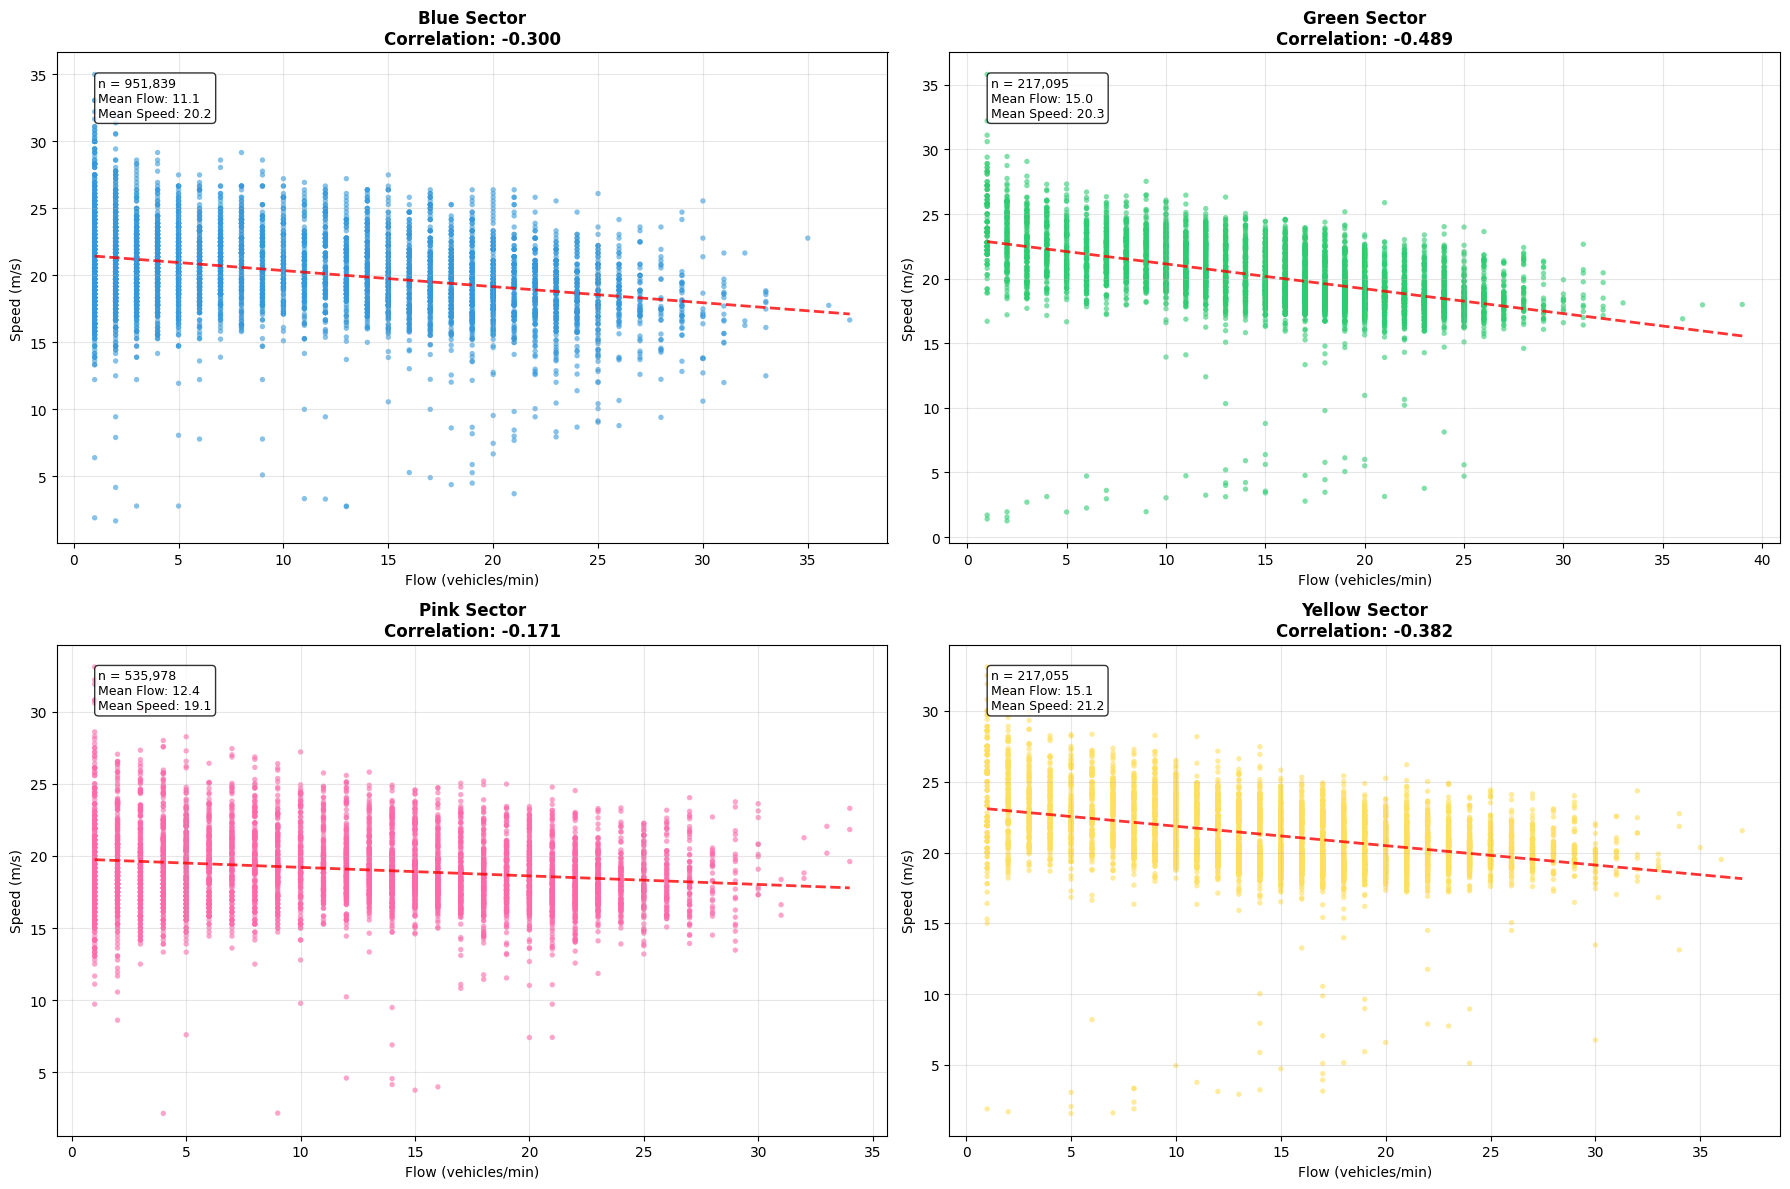

In [10]:
# Create detailed flow vs speed analysis for each sector
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sectors = sorted(df_train['SECTOR'].unique())

for i, sector in enumerate(sectors):
    sector_data = df_train[df_train['SECTOR'] == sector]
    
    # Sample data for better visualization (max 5000 points per sector)
    if len(sector_data) > 5000:
        sector_sample = sector_data.sample(n=5000, random_state=42)
    else:
        sector_sample = sector_data
    
    # Get the appropriate color for this sector
    sector_color = sector_color_mapping.get(sector, '#95a5a6')
    
    # Create scatter plot
    axes[i].scatter(sector_sample['FLOW'], sector_sample['SPEED_MS_AVG'], 
                   alpha=0.6, s=15, c=sector_color, edgecolors='none')
    
    # Add trend line
    z = np.polyfit(sector_sample['FLOW'], sector_sample['SPEED_MS_AVG'], 1)
    p = np.poly1d(z)
    flow_range = np.linspace(sector_sample['FLOW'].min(), sector_sample['FLOW'].max(), 100)
    axes[i].plot(flow_range, p(flow_range), "r--", alpha=0.8, linewidth=2)
    
    # Calculate correlation
    correlation = sector_sample['FLOW'].corr(sector_sample['SPEED_MS_AVG'])
    
    # Set title and labels
    axes[i].set_title(f'{sector}\nCorrelation: {correlation:.3f}', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Flow (vehicles/min)')
    axes[i].set_ylabel('Speed (m/s)')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'n = {len(sector_data):,}\nMean Flow: {sector_data["FLOW"].mean():.1f}\nMean Speed: {sector_data["SPEED_MS_AVG"].mean():.1f}'
    axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, 
                fontsize=9, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


## Bottleneck portal detection

In [11]:
# Aggregate df_train by portal and time interval: mean for SPEED_MS_AVG, sum for FLOW, keep other features
df_portal_agg = df_train.groupby(['PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60']).agg({
    'SPEED_MS_AVG': 'mean',  # Average speed across sensors at this portal
    'FLOW': 'sum',           # Total flow (sum of all sensors at this portal)
    'DP_ID': 'count',        # Count of active sensors at this portal
    'DateTime': 'first',     # Keep DateTime
    'Hour': 'first',         # Keep Hour
    'DayOfWeek': 'first',    # Keep DayOfWeek  
    'Month': 'first',        # Keep Month
    'SECTOR': 'first'        # Keep Sector (same for all sensors in a portal)
}).reset_index()

del df_train  

# Rename DP_ID count to be more descriptive
df_portal_agg = df_portal_agg.rename(columns={'DP_ID': 'NUM_LANES'})

print("Portal-level aggregated data:")
print(f"Shape: {df_portal_agg.shape}")
print(f"Portals: {df_portal_agg['PORTAL'].nunique()}")
print(f"Time intervals: {len(df_portal_agg)}")
print("\nFirst few records:")
print(df_portal_agg.head())

print(f"\nSensors per portal distribution:")
print(df_portal_agg.groupby('PORTAL')['NUM_LANES'].describe())

Portal-level aggregated data:
Shape: (604028, 16)
Portals: 8
Time intervals: 604028

First few records:
       PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
0  E4S 55,620  20210601  04:00:00         240          48           16   
1  E4S 55,620  20210601  04:01:00         241          48           16   
2  E4S 55,620  20210601  04:02:00         242          48           16   
3  E4S 55,620  20210601  04:03:00         243          48           16   
4  E4S 55,620  20210601  04:04:00         244          48           16   

   Interval_30  Interval_60  SPEED_MS_AVG  FLOW  NUM_LANES  \
0            8            4     22.110000  29.0          3   
1            8            4     23.533333  26.0          3   
2            8            4     21.830000  38.0          3   
3            8            4     22.736667  34.0          3   
4            8            4     23.336667  29.0          3   

             DateTime  Hour  DayOfWeek  Month        SECTOR  
0 2021-06-01 04:

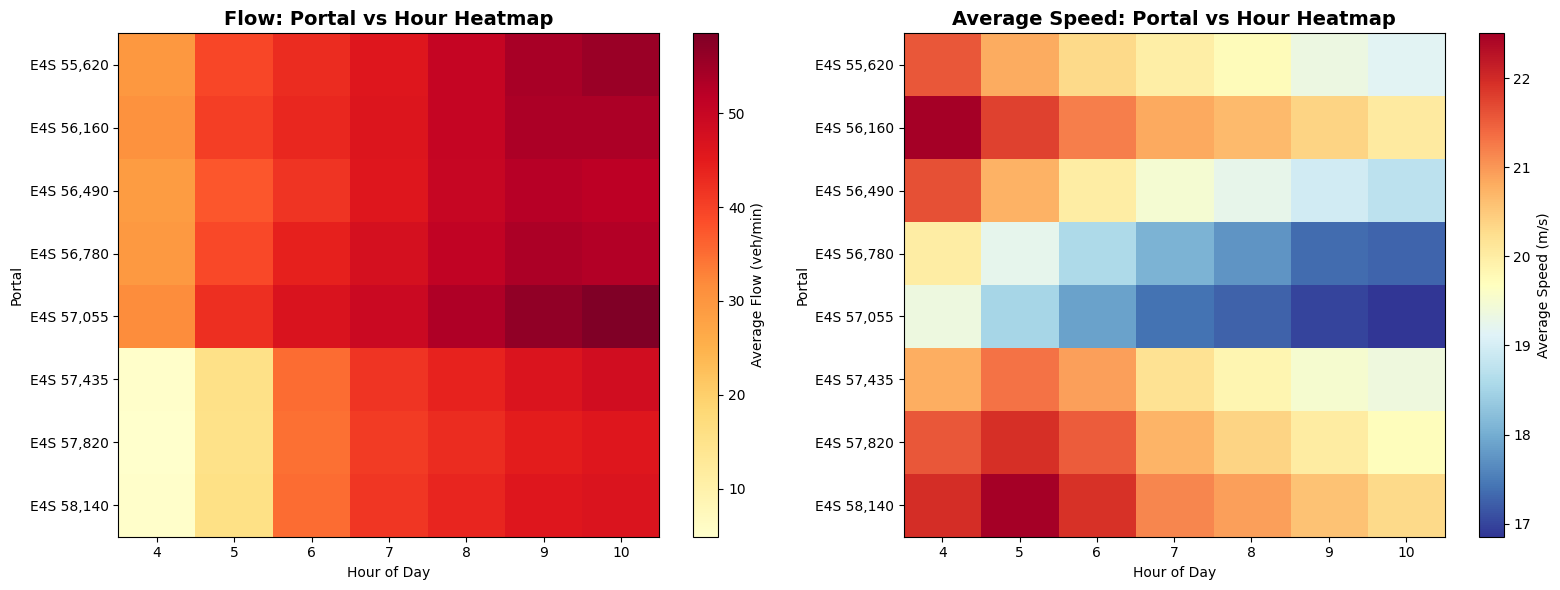

In [12]:
# Create spatio-temporal heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Portal vs Hour heatmap for Flow
portal_hour_flow = df_portal_agg.pivot_table(values='FLOW', index='PORTAL', columns='Hour', aggfunc='mean')
im1 = axes[0].imshow(portal_hour_flow.values, cmap='YlOrRd', aspect='auto')
axes[0].set_title('Flow: Portal vs Hour Heatmap', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Portal')
axes[0].set_xticks(range(len(portal_hour_flow.columns)))
axes[0].set_xticklabels(portal_hour_flow.columns)
axes[0].set_yticks(range(len(portal_hour_flow.index)))
axes[0].set_yticklabels(portal_hour_flow.index, fontsize=10)
plt.colorbar(im1, ax=axes[0], label='Average Flow (veh/min)')

# Portal vs Hour heatmap for Speed
portal_hour_speed = df_portal_agg.pivot_table(values='SPEED_MS_AVG', index='PORTAL', columns='Hour', aggfunc='mean')
im2 = axes[1].imshow(portal_hour_speed.values, cmap='RdYlBu_r', aspect='auto')
axes[1].set_title('Average Speed: Portal vs Hour Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Portal')
axes[1].set_xticks(range(len(portal_hour_speed.columns)))
axes[1].set_xticklabels(portal_hour_speed.columns)
axes[1].set_yticks(range(len(portal_hour_speed.index)))
axes[1].set_yticklabels(portal_hour_speed.index, fontsize=10)
plt.colorbar(im2, ax=axes[1], label='Average Speed (m/s)')

plt.tight_layout()
plt.show()

CONGESTION WAVE PROPAGATION ANALYSIS
📅 Analysis for date: 20210923
   Number of records: 2888


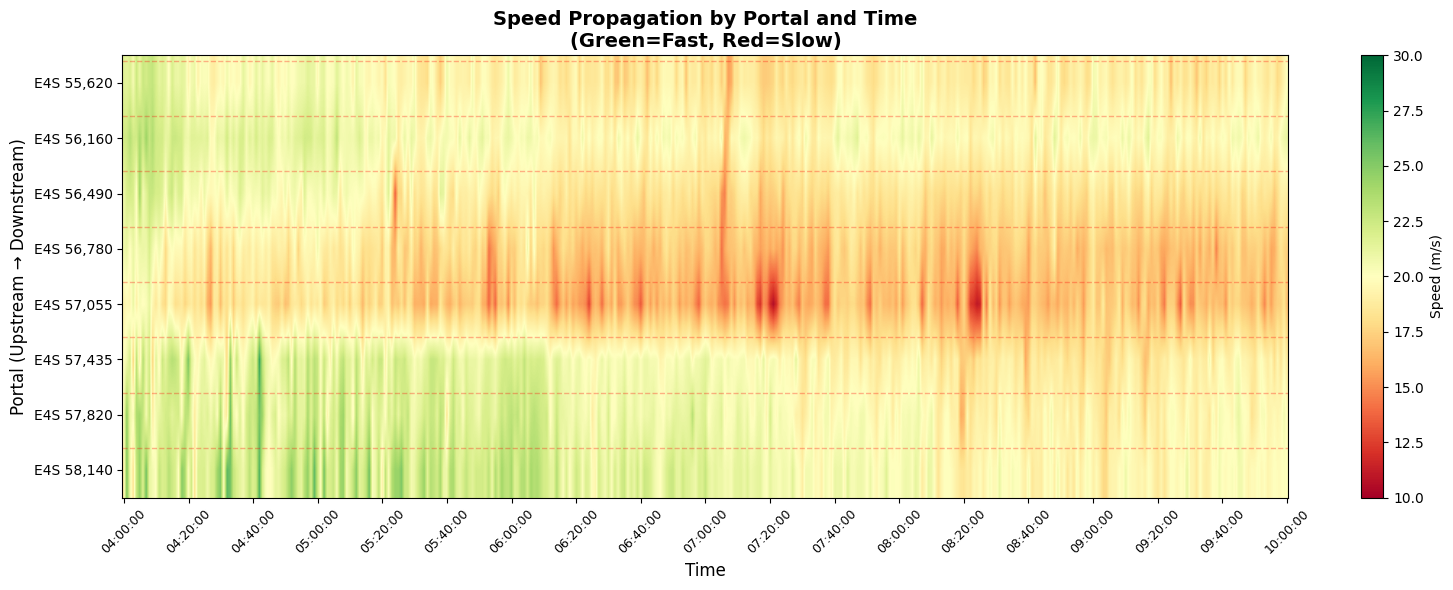

In [13]:
# CONGESTION WAVE PROPAGATION - Temporal analysis
print("CONGESTION WAVE PROPAGATION ANALYSIS")


# Focus on a specific morning peak day for wave propagation analysis
# Select a representative day with good data coverage
sample_dates = df_portal_agg['Date'].value_counts().head(10).index
representative_date = sample_dates[9]  # Take the date with most records

daily_data = df_portal_agg[df_portal_agg['Date'] == representative_date].copy()
daily_data = daily_data.sort_values(['PORTAL', 'Time'])

CONGESTION_THRESHOLD = 15  # Speed threshold in m/s to define congestion

print(f"📅 Analysis for date: {representative_date}")
print(f"   Number of records: {len(daily_data)}")

# Create time-space diagram for speed
fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# Prepare data for heatmap
time_speed_data = daily_data.pivot_table(values='SPEED_MS_AVG', 
                                        index='PORTAL', 
                                        columns='Time', 
                                        aggfunc='mean')

time_flow_data = daily_data.pivot_table(values='FLOW', 
                                       index='PORTAL', 
                                       columns='Time', 
                                       aggfunc='sum')

# Speed heatmap
if not time_speed_data.empty:
    im1 = axes.imshow(time_speed_data.values, cmap='RdYlGn', aspect='auto', 
                        vmin=10, vmax=30, interpolation='bilinear')
    axes.set_title('Speed Propagation by Portal and Time\n(Green=Fast, Red=Slow)', 
                     fontsize=14, fontweight='bold')
    axes.set_ylabel('Portal (Upstream → Downstream)', fontsize=12)

    # Set y-axis labels
    axes.set_yticks(range(len(time_speed_data.index)))
    axes.set_yticklabels(time_speed_data.index, fontsize=10)

    # Set x-axis to show hours
    time_labels = [t for i, t in enumerate(time_speed_data.columns) if i % 20 == 0]
    time_positions = [i for i in range(0, len(time_speed_data.columns), 20)]
    axes.set_xticks(time_positions)
    axes.set_xticklabels(time_labels, rotation=45, fontsize=9)
    axes.set_xlabel('Time', fontsize=12)

    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=axes, label='Speed (m/s)')

    # Add congestion threshold line
    congestion_level = (30 - CONGESTION_THRESHOLD) / (30 - 10) * len(time_speed_data.values)
    for i in range(len(time_speed_data.index)):
        axes.axhline(y=i-0.4, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.show()

del daily_data


## Macroscopic Theory

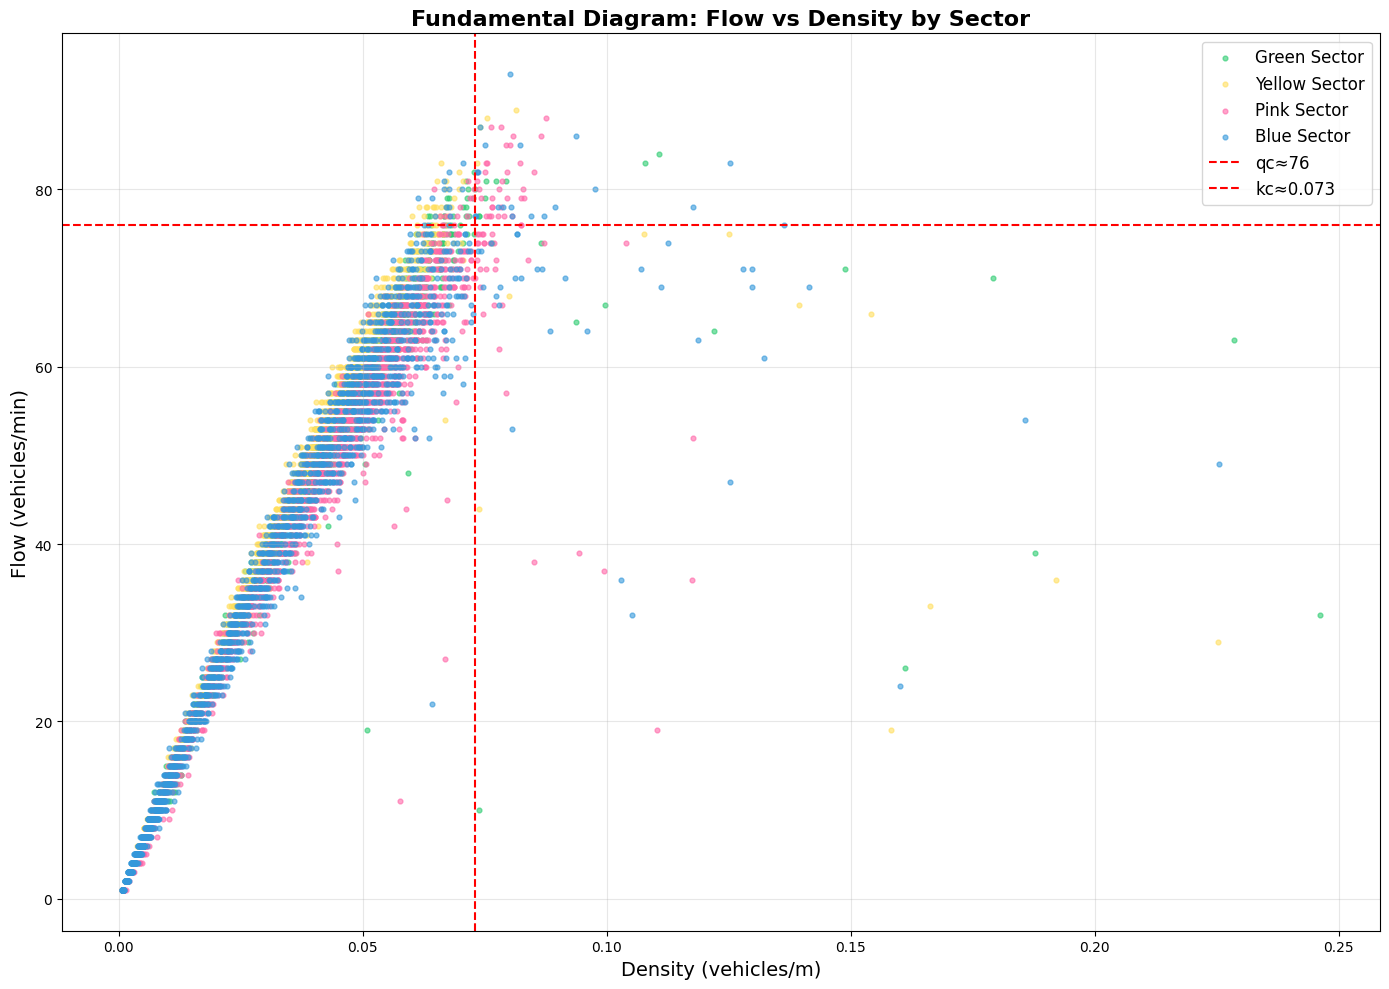

Estimated free flow speed (all sectors): 20.806030657493373


In [14]:
# Fundamental Traffic Flow Diagram: Flow vs Density
# Density = Flow / Speed (vehicles per meter)
# Note: Flow is in vehicles/minute, Speed is in m/s
# So density = (Flow vehicles/min) / (Speed m/s) = (Flow/60) / Speed vehicles/m

df_portal_agg['DENSITY'] = (df_portal_agg['FLOW'] / 60) / df_portal_agg['SPEED_MS_AVG']


# Remove infinite and NaN values (where speed = 0)
df_clean = df_portal_agg.dropna(subset=['DENSITY', 'FLOW', 'SPEED_MS_AVG'])
df_clean = df_clean[df_clean['DENSITY'] != np.inf]
df_clean = df_clean[df_clean['DENSITY'] >= 0]

qc_estimate = np.percentile(df_clean['FLOW'], 98) 
kc_estimate = np.mean(df_clean['DENSITY'][df_clean['FLOW'] >= qc_estimate * 0.95])
free_flow_speed = np.mean(df_clean['SPEED_MS_AVG'][df_clean['DENSITY'] < 0.05])

# Create fundamental diagram: Flow vs Density by Sector
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

sector_color_mapping = {
    'Blue Sector': '#3498db',    
    'Pink Sector': "#ff68a9",    
    'Yellow Sector': "#ffdf5e",  
    'Green Sector': '#2ecc71'    
}

# Plot data by sector and calculate maximum capacity for each
sector_capacities = {}

for sector in df_clean['SECTOR'].unique():
    sector_data = df_clean[df_clean['SECTOR'] == sector]
    
    # Sample data for better visualization
    if len(sector_data) > 2000:
        sector_sample = sector_data.sample(n=2000, random_state=42)
    else:
        sector_sample = sector_data
    
    sector_color = sector_color_mapping.get(sector, '#95a5a6')
    ax.scatter(sector_sample['DENSITY'], sector_sample['FLOW'], 
               alpha=0.6, s=12, c=sector_color, label=sector)
    
    # Find maximum capacity (flow) for this sector
    max_flow_idx = sector_data['FLOW'].idxmax()
    max_capacity = sector_data.loc[max_flow_idx, 'FLOW']
    optimal_density = sector_data.loc[max_flow_idx, 'DENSITY']
    optimal_speed = sector_data.loc[max_flow_idx, 'SPEED_MS_AVG']
    
    sector_capacities[sector] = {
        'max_flow': max_capacity,
        'optimal_density': optimal_density,
        'optimal_speed': optimal_speed
    }
ax.axhline(y=qc_estimate, color='red', linestyle='--', label=f'qc≈{qc_estimate:.0f}')
ax.axvline(x=kc_estimate, color='red', linestyle='--', label=f'kc≈{kc_estimate:.3f}')
ax.set_xlabel('Density (vehicles/m)', fontsize=14)
ax.set_ylabel('Flow (vehicles/min)', fontsize=14)
ax.set_title('Fundamental Diagram: Flow vs Density by Sector', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Estimated free flow speed (all sectors):", free_flow_speed)


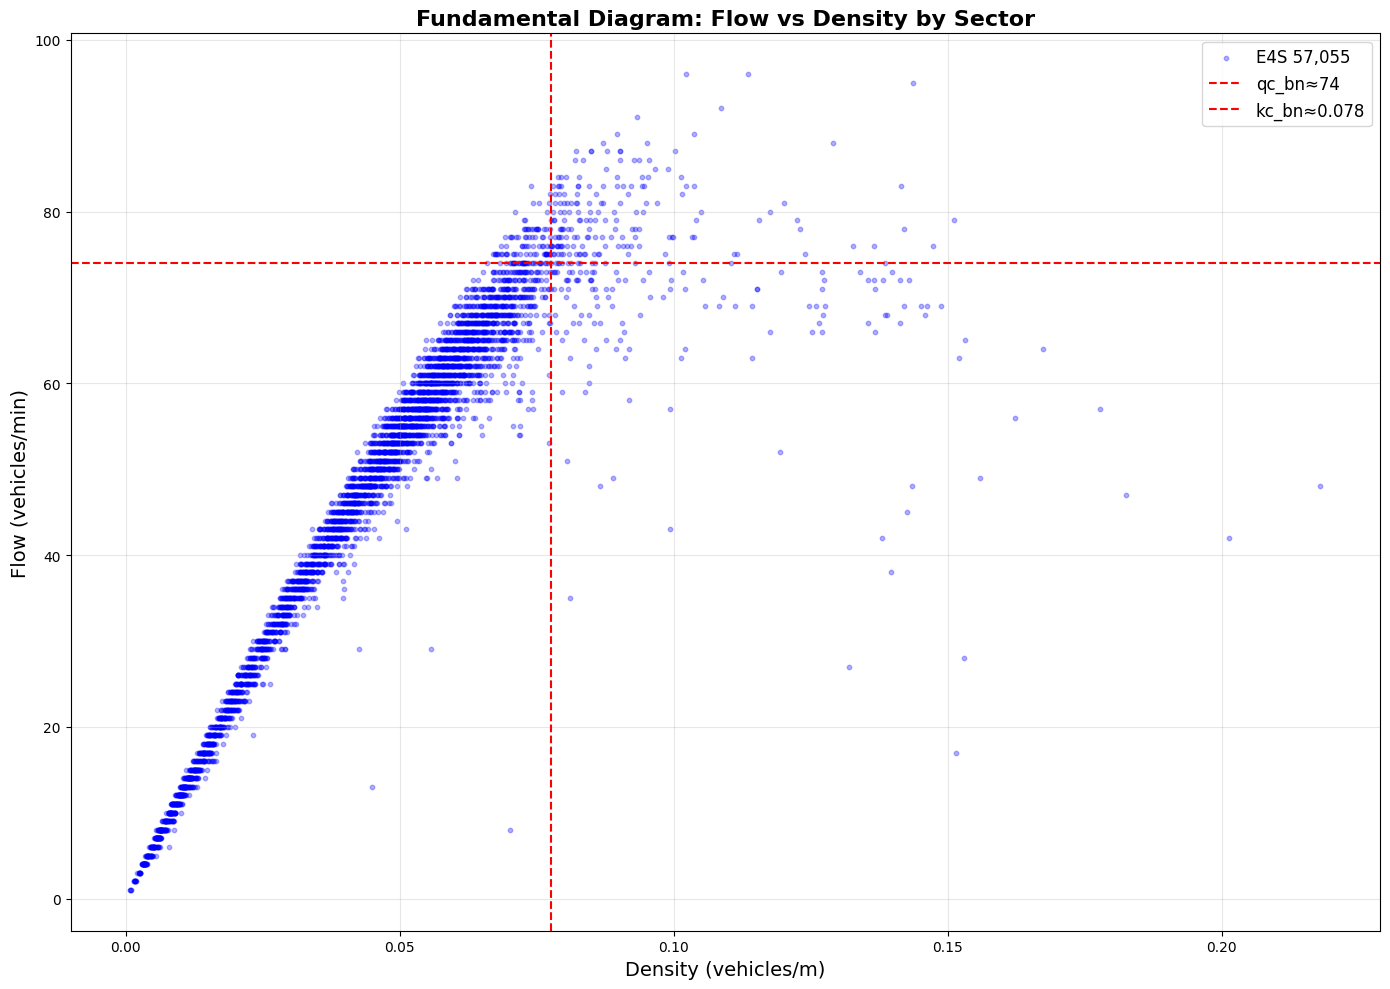

Estimated free flow speed (Bottleneck portal): 19.0139087133834


In [15]:
# Fundamental Traffic Flow Diagram: Flow vs Density
# Density = Flow / Speed (vehicles per meter)
# Note: Flow is in vehicles/minute, Speed is in m/s
# So density = (Flow vehicles/min) / (Speed m/s) = (Flow/60) / Speed vehicles/m

target_portal = 'E4S 57,055'

df_target_portal = df_portal_agg[df_portal_agg['PORTAL'] == target_portal]

qc_bn_estimate = np.percentile(df_target_portal['FLOW'], 95) 
kc_bn_estimate = np.mean(df_target_portal['DENSITY'][df_target_portal['FLOW'] >= qc_bn_estimate * 0.9])
free_flow_bn_speed = np.mean(df_target_portal['SPEED_MS_AVG'][df_target_portal['DENSITY'] < 0.05])

# Create fundamental diagram: Flow vs Density by Sector
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

sample_portal_data = df_target_portal.sample(n=min(5000, len(df_target_portal)), random_state=42)
ax.scatter(sample_portal_data['DENSITY'], sample_portal_data['FLOW'], 
           alpha=0.3, s=10, c='blue', label=target_portal)

ax.axhline(y=qc_bn_estimate, color='red', linestyle='--', label=f'qc_bn≈{qc_bn_estimate:.0f}')
ax.axvline(x=kc_bn_estimate, color='red', linestyle='--', label=f'kc_bn≈{kc_bn_estimate:.3f}')
ax.set_xlabel('Density (vehicles/m)', fontsize=14)
ax.set_ylabel('Flow (vehicles/min)', fontsize=14)
ax.set_title('Fundamental Diagram: Flow vs Density by Sector', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Estimated free flow speed (Bottleneck portal):", free_flow_bn_speed)


In [35]:
global_qc = 75.0
global_kc = 0.075
global_ff = 20.0  # Free flow speed in m/s

del df_portal_agg

NameError: name 'df_portal_agg' is not defined

## B. Problem formulation

- **Primary task**  
    At time t, predict the average FLOW over the next 15 minutes [t+1, t+15] at the bottleneck portal `E4S 57,055`.

- **Optional**  
    - Classification: will there be congestion in the next 15 minutes?

- **Assumptions & hypotheses**  
    - Fluid traffic at the target portal ⇒ fluid traffic everywhere.  
    - High periodicity: weekday vs weekend/holidays.  
    - No weather features (unless shown to be significant).  
    - Use of lagged features: both recent (≤ 30 minutes) and older (1–2 hours).  
    - Maximum capacity threshold considered.

## C. Model Development

### 1.Data Preprocessing

In [17]:
df_original = pd.read_csv('training_dataset.csv', sep=';')
df_original.isnull().sum()

print('Before drop:', df_original[df_original['FLOW'].isnull()]['Date'].nunique()/df_original['Date'].nunique())

df_nonans = df_original.dropna(subset=['FLOW'])

print('After drop:', df_nonans[df_nonans['FLOW'].isnull()]['Date'].nunique()/df_nonans['Date'].nunique())



Before drop: 0.03271028037383177
After drop: 0.0


### 2. Feature Engineering: Macroscopic Traffic Flow Features

In [18]:
# STEP 1: SENSOR-LEVEL PROCESSING
df_sensors = df_nonans.copy()

del df_nonans

# Convert DateTime for time-based features
df_sensors['DateTime'] = pd.to_datetime(df_sensors['Date'].astype(str) + ' ' + df_sensors['Time'])
df_sensors = df_sensors.sort_values(['DP_ID', 'DateTime']).reset_index(drop=True)

# Basic macroscopic features per sensor
df_sensors['SPEED_CAPPED'] = np.maximum(df_sensors['SPEED_MS_AVG'], 1.0)
df_sensors['DENSITY'] = (df_sensors['FLOW'] / 60) / df_sensors['SPEED_CAPPED']

print("Macroscopic feature engineering - sensor level")

Macroscopic feature engineering - sensor level


In [ ]:
# STEP 2: AGGREGATION TO PORTAL LEVEL

# Aggregate df_train by portal and time interval: mean for SPEED_MS_AVG, sum for FLOW, keep other features
df_portal_agg = df_sensors.groupby(['PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60']).agg({
    'SPEED_MS_AVG': 'mean',  # Average speed across sensors at this portal
    'FLOW': 'sum',           # Total flow (sum of all sensors at this portal)
    'DP_ID': 'count',        # Count of active sensors at this portal
    'DateTime': 'first',     # Keep DateTime
    'DENSITY': 'mean',      # Average density across sensors at this portal
    'SPEED_CAPPED': 'mean', # Average capped speed
}).reset_index()

del df_sensors

# Rename DP_ID count to be more descriptive
df_portal_agg = df_portal_agg.rename(columns={'DP_ID': 'NUM_LANES'})


print(f" Portal-level aggregation")
print(f"  Original sensor records: {len(df_sensors):,}")
print(f"  Aggregated portal records: {len(df_portal_agg):,}")
print(f"  Portals: {df_portal_agg['PORTAL'].nunique()}")

 Portal-level aggregation
  Original sensor records: 1,921,905
  Aggregated portal records: 604,026
  Portals: 8


In [20]:
# STEP 3: PORTAL-LEVEL MACROSCOPIC FEATURES

df_features = df_portal_agg.copy()

del df_portal_agg

# Sort by portal and time for spatial-temporal features
portal_order = ['E4S 58,140', 'E4S 57,820', 'E4S 57,435', 'E4S 57,055', 
                'E4S 56,780', 'E4S 56,490', 'E4S 56,160', 'E4S 55,620']
df_features['PORTAL_ORDER'] = df_features['PORTAL'].map({portal: i for i, portal in enumerate(portal_order)})
df_features = df_features.sort_values(['PORTAL_ORDER', 'DateTime']).reset_index(drop=True)

# Critical values and fundamental diagram features (portal level)
df_features['DENSITY_RATIO'] = df_features['DENSITY'] / global_kc
df_features['FLOW_RATIO'] = df_features['FLOW'] / global_qc
df_features['DIST_TO_KC'] = global_kc - df_features['DENSITY']
df_features['DIST_TO_QC'] = global_qc - df_features['FLOW']

# Traffic regime classification (portal level)
def classify_regime_portal(row):
    if row['SPEED_MS_AVG'] > global_ff * 0.9 and row['DENSITY'] < global_kc * 0.5:
        return 'free_flow'
    elif row['FLOW'] > global_qc  * 0.8:
        return 'near_capacity'
    elif row['SPEED_MS_AVG'] < global_ff * 0.7 and row['DENSITY'] > global_kc * 0.6:
        return 'congested'
    else:
        return 'intermediate'

df_features['TRAFFIC_REGIME'] = df_features.apply(classify_regime_portal, axis=1)

# Spatial-temporal features (portal level)

df_interval_1_flow = df_features[['PORTAL', 'Date', 'Interval_1', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_1'])['FLOW'].mean().reset_index()

df_interval_1_speed = df_features[['PORTAL', 'Date', 'Interval_1', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_1'])['SPEED_MS_AVG'].mean().reset_index()

df_interval_5_flow = df_features[['PORTAL', 'Date', 'Interval_5', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_5'])['FLOW'].mean().reset_index()

df_interval_5_speed = df_features[['PORTAL', 'Date', 'Interval_5', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_5'])['SPEED_MS_AVG'].mean().reset_index()

df_interval_15_flow = df_features[['PORTAL', 'Date', 'Interval_15', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_15'])['FLOW'].mean().reset_index()

df_interval_15_speed = df_features[['PORTAL', 'Date', 'Interval_15', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_15'])['SPEED_MS_AVG'].mean().reset_index()

df_interval_60_flow = df_features[['PORTAL', 'Date', 'Interval_60', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_60'])['FLOW'].mean().reset_index()

df_interval_60_speed = df_features[['PORTAL', 'Date', 'Interval_60', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_60'])['SPEED_MS_AVG'].mean().reset_index()

# Merge lagged features back to main dataframe

def add_lagged_features(df_main, df_lag_source, interval_col, value_col, lags, feature_label):
    """
    Merge lagged features into df_main from df_lag_source.

    Parameters:
        df_main (pd.DataFrame): Original dataframe.
        df_lag_source (pd.DataFrame): Aggregated dataframe with one row per interval.
        interval_col (str): Name of the interval column (e.g., 'Interval_1').
        value_col (str): Name of the column to lag (e.g., 'FLOW').
        lags (list of int): List of lags to apply. 0 means current interval.
        feature_label (str): Suffix label to describe the time unit (e.g., '1MIN', '5MIN').

    Returns:
        pd.DataFrame: df_main with lagged features merged.
    """
    df_result = df_main.copy()
    
    for lag in lags:
        df_lag = df_lag_source.copy()
        # Shift interval to align lagged value with current row
        df_lag[interval_col] = df_lag[interval_col] + lag

        suffix = f'_LAG{lag}_{feature_label}'
        df_lag_renamed = df_lag.rename(columns={value_col: value_col + suffix})

        # Merge with main DataFrame
        df_result = df_result.merge(
            df_lag_renamed,
            on=['PORTAL', 'Date', interval_col],
            how='left'
        )
    return df_result

df_features = add_lagged_features(df_features, df_interval_1_flow, 'Interval_1', 'FLOW', lags=[0,1,2,3,4], feature_label='1MIN')
df_features = add_lagged_features(df_features, df_interval_1_speed, 'Interval_1', 'SPEED_MS_AVG', lags=[0,1,2,3,4], feature_label='1MIN')
df_features = add_lagged_features(df_features, df_interval_5_flow, 'Interval_5', 'FLOW', lags=[1,2,3], feature_label='5MIN')
df_features = add_lagged_features(df_features, df_interval_5_speed, 'Interval_5', 'SPEED_MS_AVG', lags=[1,2,3], feature_label='5MIN')
df_features = add_lagged_features(df_features, df_interval_15_flow, 'Interval_15', 'FLOW', lags=[1,2], feature_label='15MIN')
df_features = add_lagged_features(df_features, df_interval_15_speed, 'Interval_15', 'SPEED_MS_AVG', lags=[1,2], feature_label='15MIN')
df_features = add_lagged_features(df_features, df_interval_60_flow, 'Interval_60', 'FLOW', lags=[1,2], feature_label='60MIN')
df_features = add_lagged_features(df_features, df_interval_60_speed, 'Interval_60', 'SPEED_MS_AVG', lags=[1,2], feature_label='60MIN')

for portal in df_features['PORTAL'].unique():
    portal_mask = df_features['PORTAL'] == portal
    portal_data = df_features[portal_mask].copy().sort_values('DateTime')

    # Speed/flow trends (historical only)
    speed_change = portal_data['SPEED_MS_AVG'].diff()  # 1-minute change
    speed_trend_2min = portal_data[['SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN']].mean(axis=1) - portal_data[['SPEED_MS_AVG_LAG3_1MIN', 'SPEED_MS_AVG_LAG4_1MIN']].mean(axis=1)
    flow_trend_2min = portal_data[['FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN']].mean(axis=1) - portal_data[['FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN']].mean(axis=1)

    # Breakdown/recovery detection (historical only)
    breakdown_threshold = global_ff * 0.6
    recovery_threshold = global_ff * 0.8
    breakdown_flag = (portal_data['SPEED_MS_AVG'] < breakdown_threshold).astype(int)
    recovery_flag = (portal_data['SPEED_MS_AVG'] > recovery_threshold).astype(int)
    
    # Trend features (historical)
    df_features.loc[portal_mask, 'SPEED_CHANGE'] = speed_change.fillna(0)
    df_features.loc[portal_mask, 'SPEED_TREND_2MIN'] = speed_trend_2min.fillna(0)
    df_features.loc[portal_mask, 'FLOW_TREND_2MIN'] = flow_trend_2min.fillna(0)

    # State flags
    df_features.loc[portal_mask, 'BREAKDOWN_FLAG'] = breakdown_flag
    df_features.loc[portal_mask, 'RECOVERY_FLAG'] = recovery_flag

# Flow-speed-density interactions
df_features['DENSITY_SQUARED'] = df_features['DENSITY'] ** 2
df_features['FLOW_DENSITY'] = df_features['FLOW'] * df_features['DENSITY']
df_features['SPEED_DENSITY'] = df_features['SPEED_MS_AVG'] * df_features['DENSITY']
df_features['FLOW_SPEED'] = df_features['FLOW'] * df_features['SPEED_MS_AVG']
df_features['INV_SPEED'] = 1 / df_features['SPEED_CAPPED']

df_features['IS_CONGESTED'] = (df_features['TRAFFIC_REGIME'] == 'congested').astype(int)
df_features['IS_FREE_FLOW'] = (df_features['TRAFFIC_REGIME'] == 'free_flow').astype(int)
df_features['IS_NEAR_CAPACITY'] = (df_features['TRAFFIC_REGIME'] == 'near_capacity').astype(int)
df_features['IS_INTERMEDIATE'] = (df_features['TRAFFIC_REGIME'] == 'intermediate').astype(int)

df_features.drop(columns=['TRAFFIC_REGIME'], inplace=True)

print("Macroscopic feature engineering - portal level")

Macroscopic feature engineering - portal level


In [21]:
# STEP 4: SPATIAL-TEMPORAL FEATURES (INTER-PORTAL)

# Initialize spatial features
df_features['UPSTREAM_DEMAND'] = df_features['FLOW']  # Default fallback
df_features['DOWNSTREAM_SUPPLY'] = global_qc  # Default fallback
df_features['REALIZED_FLOW'] = df_features['FLOW']
df_features['DEMAND_SUPPLY_RATIO'] = 1.0

# Spatial gradient features
df_features['FLOW_GRADIENT'] = 0.0
df_features['SPEED_GRADIENT'] = 0.0
df_features['DENSITY_GRADIENT'] = 0.0

# Process spatial features by timestamp
unique_datetimes = df_features['DateTime'].unique()
sample_size = min(1000, len(unique_datetimes))  # Process subset for performance
sample_datetimes = unique_datetimes[:sample_size]

for datetime in sample_datetimes:
    time_mask = df_features['DateTime'] == datetime
    time_slice = df_features[time_mask].copy().sort_values('PORTAL_ORDER')
    
    if len(time_slice) > 1:  # Need at least 2 portals for spatial features
        
        # Spatial gradients (differences between adjacent portals)
        flow_gradient = time_slice['FLOW'].diff()
        speed_gradient = time_slice['SPEED_MS_AVG'].diff()
        density_gradient = time_slice['DENSITY'].diff()
        
        # CTM-based demand and supply
        upstream_flow = time_slice['FLOW'].shift(1)  # Previous portal
        upstream_density = time_slice['DENSITY'].shift(1)
        
        # Demand function (portal-adjusted)
        max_portal_flow = global_qc
        
        demand = np.minimum(upstream_flow.fillna(time_slice['FLOW']), 
                          max_portal_flow * (1 - upstream_density.fillna(0) / (2 * global_kc)))
        
        # Supply function 
        downstream_flow = time_slice['FLOW'].shift(-1)  # Next portal
        supply = np.maximum(0, max_portal_flow - downstream_flow.fillna(0))
        
        # Realized flow (Godunov scheme)
        realized = np.minimum.reduce([demand, supply, time_slice['FLOW']])
        
        # Update dataframe
        indices = time_slice.index
        df_features.loc[indices, 'FLOW_GRADIENT'] = flow_gradient.fillna(0)
        df_features.loc[indices, 'SPEED_GRADIENT'] = speed_gradient.fillna(0)
        df_features.loc[indices, 'DENSITY_GRADIENT'] = density_gradient.fillna(0)
        df_features.loc[indices, 'UPSTREAM_DEMAND'] = demand
        df_features.loc[indices, 'DOWNSTREAM_SUPPLY'] = supply
        df_features.loc[indices, 'REALIZED_FLOW'] = realized  # realized is already numpy array
        df_features.loc[indices, 'DEMAND_SUPPLY_RATIO'] = (demand / (supply + 1e-6))

print(" Spatial-temporal features created")

 Spatial-temporal features created


In [22]:
# STEP 5: CONGESTION PROPAGATION FEATURES

# Initialize congestion features
df_features['QUEUE_LENGTH'] = 0
df_features['QUEUE_PENETRATION'] = 0.0
df_features['CONGESTION_FRONT'] = 0  # 1 if this portal is congestion front

# Process congestion features by timestamp (sampled)
for datetime in sample_datetimes:
    time_mask = df_features['DateTime'] == datetime
    time_slice = df_features[time_mask].copy().sort_values('PORTAL_ORDER')
    
    if len(time_slice) > 1:
        congested_mask = time_slice['IS_CONGESTED'].values
        
        # Queue length: count of upstream congested portals
        queue_lengths = []
        penetrations = []
        congestion_fronts = []
        
        for i, (_, row) in enumerate(time_slice.iterrows()):
            # Count upstream congested portals
            upstream_congested = congested_mask[:i].sum() if i > 0 else 0
            total_upstream = max(1, i)
            penetration = upstream_congested / total_upstream
            
            # Congestion front: congested portal with free-flow upstream
            is_front = 0
            if row['IS_CONGESTED'] == 1:
                if i == 0:  # First portal
                    is_front = 1
                elif congested_mask[i-1] == 0:  # Previous portal not congested
                    is_front = 1
            
            queue_lengths.append(upstream_congested)
            penetrations.append(penetration)
            congestion_fronts.append(is_front)
        
        # Update dataframe
        indices = time_slice.index
        df_features.loc[indices, 'QUEUE_LENGTH'] = queue_lengths
        df_features.loc[indices, 'QUEUE_PENETRATION'] = penetrations
        df_features.loc[indices, 'CONGESTION_FRONT'] = congestion_fronts

# Add temporal congestion features per portal
for portal in df_features['PORTAL'].unique():
    portal_mask = df_features['PORTAL'] == portal
    portal_data = df_features[portal_mask].copy().sort_values('DateTime')
    
    # Queue growth rate
    queue_growth = portal_data['QUEUE_LENGTH'].diff().rolling(window=3, center=True).mean()
    df_features.loc[portal_mask, 'QUEUE_GROWTH_RATE'] = queue_growth.fillna(0)
    
    # Time since congestion started/ended
    congestion_starts = portal_data[portal_data['IS_CONGESTED'].diff() == 1].index
    congestion_ends = portal_data[portal_data['IS_CONGESTED'].diff() == -1].index
    
    time_since_congestion_start = np.full(len(portal_data), 999)
    time_since_congestion_end = np.full(len(portal_data), 999)
    
    for i, idx in enumerate(portal_data.index):
        # Time since congestion started
        prev_starts = congestion_starts[congestion_starts <= idx]
        if len(prev_starts) > 0:
            time_since_congestion_start[i] = i - portal_data.index.get_loc(prev_starts[-1])
        
        # Time since congestion ended
        prev_ends = congestion_ends[congestion_ends <= idx]
        if len(prev_ends) > 0:
            time_since_congestion_end[i] = i - portal_data.index.get_loc(prev_ends[-1])
    
    df_features.loc[portal_mask, 'TIME_SINCE_CONGESTION_START'] = time_since_congestion_start
    df_features.loc[portal_mask, 'TIME_SINCE_CONGESTION_END'] = time_since_congestion_end

print("✓ Congestion propagation features created")

✓ Congestion propagation features created


In [23]:
# STEP 6: FEATURE ENGINEERING SUMMARY AND VALIDATION

# Data cleanup and missing value handling
df_features = df_features.fillna({
    'TIME_SINCE_CONGESTION_START': 999,
    'TIME_SINCE_CONGESTION_END': 999,
    'QUEUE_GROWTH_RATE': 0,
    'FLOW_GRADIENT': 0,
    'SPEED_GRADIENT': 0,
    'DENSITY_GRADIENT': 0
})

# Add comprehensive temporal context features
df_features['HOUR'] = df_features['DateTime'].dt.hour
df_features['MINUTE_OF_HOUR'] = df_features['DateTime'].dt.minute

# Extended temporal features
df_features['MINUTE_OF_DAY'] = df_features['DateTime'].dt.hour * 60 + df_features['DateTime'].dt.minute
df_features['DAY_OF_WEEK'] = df_features['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df_features['IS_WEEKEND'] = (df_features['DateTime'].dt.dayofweek >= 5).astype(int)  # Saturday/Sunday
df_features['IS_WEEKDAY'] = (df_features['DateTime'].dt.dayofweek < 5).astype(int)   # Monday-Friday
df_features['MONTH'] = df_features['DateTime'].dt.month

# Cyclic encodings for temporal features
# Hour cyclic encoding (0-23 hours)
df_features['HOUR_SIN'] = np.sin(2 * np.pi * df_features['HOUR'] / 24)
df_features['HOUR_COS'] = np.cos(2 * np.pi * df_features['HOUR'] / 24)

# Minute cyclic encoding (0-59 minutes)
df_features['MINUTE_SIN'] = np.sin(2 * np.pi * df_features['MINUTE_OF_HOUR'] / 60)
df_features['MINUTE_COS'] = np.cos(2 * np.pi * df_features['MINUTE_OF_HOUR'] / 60)

# Day of week cyclic encoding (0-6 days)
df_features['DOW_SIN'] = np.sin(2 * np.pi * df_features['DAY_OF_WEEK'] / 7)
df_features['DOW_COS'] = np.cos(2 * np.pi * df_features['DAY_OF_WEEK'] / 7)

# Month cyclic encoding (1-12 months)
df_features['MONTH_SIN'] = np.sin(2 * np.pi * (df_features['MONTH'] - 1) / 12)
df_features['MONTH_COS'] = np.cos(2 * np.pi * (df_features['MONTH'] - 1) / 12)

# Optional: Swedish holiday flags (major holidays during study period)
# Note: This is a simplified holiday detection for major Swedish holidays in 2021
df_features['IS_HOLIDAY'] = 0

# Swedish holidays in 2021 (June-December period)
swedish_holidays_2021 = [
    '2021-06-06',  # National Day
    '2021-06-25',  # Midsummer's Eve
    '2021-06-26',  # Midsummer's Day
    '2021-11-06',  # All Saints' Day
    '2021-12-24',  # Christmas Eve
    '2021-12-25',  # Christmas Day
    '2021-12-26',  # Boxing Day
    '2021-12-31',  # New Year's Eve
]

# Convert to date strings for comparison
df_features['DATE_STR'] = df_features['DateTime'].dt.strftime('%Y-%m-%d')
df_features['IS_HOLIDAY'] = df_features['DATE_STR'].isin(swedish_holidays_2021).astype(int)
df_features.drop(columns=['DATE_STR'], inplace=True)  # Remove temporary column

print("Extended temporal features created:")
print("  - Minute of day, day of week, weekend/weekday flags")
print("  - Cyclic encodings for hour, minute, day of week, and month")
print("  - Swedish holiday flags for major holidays")






Extended temporal features created:
  - Minute of day, day of week, weekend/weekday flags
  - Cyclic encodings for hour, minute, day of week, and month
  - Swedish holiday flags for major holidays


In [25]:
# Feature categorization for model organization
feature_groups = {
    'basic_traffic': ['FLOW', 'SPEED_MS_AVG', 'DENSITY', 'NUM_LANES'],
    
    'macroscopic_theory': ['DENSITY_RATIO', 'FLOW_RATIO', 'DIST_TO_KC', 'DIST_TO_QC',
                          'DENSITY_SQUARED', 'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED'],
    
    'temporal_lags': ['SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN', 'SPEED_MS_AVG_LAG3_1MIN', 'SPEED_MS_AVG_LAG4_1MIN',
                     'FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN', 'FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN',
                     'SPEED_MS_AVG_LAG1_5MIN', 'SPEED_MS_AVG_LAG2_5MIN', 'SPEED_MS_AVG_LAG3_5MIN',
                     'FLOW_LAG1_5MIN', 'FLOW_LAG2_5MIN', 'FLOW_LAG3_5MIN',
                     'SPEED_MS_AVG_LAG1_60MIN', 'SPEED_MS_AVG_LAG2_60MIN',
                     'FLOW_LAG1_60MIN', 'FLOW_LAG2_60MIN'],
    
    'traffic_dynamics': ['SPEED_CHANGE', 'SPEED_TREND_2MIN', 'FLOW_TREND_2MIN',
                        'BREAKDOWN_FLAG', 'RECOVERY_FLAG'],
    
    'traffic_states': ['IS_CONGESTED', 'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE'],
    
    'spatial_features': ['UPSTREAM_DEMAND', 'DOWNSTREAM_SUPPLY', 'REALIZED_FLOW', 'DEMAND_SUPPLY_RATIO',
                        'FLOW_GRADIENT', 'SPEED_GRADIENT', 'DENSITY_GRADIENT'],
    
    'congestion_propagation': ['QUEUE_LENGTH', 'QUEUE_PENETRATION', 'CONGESTION_FRONT',
                              'QUEUE_GROWTH_RATE', 'TIME_SINCE_CONGESTION_START', 'TIME_SINCE_CONGESTION_END'],
    
    'temporal_context': ['HOUR', 'MINUTE_OF_HOUR', 'MINUTE_OF_DAY', 
                        'DAY_OF_WEEK', 'IS_WEEKEND', 'IS_WEEKDAY', 'MONTH', 'IS_HOLIDAY',
                        'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 
                        'DOW_SIN', 'DOW_COS', 'MONTH_SIN', 'MONTH_COS']
}

# Calculate total features and validate completeness
all_features = []
for group_name, features in feature_groups.items():
    all_features.extend(features)

available_features = [f for f in all_features if f in df_features.columns]
missing_features = [f for f in all_features if f not in df_features.columns]

print("Feature Engineering Summary")
print("=" * 50)
print(f"Dataset shape: {df_features.shape}")
print(f"Total engineered features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")

print(f"\nFeature breakdown by category:")
for group_name, features in feature_groups.items():
    available_in_group = [f for f in features if f in df_features.columns]
    print(f"  {group_name.replace('_', ' ').title()}: {len(available_in_group)} features")

# Focus on target portal 'E4S 57,055' with other portals as features

print("Creating target portal focused dataset")

target_portal = 'E4S 57,055'
print(f"Target portal: {target_portal}")

other_portals = [0,1,2,4,5,6,7]

# Create morning peak subset for focused analysis
df_morning_peak = df_features[(df_features['DateTime'].dt.hour >= 7) & 
                             (df_features['DateTime'].dt.hour <= 9)].copy()

print(f"\nMorning peak subset (07:00-09:00):")
print(f"  Records: {len(df_morning_peak):,}")
print(f"  Portals covered: {df_morning_peak['PORTAL'].nunique()}")

# Check available columns in df_morning_peak
print(f"Available columns in df_morning_peak: {list(df_morning_peak.columns)}")

# Create the focused dataset
def create_target_portal_dataset(df, target_portal, features_to_include=None):
    """
    Creates a dataset focused on a target portal with data from other portals as features
    
    Parameters:
    df: DataFrame with all data
    target_portal: name of the target portal
    features_to_include: list of features to include from other portals (if None, use main features)
    """

    features_to_include = [
            'FLOW', 'SPEED_MS_AVG', 'DENSITY', 'NUM_LANES', 'DENSITY RATIO', 'FLOW_RATIO', 'BREAKDOWN_FLAG',
            'SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN', 'SPEED_MS_AVG_LAG3_1MIN', 'SPEED_MS_AVG_LAG4_1MIN', 'FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN', 'FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN', 
            'SPEED_MS_AVG_LAG1_5MIN', 'SPEED_MS_AVG_LAG2_5MIN', 'SPEED_MS_AVG_LAG3_5MIN', 'FLOW_LAG1_5MIN', 'FLOW_LAG2_5MIN', 'FLOW_LAG3_5MIN', 
            'SPEED_MS_AVG_LAG1_15MIN', 'SPEED_MS_AVG_LAG2_15MIN', 'FLOW_LAG1_15MIN', 'FLOW_LAG2_15MIN',
            'SPEED_MS_AVG_LAG1_60MIN', 'SPEED_MS_AVG_LAG2_60MIN', 'FLOW_LAG1_60MIN', 'FLOW_LAG2_60MIN', 
            'SPEED_CHANGE', 'SPEED_TREND_2MIN', 'FLOW_TREND_2MIN', 'DENSITY_SQUARED', 'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE'
        ]
    
    
    print(f"Selected features: {features_to_include}")
    
    # Target portal data (these columns keep their original names)
    df_target_portal = df[df['PORTAL'] == target_portal].copy()
    
    
    # For each other portal, add its features with a suffix
    for portal in other_portals:
        portal_data = df[df['PORTAL_ORDER'] == portal].copy()
        portal_name = portal_data['PORTAL'].iloc[0] if not portal_data.empty else f'Portal_{portal}'
        # Create unique suffix for this portal
        suffix = f"_P{portal}"
        
        # Select features to include (only those that exist)
        available_features_for_portal = [col for col in features_to_include if col in portal_data.columns]
        portal_features = portal_data[['Date', 'Time'] + available_features_for_portal].copy()
        
        # Rename columns with suffix (except Date and Time for merge)
        feature_cols = {col: col + suffix for col in available_features_for_portal}
        portal_features = portal_features.rename(columns=feature_cols)
        
        # Merge with target portal data on Date and Time
        df_target_portal = df_target_portal.merge(
            portal_features,
            on=['Date', 'Time'],
            how='left',
            suffixes=('', '_dup')
        )

        print(f"Added features from portal {portal_name} (order {portal}) with suffix {suffix}")
    return df_target_portal

# Apply to df_features
df_target_portal = create_target_portal_dataset(df_features, target_portal, features_to_include=None)

# Add Target variable: average flow in the next 15 minutes at target portal
# Use shift(-15) to get future values, then apply rolling mean

import pandas as pd

# Ensure DateTime is datetime and sorted (important for time logic)
df_target_portal['DateTime'] = pd.to_datetime(df_target_portal['DateTime'])
df_target_portal = df_target_portal.sort_values('DateTime').reset_index(drop=True)

def future_mean(row):
    t0 = row['DateTime']
    mask = df_target_portal['DateTime'].between(
        t0 + pd.Timedelta(minutes=1),
        t0 + pd.Timedelta(minutes=15),
        inclusive='both'  # for pandas >= 1.3; use 'neither' or 'left'/'right' if needed
    )
    return df_target_portal.loc[mask, 'FLOW'].mean()

df_target_portal['TARGET_FLOW_15MIN'] = df_target_portal.apply(future_mean, axis=1)

#df_target_portal['TARGET_FLOW_15MIN_2'] = df_target_portal['FLOW'].shift(-15).rolling(window=15).mean()

df_morning_peak = df_target_portal[(df_target_portal['DateTime'].dt.hour >= 7) & 
                             (df_target_portal['DateTime'].dt.hour < 9)].copy()

del df_target_portal


print(f"\nFocused dataset summary")

print(f"Focused dataset shape: {df_morning_peak.shape}")
print(f"Number of records for {target_portal}: {len(df_morning_peak)}")

# Check created columns
target_cols = [col for col in df_morning_peak.columns if not any(f'_P{i}' in col for i in range(8))]
feature_cols = [col for col in df_morning_peak.columns if any(f'_P{i}' in col for i in range(8))]

print(f"\nTarget portal columns ({len(target_cols)}): {target_cols[:10]}...")
print(f"Other portals feature columns ({len(feature_cols)}): {feature_cols[:10]}...")

Feature Engineering Summary
Dataset shape: (604026, 86)
Total engineered features: 69
Missing features: 0

Feature breakdown by category:
  Basic Traffic: 4 features
  Macroscopic Theory: 9 features
  Temporal Lags: 18 features
  Traffic Dynamics: 5 features
  Traffic States: 4 features
  Spatial Features: 7 features
  Congestion Propagation: 6 features
  Temporal Context: 16 features
Creating target portal focused dataset
Target portal: E4S 57,055

Morning peak subset (07:00-09:00):
  Records: 302,968
  Portals covered: 8
Available columns in df_morning_peak: ['PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'SPEED_MS_AVG', 'FLOW', 'NUM_LANES', 'DateTime', 'DENSITY', 'SPEED_CAPPED', 'PORTAL_ORDER', 'DENSITY_RATIO', 'FLOW_RATIO', 'DIST_TO_KC', 'DIST_TO_QC', 'FLOW_LAG0_1MIN', 'FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN', 'FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN', 'SPEED_MS_AVG_LAG0_1MIN', 'SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN', 'SPEED_MS_AVG_

In [ ]:
# Add Weather Data to df_target_portal
print("=== Adding Weather Data to df_target_portal ===")

# Import required libraries
from meteostat import Point, Hourly
import pandas as pd

# Stockholm coordinates
loc = Point(59.3293, 18.0686)  # Stockholm

# Prepare df_morning_peak for weather data
df_weather = df_morning_peak.copy()

# Create UTC hour column for weather data matching
# Localize to UTC and floor to hour (keep as UTC, tz-aware)
df_weather['utc_hour'] = df_weather['DateTime'].dt.tz_localize('UTC').dt.floor('h')
# Remove timezone info for Meteostat API and merging (make tz-naive, in UTC)
df_weather['utc_hour_naive'] = df_weather['utc_hour'].dt.tz_convert(None)

# Get weather data range
start, end = df_weather['utc_hour_naive'].min(), df_weather['utc_hour_naive'].max()
print(f"Fetching weather data from {start} to {end}")

# Fetch weather data (columns include 'time','prcp','snow','coco','temp')
wx = Hourly(loc, start, end).fetch().reset_index()

# Ensure timezone consistency
if wx['time'].dt.tz is not None:
    wx['time'] = wx['time'].dt.tz_convert(None)

# Join temperature and weather data
df_weather = df_weather.merge(wx[['time','temp','prcp','snow','coco']], 
              left_on='utc_hour_naive', right_on='time', how='left').drop(columns=['time'])

# Map to weathersit categories
def to_weathersit(r):
    prcp = (r['prcp'] or 0) if pd.notnull(r['prcp']) else 0
    snow = (r['snow'] or 0) if pd.notnull(r['snow']) else 0
    coco = r['coco'] if pd.notnull(r['coco']) else None
    if prcp >= 2 or snow >= 2: return 4  # heavy precipitation
    if prcp > 0 or snow > 0:   return 3  # light precipitation
    if coco in {2,3,5,10,11}:  return 2  # mist/cloudy
    return 1  # clear

df_weather['weather'] = df_weather.apply(to_weathersit, axis=1)

# Add interaction features using correct column names
df_weather['hr_wd'] = df_weather['HOUR'] * 10 + df_weather['DAY_OF_WEEK']
df_weather['hr_wd_weather'] = df_weather['HOUR'] * 100 + df_weather['DAY_OF_WEEK'] * 10 + df_weather['weather']
df_weather['temp_wd'] = df_weather['temp'] * 10 + df_weather['DAY_OF_WEEK']
df_weather['temp_hr'] = df_weather['temp'] * 10 + df_weather['HOUR']



# Clean up temporary columns
df_weather = df_weather.drop(columns=['utc_hour', 'utc_hour_naive'], errors='ignore')

print("Weather data successfully added to df_weather!")
print(f"Added weather features: temp, prcp, snow, coco, weather")
print(f"Added interaction features: hr_wd, hr_wd_weather, temp_wd, temp_hr")
print(f"Updated dataframe shape: {df_weather.shape}")

# Show weather data statistics
print("\nWeather data statistics:")
weather_cols = ['temp', 'prcp', 'snow', 'weather']
for col in weather_cols:
    if col in df_weather.columns:
        valid_count = df_weather[col].notna().sum()
        print(f"{col}: {valid_count}/{len(df_weather)} valid values ({valid_count/len(df_weather)*100:.1f}%)")

print(f"\nWeather categories distribution:")
if 'weather' in df_weather.columns:
    weather_dist = df_weather['weather'].value_counts().sort_index()
    print("1=Clear, 2=Mist/Cloudy, 3=Light precipitation, 4=Heavy precipitation")
    for weather_cat, count in weather_dist.items():
        print(f"Weather {weather_cat}: {count} ({count/len(df_weather)*100:.1f}%)")

=== Adding Weather Data to df_target_portal ===
Fetching weather data from 2021-06-01 07:00:00 to 2021-12-31 08:00:00
Weather data successfully added to df_weather!
Added weather features: temp, prcp, snow, coco, weather
Added interaction features: hr_wd, hr_wd_weather, temp_wd, temp_hr
Updated dataframe shape: (24633, 376)

Weather data statistics:
temp: 24633/24633 valid values (100.0%)
prcp: 24633/24633 valid values (100.0%)
snow: 0/24633 valid values (0.0%)
weather: 24633/24633 valid values (100.0%)

Weather categories distribution:
1=Clear, 2=Mist/Cloudy, 3=Light precipitation, 4=Heavy precipitation
Weather 1: 5386 (21.9%)
Weather 2: 18114 (73.5%)
Weather 3: 1073 (4.4%)
Weather 4: 60 (0.2%)


## D. Exploratory Data Analysis (EDA)

### 1. Target Variable Analysis

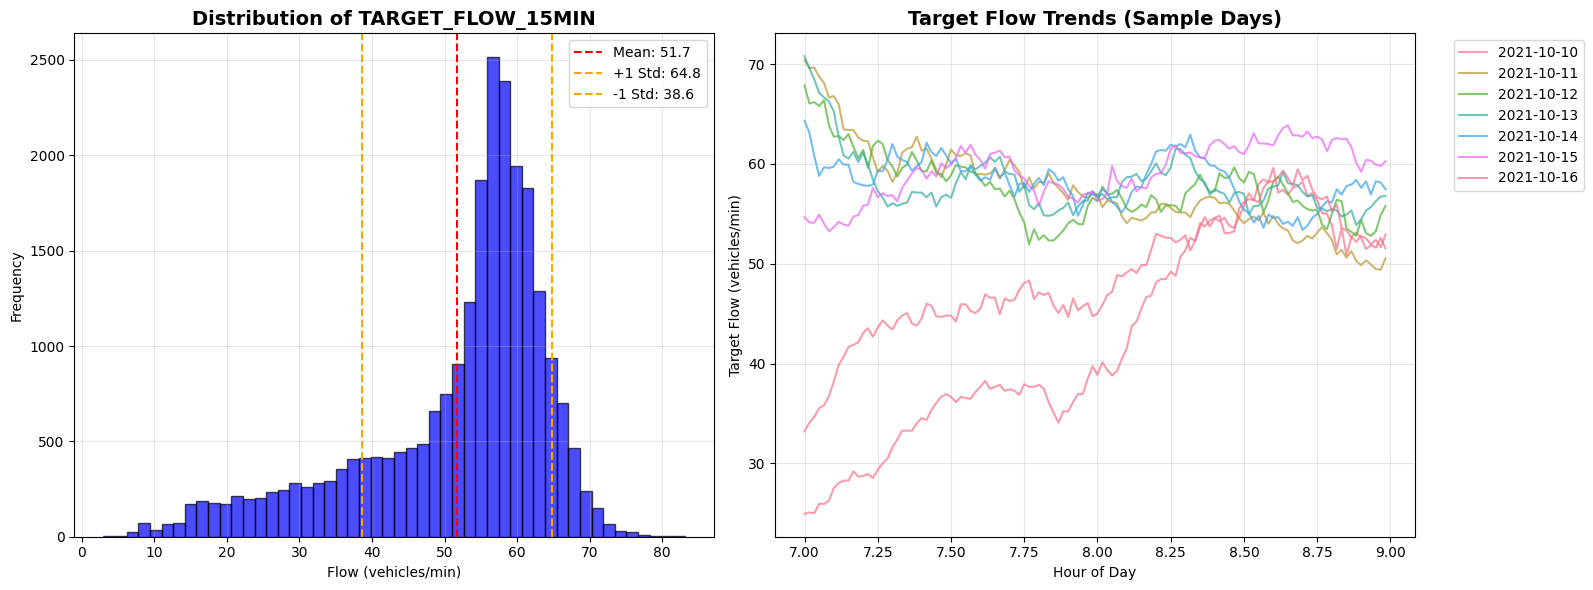

In [29]:
# Analyze target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Target variable distribution
valid_targets = df_morning_peak['TARGET_FLOW_15MIN'].dropna()
axes[0].hist(valid_targets, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Distribution of TARGET_FLOW_15MIN', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Flow (vehicles/min)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Add statistics
mean_target = valid_targets.mean()
std_target = valid_targets.std()
axes[0].axvline(mean_target, color='red', linestyle='--', label=f'Mean: {mean_target:.1f}')
axes[0].axvline(mean_target + std_target, color='orange', linestyle='--', label=f'+1 Std: {mean_target + std_target:.1f}')
axes[0].axvline(mean_target - std_target, color='orange', linestyle='--', label=f'-1 Std: {mean_target - std_target:.1f}')
axes[0].legend()

# 4. Target variable trends over time
# Sample some days for visualization
sample_dates = df_morning_peak['DateTime'].dt.date.unique()[127:134]  # First 7 days
sample_data = df_morning_peak[df_morning_peak['DateTime'].dt.date.isin(sample_dates)]

for i, date in enumerate(sample_dates):
    day_data = sample_data[sample_data['DateTime'].dt.date == date]
    axes[1].plot(day_data['DateTime'].dt.hour + day_data['DateTime'].dt.minute/60, 
                   day_data['TARGET_FLOW_15MIN'], alpha=0.7, label=str(date))

axes[1].set_title('Target Flow Trends (Sample Days)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Target Flow (vehicles/min)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2. Feature Correlation Analysis

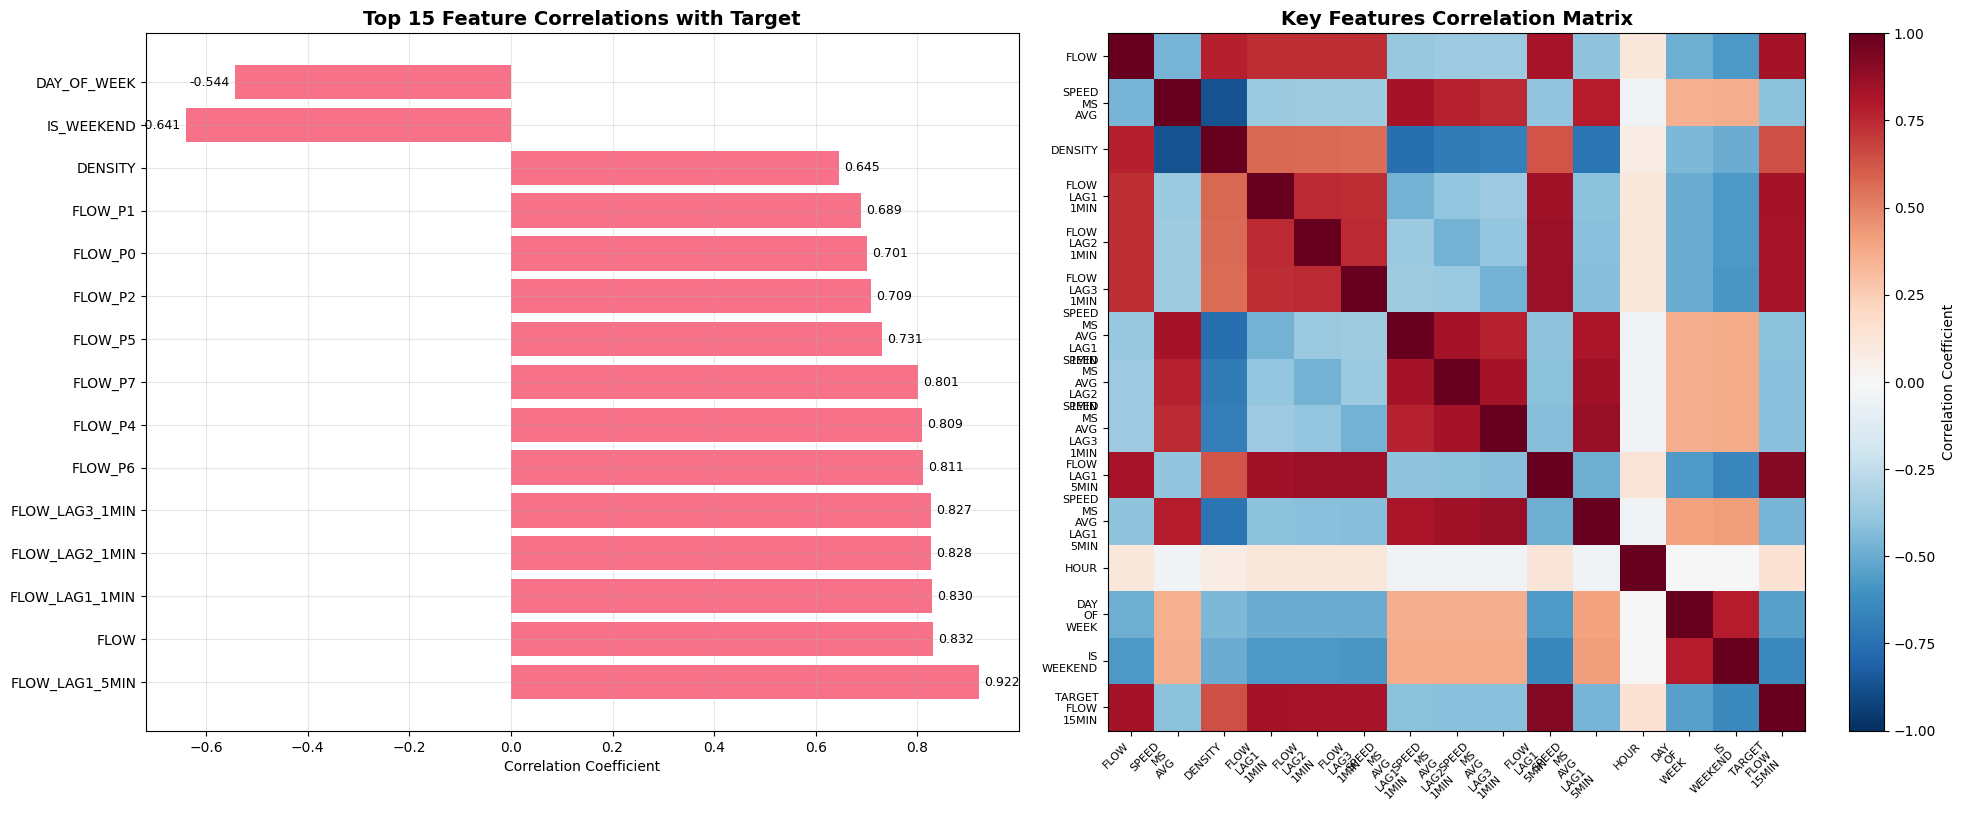

In [32]:
# Correlation analysis with target variable
# Select key features for correlation analysis
key_features = [
    'FLOW', 'SPEED_MS_AVG', 'DENSITY', 'FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN', 'FLOW_LAG3_1MIN',
    'SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN', 'SPEED_MS_AVG_LAG3_1MIN',
    'FLOW_LAG1_5MIN', 'SPEED_MS_AVG_LAG1_5MIN', 'HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND', 'TARGET_FLOW_15MIN'
]

# Add portal features from other portals
portal_features = []
for i in [0, 1, 2, 4, 5, 6, 7]:  # Other portals
    portal_features.extend([f'FLOW_P{i}', f'SPEED_MS_AVG_P{i}'])

# Select available features
available_features = [f for f in key_features + portal_features if f in df_morning_peak.columns]
correlation_data = df_morning_peak[available_features].corr()

# Plot correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Correlation with target variable
target_corrs = correlation_data['TARGET_FLOW_15MIN'].drop('TARGET_FLOW_15MIN').sort_values(key=abs, ascending=False)
top_features = target_corrs.head(15)

axes[0].barh(range(len(top_features)), top_features.values)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features.index, fontsize=10)
axes[0].set_title('Top 15 Feature Correlations with Target', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].grid(True, alpha=0.3)

# Add correlation values as text
for i, v in enumerate(top_features.values):
    axes[0].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
                 va='center', ha='left' if v > 0 else 'right', fontsize=9)

# 2. Correlation matrix for key features
key_features_available = [f for f in key_features if f in df_morning_peak.columns]
if len(key_features_available) > 1:
    key_correlation_matrix = df_morning_peak[key_features_available].corr()

    im = axes[1].imshow(key_correlation_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1].set_title('Key Features Correlation Matrix', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(key_features_available)))
    axes[1].set_yticks(range(len(key_features_available)))
    axes[1].set_xticklabels([f.replace('_', '\n') for f in key_features_available], rotation=45, ha='right', fontsize=8)
    axes[1].set_yticklabels([f.replace('_', '\n') for f in key_features_available], fontsize=8)
    
    # Add colorbar
    plt.colorbar(im, ax=axes[1], label='Correlation Coefficient')

plt.tight_layout()
plt.show()

## E. Model Development and Evaluation

### 1. Data Preparation and Feature Selection

In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the dataset for modeling
print("Preparing data for machine learning models...")

# Remove rows with missing target values
df_model = df_morning_peak.dropna(subset=['TARGET_FLOW_15MIN']).copy()
print(f"Dataset size after removing missing targets: {len(df_model)}")

del df_morning_peak 

# Define feature categories for selection
feature_categories = {
    'basic_traffic': ['FLOW', 'SPEED_MS_AVG', 'DENSITY', 'NUM_LANES'],
    'temporal_lags': [col for col in df_model.columns if 'LAG' in col and not any(f'_P{i}' in col for i in range(8))],
    'portal_features': [col for col in df_model.columns if any(f'_P{i}' in col for i in range(8))],
    'temporal_context': ['HOUR', 'MINUTE_OF_HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND',
                        'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'DOW_SIN', 'DOW_COS'],
    'macroscopic': [col for col in df_model.columns if any(x in col for x in ['DENSITY_RATIO', 'FLOW_RATIO', 'BREAKDOWN', 'RECOVERY'])]
}

# Select features based on correlation and domain knowledge
selected_features = []

# Add high-correlation features
correlation_threshold = 0.1
if 'TARGET_FLOW_15MIN' in df_model.columns:
    numeric_cols = df_model.select_dtypes(include=[np.number]).columns
    target_correlations = df_model[numeric_cols].corr()['TARGET_FLOW_15MIN'].abs()
    high_corr_features = target_correlations[target_correlations > correlation_threshold].index.tolist()
    high_corr_features.remove('TARGET_FLOW_15MIN')
    selected_features.extend(high_corr_features)

# Mutual information-based selection (example with a threshold)
from sklearn.feature_selection import mutual_info_regression
X_temp = df_model[selected_features].fillna(0)
y_temp = df_model['TARGET_FLOW_15MIN']
mi_scores = mutual_info_regression(X_temp, y_temp)
mi_threshold = 0.4
mi_features = [feature for feature, score in zip(selected_features, mi_scores) if score > mi_threshold]
selected_features = mi_features

# Add important domain-specific features
important_features = ['FLOW', 'SPEED_MS_AVG', 'HOUR', 'DAY_OF_WEEK']
for feature in important_features:
    if feature in df_model.columns and feature not in selected_features:
        selected_features.append(feature)

# Remove duplicates and ensure all features exist
selected_features = list(set(selected_features))
selected_features = [f for f in selected_features if f in df_model.columns]

print(f"Selected {len(selected_features)} features for modeling")
print("Selected features:", selected_features[:10], "..." if len(selected_features) > 10 else "")

nb_total = len(df_model)
nb_after_drop = len(df_model.dropna())
del_proportion = (nb_total - nb_after_drop) / nb_total

print(f"Lines with nan proportion: {del_proportion:.2%}")

df_model = df_model.dropna(subset=selected_features + ['TARGET_FLOW_15MIN']).copy()
print(f"Dataset size after dropping rows with missing feature values: {len(df_model)}")

# Prepare features and target
X = df_model[selected_features].copy()
y = df_model['TARGET_FLOW_15MIN'].copy()

# Handle any remaining missing values
X = X.dropna()

print(f"Final dataset shape: X={X.shape}, y={y.shape}")
print(f"Features with missing values: {X.isnull().sum().sum()}")
print(f"Target missing values: {y.isnull().sum()}") 

Preparing data for machine learning models...
Dataset size after removing missing targets: 24626
Selected 211 features for modeling
Selected features: ['FLOW_LAG3_1MIN', 'SPEED_MS_AVG_LAG2_5MIN_P7', 'FLOW_LAG2_15MIN_P7', 'FLOW_P0', 'FLOW_LAG3_5MIN', 'FLOW_LAG2_5MIN_P4', 'FLOW_LAG3_5MIN_P7', 'FLOW_P6', 'FLOW_RATIO', 'FLOW_LAG2_60MIN_P0'] ...
Lines with nan proportion: 3.29%
Dataset size after dropping rows with missing feature values: 23817
Final dataset shape: X=(23817, 211), y=(23817,)
Features with missing values: 0
Target missing values: 0


In [36]:
# Get all columns except the target
all_columns = [col for col in df_model.columns if col != 'TARGET_FLOW_15MIN']
print(f"Total available features: {len(all_columns)}")

# FEATURE CATEGORIZATION
feature_categories = {

    # 1. METADATA AND IDENTIFIERS (not used for ML)
    'metadata': [
        'PORTAL', 'Date', 'Time', 'DateTime', 
        'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60'
    ],
    
    # 2. BASIC TRAFFIC MEASURES (target portal)
    'traffic_basic': [
        'FLOW', 'SPEED_MS_AVG', 'DENSITY', 'NUM_LANES', 'SPEED_CAPPED'
    ],
    
    # 3. TEMPORAL FEATURES
    'temporal_discrete': [
        'HOUR_OF_DAY', 'MINUTE_OF_HOUR', 'MINUTE_OF_DAY', 'DAY_OF_WEEK', 'MONTH', 'HOUR'
    ],
    'temporal_boolean': [
        'IS_WEEKEND', 'IS_WEEKDAY', 'IS_HOLIDAY'
    ],
    'temporal_cyclic': [
        'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 
        'DOW_SIN', 'DOW_COS', 'MONTH_SIN', 'MONTH_COS'
    ],
    
    # 4. LAG FEATURES (target portal)
    'lags_1min': [col for col in all_columns if 'LAG' in col and '1MIN' in col and not any(f'_P{i}' in col for i in range(8))],
    'lags_5min': [col for col in all_columns if 'LAG' in col and '5MIN' in col and not any(f'_P{i}' in col for i in range(8))],
    'lags_15min': [col for col in all_columns if 'LAG' in col and '15MIN' in col and not any(f'_P{i}' in col for i in range(8))],
    'lags_60min': [col for col in all_columns if 'LAG' in col and '60MIN' in col and not any(f'_P{i}' in col for i in range(8))],
    
    # 5. DERIVED TRAFFIC FEATURES (target portal)
    'traffic_derived': [col for col in all_columns if any(x in col for x in [
        'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'BREAKDOWN_FLAG', 'RECOVERY_FLAG'
    ]) and not any(f'_P{i}' in col for i in range(8))],
    
    # 6. MACROSCOPIC AND THEORETICAL FEATURES
    'macroscopic_ratios': [
        'DENSITY_RATIO', 'FLOW_RATIO', 'PORTAL_ORDER'
    ],
    'macroscopic_theory': [col for col in all_columns if any(x in col for x in [
        'DENSITY_SQUARED', 'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED'
    ]) and not any(f'_P{i}' in col for i in range(8))],
    'capacity_features': [
        'DIST_TO_KC', 'DIST_TO_QC'
    ],
    
    # 7. TRAFFIC STATE FEATURES (target portal)
    'traffic_states': [col for col in all_columns if any(x in col for x in [
        'IS_CONGESTED', 'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE'
    ]) and not any(f'_P{i}' in col for i in range(8))],
    
    # 8. SPATIAL AND NETWORK FEATURES
    'spatial_demand_supply': [
        'UPSTREAM_DEMAND', 'DOWNSTREAM_SUPPLY', 'REALIZED_FLOW', 'DEMAND_SUPPLY_RATIO'
    ],
    'spatial_gradients': [
        'FLOW_GRADIENT', 'SPEED_GRADIENT', 'DENSITY_GRADIENT'
    ],
    
    # 9. CONGESTION AND QUEUE FEATURES
    'congestion_queue': [
        'QUEUE_LENGTH', 'QUEUE_PENETRATION', 'CONGESTION_FRONT', 'QUEUE_GROWTH_RATE'
    ],
    'congestion_timing': [
        'TIME_SINCE_CONGESTION_START', 'TIME_SINCE_CONGESTION_END'
    ],
    
    # 10. NEIGHBORING PORTAL FEATURES (P0–P7)
    # Basic measures per portal
    'portal_p0_basic': [col for col in all_columns if '_P0' in col and any(x in col for x in ['FLOW_P0', 'SPEED_MS_AVG_P0', 'DENSITY_P0', 'NUM_LANES_P0'])],
    'portal_p1_basic': [col for col in all_columns if '_P1' in col and any(x in col for x in ['FLOW_P1', 'SPEED_MS_AVG_P1', 'DENSITY_P1', 'NUM_LANES_P1'])],
    'portal_p2_basic': [col for col in all_columns if '_P2' in col and any(x in col for x in ['FLOW_P2', 'SPEED_MS_AVG_P2', 'DENSITY_P2', 'NUM_LANES_P2'])],
    'portal_p4_basic': [col for col in all_columns if '_P4' in col and any(x in col for x in ['FLOW_P4', 'SPEED_MS_AVG_P4', 'DENSITY_P4', 'NUM_LANES_P4'])],
    'portal_p5_basic': [col for col in all_columns if '_P5' in col and any(x in col for x in ['FLOW_P5', 'SPEED_MS_AVG_P5', 'DENSITY_P5', 'NUM_LANES_P5'])],
    'portal_p6_basic': [col for col in all_columns if '_P6' in col and any(x in col for x in ['FLOW_P6', 'SPEED_MS_AVG_P6', 'DENSITY_P6', 'NUM_LANES_P6'])],
    'portal_p7_basic': [col for col in all_columns if '_P7' in col and any(x in col for x in ['FLOW_P7', 'SPEED_MS_AVG_P7', 'DENSITY_P7', 'NUM_LANES_P7'])],
    
    # Lags per portal
    'portal_p0_lags': [col for col in all_columns if '_P0' in col and 'LAG' in col],
    'portal_p1_lags': [col for col in all_columns if '_P1' in col and 'LAG' in col],
    'portal_p2_lags': [col for col in all_columns if '_P2' in col and 'LAG' in col],
    'portal_p4_lags': [col for col in all_columns if '_P4' in col and 'LAG' in col],
    'portal_p5_lags': [col for col in all_columns if '_P5' in col and 'LAG' in col],
    'portal_p6_lags': [col for col in all_columns if '_P6' in col and 'LAG' in col],
    'portal_p7_lags': [col for col in all_columns if '_P7' in col and 'LAG' in col],
    
    # Derived features per portal
    'portal_p0_derived': [col for col in all_columns if '_P0' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P0'
    ])],
    'portal_p1_derived': [col for col in all_columns if '_P1' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P1'
    ])],
    'portal_p2_derived': [col for col in all_columns if '_P2' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P2'
    ])],
    'portal_p4_derived': [col for col in all_columns if '_P4' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P4'
    ])],
    'portal_p5_derived': [col for col in all_columns if '_P5' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P5'
    ])],
    'portal_p6_derived': [col for col in all_columns if '_P6' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P6'
    ])],
    'portal_p7_derived': [col for col in all_columns if '_P7' in col and any(x in col for x in [
        'BREAKDOWN_FLAG', 'SPEED_CHANGE', 'SPEED_TREND', 'FLOW_TREND', 'DENSITY_SQUARED', 
        'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 
        'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE', 'FLOW_RATIO_P7'
    ])]
}

# Clean categories: remove duplicates and ensure valid features
seen_features = set()
feature_categories_clean = {}

for category, features in feature_categories.items():
    clean_features = []
    for feature in features:
        if feature in all_columns and feature not in seen_features:
            clean_features.append(feature)
            seen_features.add(feature)
    
    if clean_features:  # Keep only non-empty categories
        feature_categories_clean[category] = clean_features

# Display results
print("\n=== CLEANED CATEGORIES ===")
total_categorized = 0
for category, features in feature_categories_clean.items():
    count = len(features)
    total_categorized += count
    print(f"{category:<25}: {count:>3} features")

print(f"\n{'='*50}")
print(f"Total categorized features: {total_categorized}")
print(f"Total available features:  {len(all_columns)}")

# Find uncategorized features
uncategorized = [f for f in all_columns if f not in seen_features]
if uncategorized:
    print(f"Uncategorized features:   {len(uncategorized)}")
    print("Examples:", uncategorized[:5])
else:
    print("All features are categorized!")

# Update global variable
feature_categories = feature_categories_clean.copy()
print(f"\n feature_categories updated with {len(feature_categories)} categories")


Total available features: 366

=== CLEANED CATEGORIES ===
metadata                 :   9 features
traffic_basic            :   5 features
temporal_discrete        :   5 features
temporal_boolean         :   3 features
temporal_cyclic          :   8 features
lags_1min                :  10 features
lags_5min                :  10 features
lags_60min               :   4 features
traffic_derived          :   5 features
macroscopic_ratios       :   3 features
macroscopic_theory       :   5 features
capacity_features        :   2 features
traffic_states           :   4 features
spatial_demand_supply    :   4 features
spatial_gradients        :   3 features
congestion_queue         :   4 features
congestion_timing        :   2 features
portal_p0_basic          :   7 features
portal_p1_basic          :   7 features
portal_p2_basic          :   7 features
portal_p4_basic          :   7 features
portal_p5_basic          :   7 features
portal_p6_basic          :   7 features
portal_p7_basic       

In [ ]:
print("=== ADAPTED FEATURE SELECTION STRATEGY EVALUATION ===")

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import time
import warnings
warnings.filterwarnings('ignore')

# Data preparation
print("Preparing data...")

# Ensure df_model and features are available
df_model = df_morning_peak.dropna(subset=['TARGET_FLOW_15MIN']).copy()

# Build strategies using the new categorization
print("\nBuilding strategies based on new categorization...")

# DEFINE EVALUATION STRATEGIES
evaluation_strategies = {
    # Minimal strategy - only essential features
    'minimal_essential': (
        feature_categories.get('traffic_basic', []) + 
        feature_categories.get('temporal_discrete', [])[:3] +  # Top 3 temporal
        feature_categories.get('lags_1min', [])[:3] +           # Top 3 1-min lags
        feature_categories.get('lags_5min', [])[:3]             # Top 3 5-min lags
    ),
    
    # Temporal strategy - focus on lags
    'temporal_focused': (
        feature_categories.get('traffic_basic', []) + 
        feature_categories.get('temporal_discrete', []) +
        feature_categories.get('lags_1min', []) + 
        feature_categories.get('lags_5min', [])
    ),
    
    # Spatial strategy - upstream portals
    'spatial_upstream': (
        feature_categories.get('traffic_basic', []) + 
        feature_categories.get('temporal_discrete', [])[:4] +
        feature_categories.get('lags_1min', [])[:5] +
        feature_categories.get('portal_p6_basic', []) + 
        feature_categories.get('portal_p7_basic', []) +
        feature_categories.get('portal_p6_lags', [])[:10] +
        feature_categories.get('portal_p7_lags', [])[:10]
    ),
    
    # Theory-based strategy - grounded in traffic theory
    'theory_based': (
        feature_categories.get('traffic_basic', []) + 
        feature_categories.get('macroscopic_ratios', []) +
        feature_categories.get('macroscopic_theory', []) +
        feature_categories.get('capacity_features', []) +
        feature_categories.get('traffic_states', []) +
        feature_categories.get('lags_1min', [])[:5] +
        feature_categories.get('temporal_discrete', [])[:4]
    ),
    
    # Balanced strategy - good trade-off
    'balanced_approach': (
        feature_categories.get('traffic_basic', []) + 
        feature_categories.get('temporal_discrete', []) +
        feature_categories.get('lags_1min', [])[:6] + 
        feature_categories.get('lags_5min', [])[:6] +
        feature_categories.get('portal_p6_basic', []) + 
        feature_categories.get('portal_p7_basic', []) +
        feature_categories.get('portal_p4_basic', []) +
        feature_categories.get('macroscopic_ratios', []) +
        feature_categories.get('spatial_demand_supply', [])[:2]
    ),
    
    # Comprehensive strategy - many features (risk of overfitting)
    'comprehensive': (
        feature_categories.get('traffic_basic', []) + 
        feature_categories.get('temporal_discrete', []) +
        feature_categories.get('temporal_boolean', []) +
        feature_categories.get('lags_1min', []) + 
        feature_categories.get('lags_5min', []) +
        feature_categories.get('lags_15min', [])[:3] +
        feature_categories.get('portal_p6_basic', []) + 
        feature_categories.get('portal_p7_basic', []) +
        feature_categories.get('portal_p4_basic', []) +
        feature_categories.get('portal_p6_lags', [])[:15] +
        feature_categories.get('portal_p7_lags', [])[:15] +
        feature_categories.get('macroscopic_ratios', []) +
        feature_categories.get('spatial_demand_supply', [])
    )
}

# Clean strategies: remove duplicates and invalid features
print("Cleaning strategies...")
cleaned_strategies = {}
for strategy_name, features in evaluation_strategies.items():
    clean_features = list(set([f for f in features if f in df_model.columns and f != 'TARGET_FLOW_15MIN']))
    if len(clean_features) > 0:
        cleaned_strategies[strategy_name] = clean_features
        print(f"  {strategy_name}: {len(clean_features)} features")

# Prepare evaluation data
print("\nPreparing evaluation dataset...")

# Use a sample to speed up the evaluation if needed
sample_size = min(10000, len(df_model))  # Limit to 10k samples max
df_eval = df_model.sample(n=sample_size, random_state=42) if len(df_model) > sample_size else df_model.copy()

y_eval = df_eval['TARGET_FLOW_15MIN'].copy()
print(f"Evaluation sample: {len(df_eval)} rows")

# Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=3)
quick_model = GradientBoostingRegressor(n_estimators=30, max_depth=6, random_state=42)


evaluation_results = {}

for strategy_name, features in cleaned_strategies.items():
    print(f"\nEvaluating: {strategy_name} ({len(features)} features)")
    # Prepare data for this strategy
    X_strategy = df_eval[features].copy()
    # Handle missing values
    X_strategy = X_strategy.fillna(X_strategy.median())
        
        
    # Cross-validation
    start_time = time.time()
    cv_scores = cross_val_score(
        quick_model, X_strategy, y_eval, 
        cv=tscv, scoring='neg_mean_absolute_error', 
        n_jobs=1
    )
    end_time = time.time()
        
    evaluation_results[strategy_name] = {
            'n_features': len(features),
            'cv_mae_mean': -cv_scores.mean(),
            'cv_mae_std': cv_scores.std(),
            'training_time': end_time - start_time,
            'features': features,
            'cv_scores': cv_scores
        }
        
    print(f"  CV MAE: {-cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Time: {end_time - start_time:.1f}s")
        

# RESULTS AND COMPARISON
if evaluation_results:
    print(f"\n{'='*60}")
    print("EVALUATION RESULTS")
    print(f"{'='*60}")
    
    results_df = pd.DataFrame({
        strategy: {
            'N_Features': results['n_features'],
            'CV_MAE': results['cv_mae_mean'],
            'CV_STD': results['cv_mae_std'],
            'Time_s': results['training_time'],
            'Efficiency': results['cv_mae_mean'] / results['n_features']  # MAE per feature
        }
        for strategy, results in evaluation_results.items()
    }).T
    
    results_df = results_df.sort_values('CV_MAE')
    
    print(results_df.round(4))
    
    # Identify best strategy
    best_strategy = results_df.index[0]
    best_features = evaluation_results[best_strategy]['features']
    
    print(f"\nBEST STRATEGY: {best_strategy}")
    print(f"   Features: {len(best_features)}")
    print(f"   CV MAE: {evaluation_results[best_strategy]['cv_mae_mean']:.4f}")
    print(f"   Efficiency: {results_df.loc[best_strategy, 'Efficiency']:.6f} MAE/feature")
    
    # Update global variables
    actual_features_used = best_features.copy()
    selected_features_improved = best_features.copy()
    selected_features = best_features.copy()
    
    print(f"\nGlobal variables updated with {len(best_features)} optimal features")
    print(f"Strategy '{best_strategy}' selected for next steps")
    
else:
    print("\nNo evaluation results to display.")


=== ADAPTED FEATURE SELECTION STRATEGY EVALUATION ===
Preparing data...

Building strategies based on new categorization...
Cleaning strategies...
  minimal_essential: 14 features
  temporal_focused: 30 features
  spatial_upstream: 48 features
  theory_based: 28 features
  balanced_approach: 48 features
  comprehensive: 91 features

Preparing evaluation dataset...
Evaluation sample: 10000 rows

Evaluating: minimal_essential (14 features)
  CV MAE: 2.662 ± 0.041
  Time: 1.4s

Evaluating: temporal_focused (30 features)
  CV MAE: 2.479 ± 0.060
  Time: 3.7s

Evaluating: spatial_upstream (48 features)
  CV MAE: 2.961 ± 0.044
  Time: 5.2s

Evaluating: theory_based (28 features)
  CV MAE: 3.011 ± 0.028
  Time: 2.9s

Evaluating: balanced_approach (48 features)
  CV MAE: 2.616 ± 0.065
  Time: 5.1s

Evaluating: comprehensive (91 features)
  CV MAE: 2.460 ± 0.069
  Time: 9.7s

EVALUATION RESULTS
                   N_Features  CV_MAE  CV_STD  Time_s  Efficiency
comprehensive            91.0  2.460

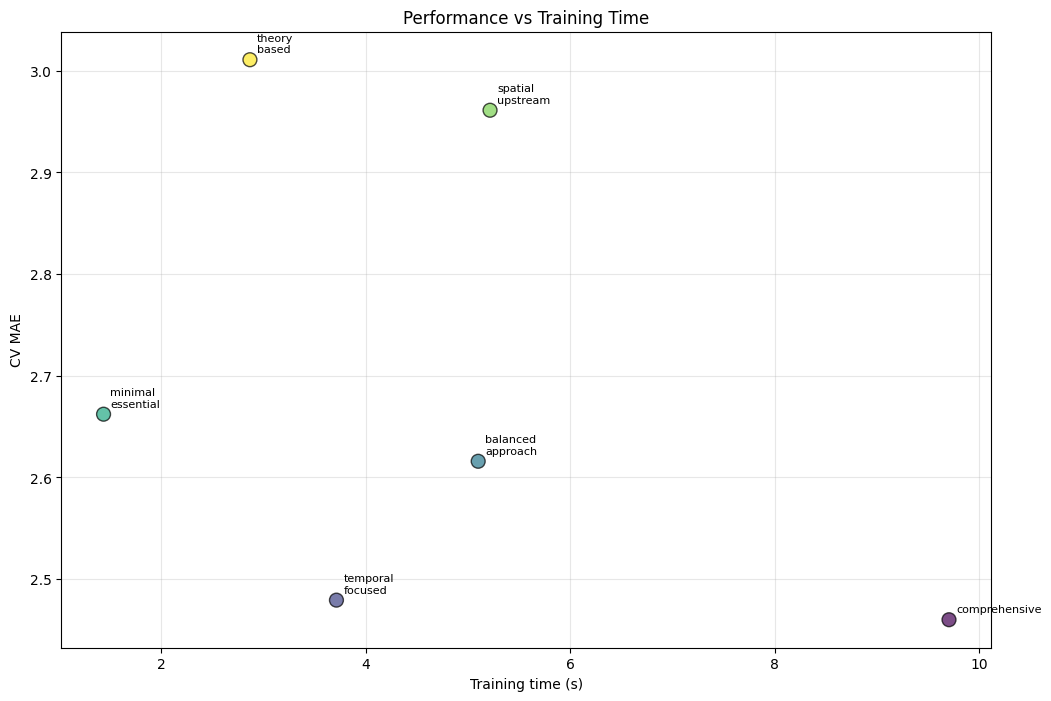

In [52]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(results_df['Time_s'], results_df['CV_MAE'], 
               c=colors, s=100, alpha=0.7, edgecolors='black')
    
for i, (idx, row) in enumerate(results_df.iterrows()):
    plt.annotate(idx.replace('_', '\n'), 
                 (row['Time_s'], row['CV_MAE']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, ha='left')

plt.xlabel('Training time (s)')
plt.ylabel('CV MAE')
plt.title('Performance vs Training Time')
plt.grid(True, alpha=0.3)




In [53]:
print("=== FINAL FEATURE SELECTION SUMMARY ===")


# Display selected features
print("\nSelected features:")
print(f"Total number: {len(actual_features_used)}")
for i, feature in enumerate(actual_features_used, 1):
    print(f"{i:2d}. {feature}")

# Category distribution
print("\nCategory distribution:")
feature_count_by_category = {}
for feature in actual_features_used:
    for category, cat_features in feature_categories.items():
        if feature in cat_features:
            feature_count_by_category[category] = feature_count_by_category.get(category, 0) + 1
            break
    else:
        feature_count_by_category['uncategorized'] = feature_count_by_category.get('uncategorized', 0) + 1

for category, count in sorted(feature_count_by_category.items()):
    print(f"  {category:<25}: {count} features")

# Add important domain-specific features if missing
important_features = ['FLOW', 'SPEED_MS_AVG', 'HOUR', 'DAY_OF_WEEK']
for feature in important_features:
    if feature in df_model.columns and feature not in actual_features_used:
        actual_features_used.append(feature)

# Remove duplicates and ensure all features exist in the dataset
selected_features = list(dict.fromkeys([f for f in actual_features_used if f in df_model.columns]))

print(f"\nFinal feature count: {len(selected_features)}")
print("Sample of selected features:", selected_features[:10], "..." if len(selected_features) > 10 else "")

# Check NaN proportion before cleaning
nb_total = len(df_model)
nb_after_drop = len(df_model.dropna())
del_proportion = (nb_total - nb_after_drop) / nb_total
print(f"\nProportion of rows with NaN values: {del_proportion:.2%}")

# Drop rows with missing values in selected features or target
df_model = df_model.dropna(subset=selected_features + ['TARGET_FLOW_15MIN']).copy()
print(f"Dataset size after cleaning: {len(df_model)} rows")

# Prepare features and target
X = df_model[selected_features].copy()
y = df_model['TARGET_FLOW_15MIN'].copy()

# Handle any remaining missing values
X = X.dropna()

print(f"\nFinal dataset shapes:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")
print(f"  Missing values in features: {X.isnull().sum().sum()}")
print(f"  Missing values in target: {y.isnull().sum()}")


=== FINAL FEATURE SELECTION SUMMARY ===

Selected features:
Total number: 91
 1. FLOW_LAG3_1MIN
 2. SPEED_MS_AVG_LAG2_5MIN_P7
 3. FLOW_LAG3_5MIN
 4. SPEED_MS_AVG_LAG3_1MIN_P6
 5. FLOW_LAG3_5MIN_P7
 6. FLOW_P6
 7. MONTH
 8. FLOW_RATIO
 9. FLOW_DENSITY_P4
10. SPEED_CAPPED
11. SPEED_MS_AVG_LAG1_5MIN_P7
12. SPEED_MS_AVG_P7
13. FLOW_LAG1_1MIN_P6
14. IS_WEEKDAY
15. DENSITY_RATIO
16. SPEED_MS_AVG_LAG1_1MIN
17. SPEED_MS_AVG_LAG1_1MIN_P6
18. BREAKDOWN_FLAG_P6
19. IS_FREE_FLOW_P4
20. MINUTE_OF_DAY
21. NUM_LANES_P7
22. SPEED_MS_AVG_LAG2_5MIN
23. FLOW_LAG4_1MIN_P6
24. NUM_LANES
25. FLOW_LAG4_1MIN_P7
26. UPSTREAM_DEMAND
27. NUM_LANES_P4
28. SPEED_MS_AVG_LAG3_1MIN
29. FLOW_LAG2_5MIN_P6
30. FLOW_LAG1_5MIN
31. SPEED_DENSITY_P4
32. SPEED_MS_AVG_LAG3_5MIN_P7
33. HOUR
34. SPEED_MS_AVG_LAG4_1MIN
35. IS_HOLIDAY
36. FLOW_P4
37. IS_WEEKEND
38. FLOW_DENSITY_P7
39. SPEED_MS_AVG_LAG3_5MIN_P6
40. FLOW_LAG2_1MIN_P7
41. SPEED_MS_AVG_LAG2_1MIN_P6
42. FLOW_LAG2_15MIN
43. SPEED_MS_AVG_LAG3_1MIN_P7
44. FLOW_LAG3_1MIN_

### 2. Train-Test Split and Data Scaling

In [60]:
# Time-aware train-test split for time series data
# Sort by datetime to maintain temporal order
if 'DateTime' in df_model.columns:
    df_model_sorted = df_model.sort_values('DateTime')
    X_sorted = df_model_sorted[selected_features]
    y_sorted = df_model_sorted['TARGET_FLOW_15MIN']
    
    # Use temporal split: 80% for training, 20% for testing
    split_idx = int(0.8 * len(X_sorted))
    X_train, X_test = X_sorted[:split_idx], X_sorted[split_idx:]
    y_train, y_test = y_sorted[:split_idx], y_sorted[split_idx:]
    
    print(f"Temporal split - Train: {len(X_train)}, Test: {len(X_test)}")
    
    if 'DateTime' in df_model_sorted.columns:
        train_period = df_model_sorted.iloc[:split_idx]['DateTime']
        test_period = df_model_sorted.iloc[split_idx:]['DateTime']
        print(f"Training period: {train_period.min()} to {train_period.max()}")
        print(f"Testing period: {test_period.min()} to {test_period.max()}")
else:
    # Fallback to random split if DateTime not available
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Random split - Train: {len(X_train)}, Test: {len(X_test)}")

# Further split training data for validation
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Final splits - Train: {len(X_train_final)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Temporal split - Train: 19502, Test: 4876
Training period: 2021-06-01 07:00:00 to 2021-11-20 07:38:00
Testing period: 2021-11-20 07:39:00 to 2021-12-31 08:59:00
Final splits - Train: 15601, Validation: 3901, Test: 4876


### 3. Model Selection and Training

In [61]:
# Baseline model: Same as last known value

def baseline_model(X_test):
    """Baseline model predicting the last known target value"""
    y_pred = X_test['FLOW'].rolling(window=15).mean()
    return y_pred

y_pred_baseline = baseline_model(X_test)
print("Baseline model predictions completed")

# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

calculate_metrics(y_test[15:], y_pred_baseline[15:])

Baseline model predictions completed


{'MAE': 4.186894195657825,
 'RMSE': 6.424190016997266,
 'MAPE': 13.638920507838986,
 'R²': 0.8728391363652752}

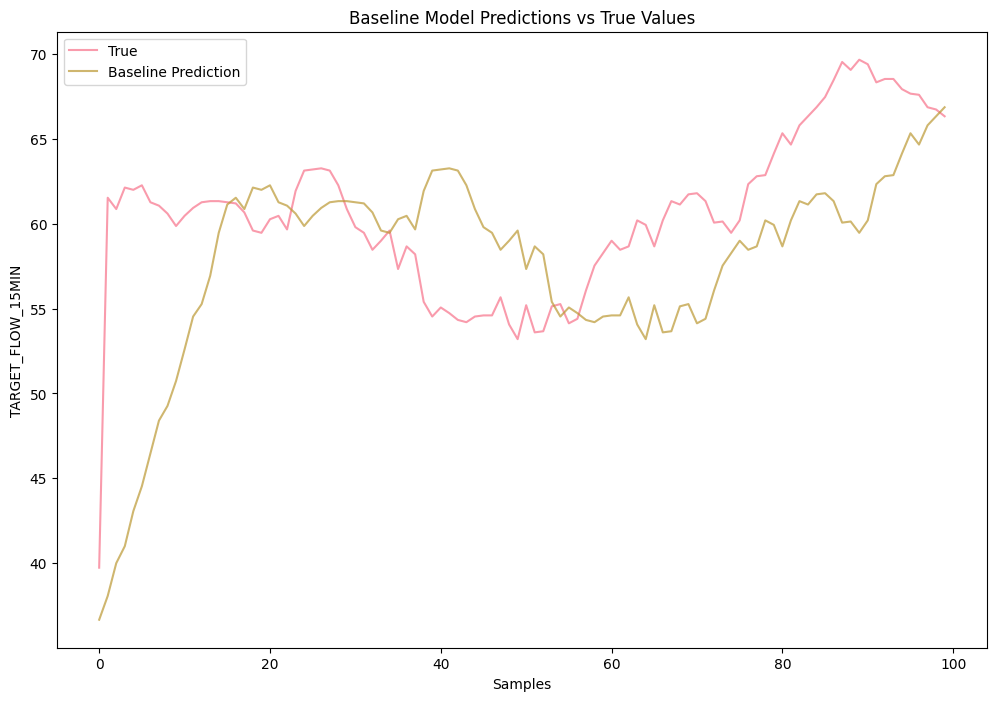

In [62]:
plt.plot(y_test.values[200:300], label='True', alpha=0.7)
plt.plot(y_pred_baseline.values[200:300], label='Baseline Prediction', alpha=0.7)
plt.title('Baseline Model Predictions vs True Values')
plt.xlabel('Samples')
plt.ylabel('TARGET_FLOW_15MIN')
plt.legend()
plt.show()

In [ ]:
# Initialize models dictionary to store results
models_results = {}

print("Training and evaluating machine learning models...")
print("=" * 60)

# 1. LINEAR REGRESSION MODEL
print("1. Training Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train_final)

# Predictions
y_pred_lr_train = lr_model.predict(X_train_final)
y_pred_lr_val = lr_model.predict(X_val)
y_pred_lr_test = lr_model.predict(X_test)

# Evaluate
lr_metrics = {
    'train': calculate_metrics(y_train_final, y_pred_lr_train),
    'validation': calculate_metrics(y_val, y_pred_lr_val),
    'test': calculate_metrics(y_test, y_pred_lr_test),
    'feature_importance': lr_model.coef_.tolist()
}

models_results['Linear Regression'] = {
    'model': lr_model,
    'metrics': lr_metrics,
    'predictions': {'test': y_pred_lr_test}
}
print(f"   Train MAE: {lr_metrics['train']['MAE']:.3f}, RMSE: {lr_metrics['train']['RMSE']:.3f}, R²: {lr_metrics['train']['R²']:.3f}")
print(f"   Test MAE: {lr_metrics['test']['MAE']:.3f}, RMSE: {lr_metrics['test']['RMSE']:.3f}, R²: {lr_metrics['test']['R²']:.3f}")
print(f"   Validation MAE: {lr_metrics['validation']['MAE']:.3f}, RMSE: {lr_metrics['validation']['RMSE']:.3f}, R²: {lr_metrics['validation']['R²']:.3f}")
# 2. RANDOM FOREST MODEL
print("2. Training Random Forest Model...")
rf_model = model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42
)
rf_model.fit(X_train_final, y_train_final)

# Predictions
y_pred_rf_train = rf_model.predict(X_train_final)
y_pred_rf_val = rf_model.predict(X_val)
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate
rf_metrics = {
    'train': calculate_metrics(y_train_final, y_pred_rf_train),
    'validation': calculate_metrics(y_val, y_pred_rf_val),
    'test': calculate_metrics(y_test, y_pred_rf_test),
}

rf_feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

models_results['Random Forest'] = {
    'model': rf_model,
    'metrics': rf_metrics,
    'predictions': {'test': y_pred_rf_test},
    'feature_importance': rf_feature_importance
}
print(f"   Train MAE: {rf_metrics['train']['MAE']:.3f}, RMSE: {rf_metrics['train']['RMSE']:.3f}, R²: {rf_metrics['train']['R²']:.3f}")
print(f"   Test MAE: {rf_metrics['test']['MAE']:.3f}, RMSE: {rf_metrics['test']['RMSE']:.3f}, R²: {rf_metrics['test']['R²']:.3f}")
print(f"   Validation MAE: {rf_metrics['validation']['MAE']:.3f}, RMSE: {rf_metrics['validation']['RMSE']:.3f}, R²: {rf_metrics['validation']['R²']:.3f}")

# 3. GRADIENT BOOSTING MODEL
print("3. Training Gradient Boosting Model...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_final, y_train_final)

# Predictions
y_pred_gb_train = gb_model.predict(X_train_final)
y_pred_gb_val = gb_model.predict(X_val)
y_pred_gb_test = gb_model.predict(X_test)

# Evaluate
gb_metrics = {
    'train': calculate_metrics(y_train_final, y_pred_gb_train),
    'validation': calculate_metrics(y_val, y_pred_gb_val),
    'test': calculate_metrics(y_test, y_pred_gb_test)
}

# Get feature importance
gb_feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

models_results['Gradient Boosting'] = {
    'model': gb_model,
    'metrics': gb_metrics,
    'predictions': {'test': y_pred_gb_test},
    'feature_importance': gb_feature_importance
}
print(f"   Train MAE: {gb_metrics['train']['MAE']:.3f}, RMSE: {gb_metrics['train']['RMSE']:.3f}, R²: {gb_metrics['train']['R²']:.3f}")
print(f"   Test MAE: {gb_metrics['test']['MAE']:.3f}, RMSE: {gb_metrics['test']['RMSE']:.3f}, R²: {gb_metrics['test']['R²']:.3f}")
print(f"   Validation MAE: {gb_metrics['validation']['MAE']:.3f}, RMSE: {gb_metrics['validation']['RMSE']:.3f}, R²: {gb_metrics['validation']['R²']:.3f}")
# 4. NEURAL NETWORK (MLP)
print("4. Training Multi-Layer Perceptron...")
X_train_scaled = StandardScaler().fit_transform(X_train_final)
X_val_scaled = StandardScaler().fit_transform(X_val)
X_test_scaled = StandardScaler().fit_transform(X_test)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train_final)

# Predictions
y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_val = mlp_model.predict(X_val_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)

# Evaluate
mlp_metrics = {
    'train': calculate_metrics(y_train_final, y_pred_mlp_train),
    'validation': calculate_metrics(y_val, y_pred_mlp_val),
    'test': calculate_metrics(y_test, y_pred_mlp_test)
}

models_results['MLP Neural Network'] = {
    'model': mlp_model,
    'metrics': mlp_metrics,
    'predictions': {'test': y_pred_mlp_test},
    'feature_importance': None 
}

print(f"   Test MAE: {mlp_metrics['test']['MAE']:.3f}, RMSE: {mlp_metrics['test']['RMSE']:.3f}, R²: {mlp_metrics['test']['R²']:.3f}")

print("\nModel training completed!")
print(f"Total models trained: {len(models_results)}")

Training and evaluating machine learning models...
1. Training Linear Regression Model...
   Train MAE: 2.858, RMSE: 3.863, R²: 0.870
   Test MAE: 3.167, RMSE: 4.555, R²: 0.936
   Validation MAE: 2.919, RMSE: 3.956, R²: 0.869
2. Training Random Forest Model...
   Train MAE: 2.042, RMSE: 2.715, R²: 0.936
   Test MAE: 3.349, RMSE: 4.597, R²: 0.935
   Validation MAE: 2.295, RMSE: 3.034, R²: 0.923
3. Training Gradient Boosting Model...
   Train MAE: 2.192, RMSE: 2.892, R²: 0.927
   Test MAE: 3.325, RMSE: 4.606, R²: 0.935
   Validation MAE: 2.279, RMSE: 2.993, R²: 0.925
4. Training Multi-Layer Perceptron...
   Test MAE: 6.716, RMSE: 8.810, R²: 0.761

Model training completed!
Total models trained: 4


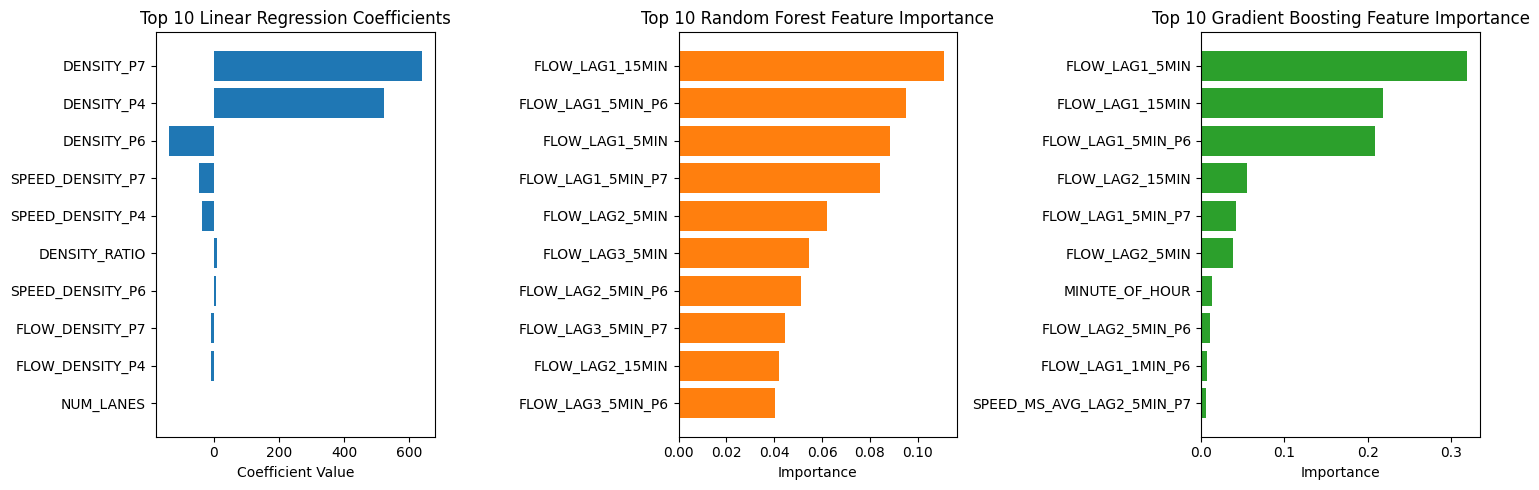

In [64]:
lr_coefficients = pd.DataFrame({
    'feature': selected_features,
    'coefficient': models_results['Linear Regression']['metrics']['feature_importance']
}).sort_values('coefficient', key=abs, ascending=False).head(10)
rf_feature_importance = models_results['Random Forest']['feature_importance'].head(10)
gb_feature_importance = models_results['Gradient Boosting']['feature_importance'].head(10)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.barh(lr_coefficients['feature'], lr_coefficients['coefficient'], color='#1f77b4')
plt.title('Top 10 Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 2)
plt.barh(rf_feature_importance['feature'], rf_feature_importance['importance'], color='#ff7f0e')
plt.title('Top 10 Random Forest Feature Importance')   
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 3)
plt.barh(gb_feature_importance['feature'], gb_feature_importance['importance'], color='#2ca02c')
plt.title('Top 10 Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 5. Model Evaluation and Comparison

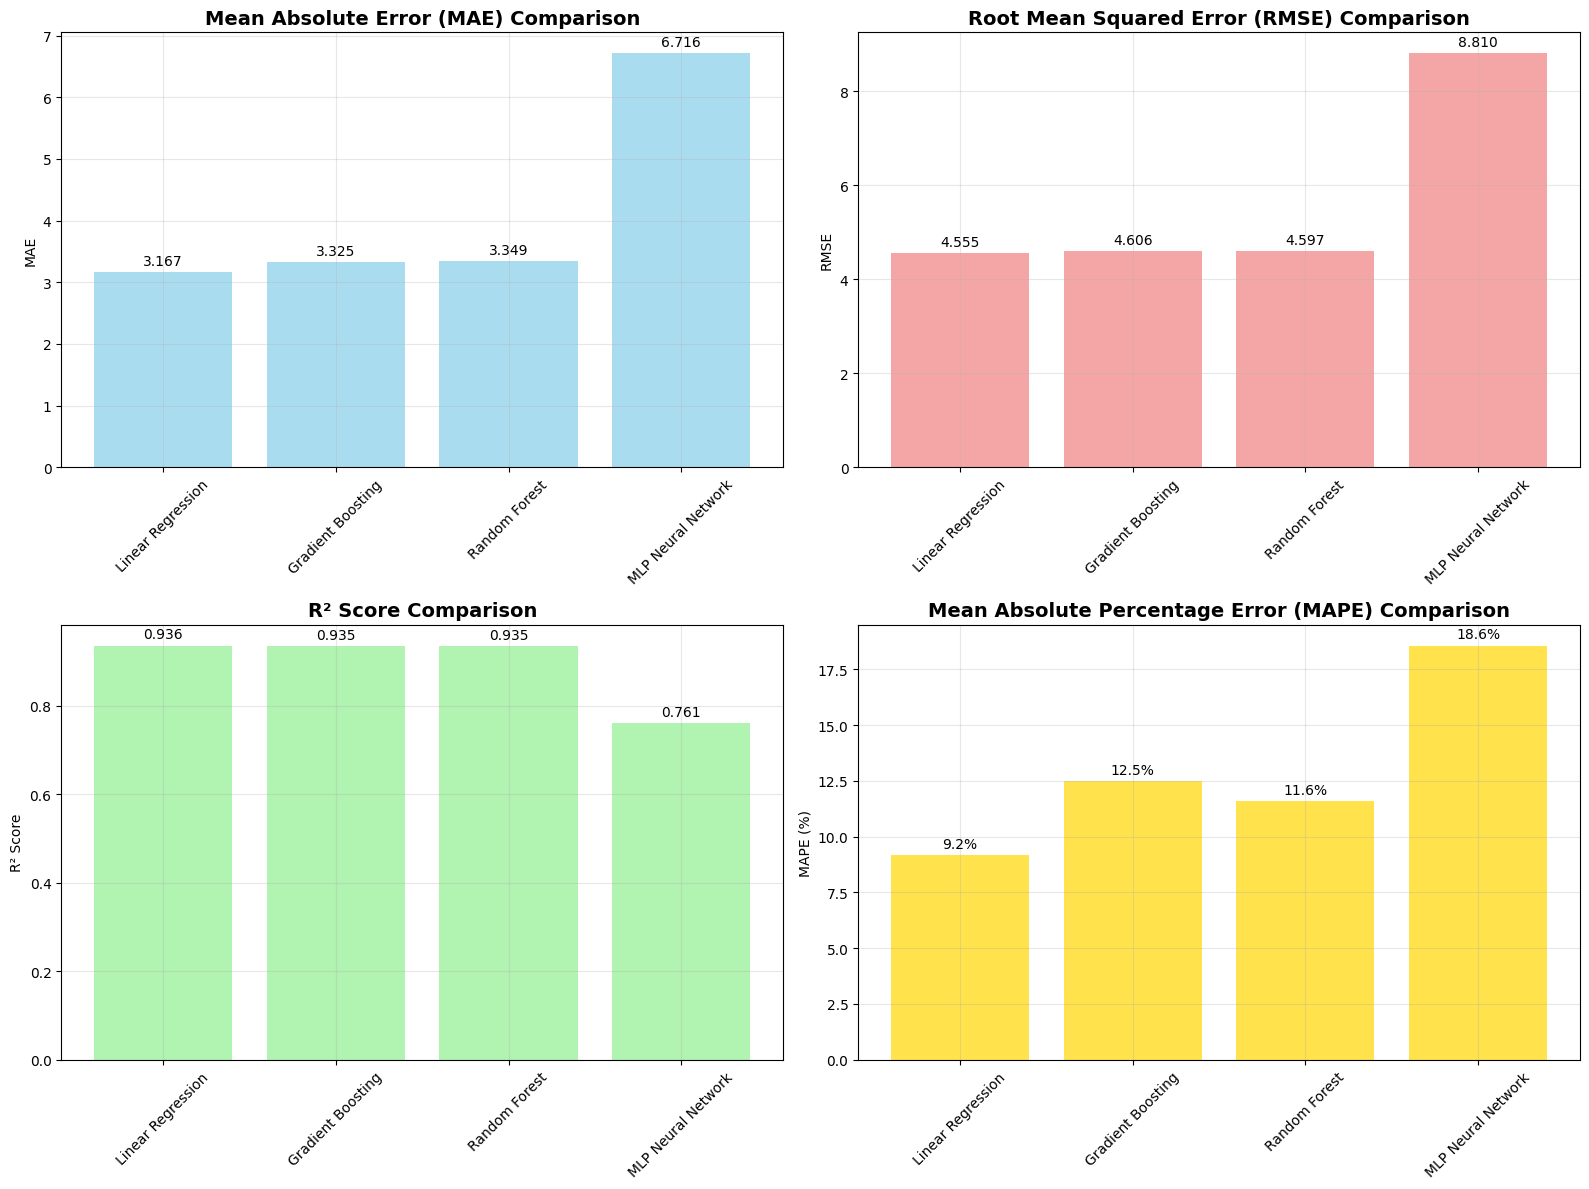

In [67]:


# Create comparison dataframe
comparison_data = []
for model_name, results in models_results.items():
    test_metrics = results['metrics']['test']
    comparison_data.append({
        'Model': model_name,
        'MAE': test_metrics['MAE'],
        'RMSE': test_metrics['RMSE'],
        'MAPE': test_metrics['MAPE'],
        'R²': test_metrics['R²'],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('MAE')  # Sort by MAE (lower is better)


# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. MAE Comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue', alpha=0.7)
axes[0,0].set_title('Mean Absolute Error (MAE) Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('MAE')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(comparison_df['MAE']):
    axes[0,0].text(i, v + max(comparison_df['MAE'])*0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 2. RMSE Comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral', alpha=0.7)
axes[0,1].set_title('Root Mean Squared Error (RMSE) Comparison', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('RMSE')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(comparison_df['RMSE']):
    axes[0,1].text(i, v + max(comparison_df['RMSE'])*0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 3. R² Comparison
axes[1,0].bar(comparison_df['Model'], comparison_df['R²'], color='lightgreen', alpha=0.7)
axes[1,0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('R² Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(comparison_df['R²']):
    axes[1,0].text(i, v + max(comparison_df['R²'])*0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 4. MAPE Comparison
axes[1,1].bar(comparison_df['Model'], comparison_df['MAPE'], color='gold', alpha=0.7)
axes[1,1].set_title('Mean Absolute Percentage Error (MAPE) Comparison', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('MAPE (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(comparison_df['MAPE']):
    axes[1,1].text(i, v + max(comparison_df['MAPE'])*0.01, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = models_results[best_model_name]


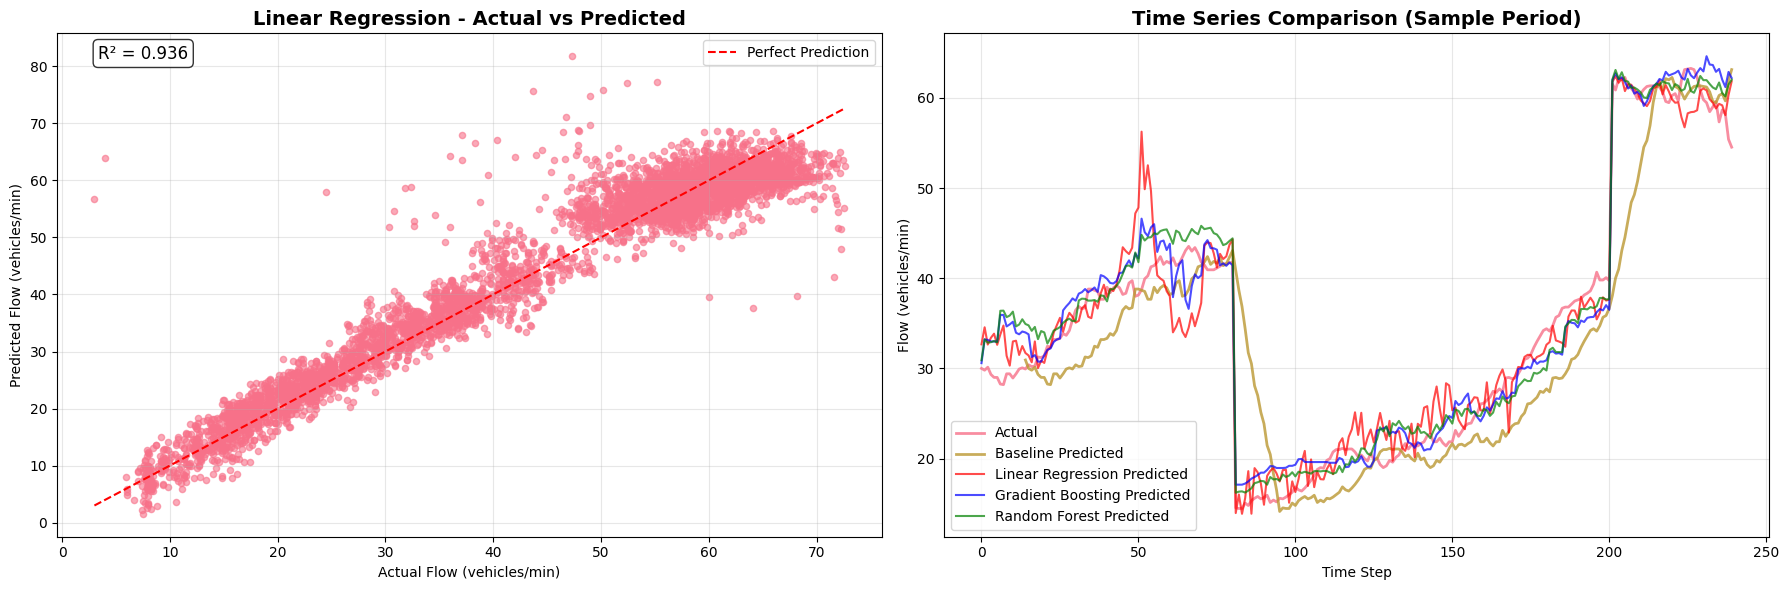

In [71]:
# Visualize predictions for the best models
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Select top 3 models for detailed analysis
top_models = comparison_df.head(3)['Model'].tolist()

# Actual vs Predicted scatter plot for best model
best_model_pred = models_results[best_model_name]['predictions']['test']
axes[0].scatter(y_test, best_model_pred, alpha=0.6, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
axes[0].set_title(f'{best_model_name} - Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Flow (vehicles/min)')
axes[0].set_ylabel('Predicted Flow (vehicles/min)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add R² score
r2_score_best = best_model_results['metrics']['test']['R²']
axes[0].text(0.05, 0.95, f'R² = {r2_score_best:.3f}', transform=axes[0].transAxes,
               fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Time series plot comparing models (sample period)
if len(y_test) > 100:
    sample_indices = range(0,240) 
    #sample_indices = range(200,  len(y_test))  
    
    axes[1].plot(sample_indices, y_test.iloc[sample_indices], label='Actual', linewidth=2, alpha=0.8)
    axes[1].plot(sample_indices, y_pred_baseline.iloc[sample_indices], label='Baseline Predicted', linewidth=2, alpha=0.8)

    colors = ['red', 'blue', 'green']
    for i, model_name in enumerate(top_models[:3]):
        if i < len(colors):
            model_pred = models_results[model_name]['predictions']['test']
            axes[1].plot(sample_indices, model_pred[sample_indices], 
                              label=f'{model_name} Predicted', color=colors[i], alpha=0.7)

    axes[1].set_title('Time Series Comparison (Sample Period)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Flow (vehicles/min)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Feature importance analysis for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_model = models_results[best_model_name]['model']
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



        
    
        
    



In [74]:
# Import TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import os

tf.random.set_seed(42)
np.random.seed(42)

# Prepare data for deep learning
print("\n=== DATA PREPARATION FOR DEEP LEARNING ===")

# Check available datasets
print(f"Training data shape: X_train_final: {X_train_final.shape}, y_train_final: {y_train_final.shape}")
print(f"Validation data shape: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Prepare scaled versions for neural network
# Use the same scaler from earlier in the notebook
X_train_dl = scaler.fit_transform(X_train_final)
X_val_dl = scaler.transform(X_val)
X_test_dl = scaler.transform(X_test)

# Convert to float32 for better GPU performance
X_train_dl = X_train_dl.astype(np.float32)
X_val_dl = X_val_dl.astype(np.float32)
X_test_dl = X_test_dl.astype(np.float32)

y_train_dl = y_train_final.values.astype(np.float32)
y_val_dl = y_val.values.astype(np.float32)
y_test_dl = y_test.values.astype(np.float32)

print(f"Scaled training data shape: {X_train_dl.shape}")
print(f"Input features: {X_train_dl.shape[1]}")
print(f"Training samples: {X_train_dl.shape[0]}")
print(f"Validation samples: {X_val_dl.shape[0]}")
print(f"Test samples: {X_test_dl.shape[0]}")

# Target statistics
print(f"\nTarget statistics:")
print(f"  Training - Mean: {y_train_dl.mean():.2f}, Std: {y_train_dl.std():.2f}")
print(f"  Validation - Mean: {y_val_dl.mean():.2f}, Std: {y_val_dl.std():.2f}")
print(f"  Test - Mean: {y_test_dl.mean():.2f}, Std: {y_test_dl.std():.2f}")



=== DATA PREPARATION FOR DEEP LEARNING ===
Training data shape: X_train_final: (15601, 91), y_train_final: (15601,)
Validation data shape: X_val: (3901, 91), y_val: (3901,)
Test data shape: X_test: (4876, 91), y_test: (4876,)
Scaled training data shape: (15601, 91)
Input features: 91
Training samples: 15601
Validation samples: 3901
Test samples: 4876

Target statistics:
  Training - Mean: 53.64, Std: 10.72
  Validation - Mean: 53.57, Std: 10.93
  Test - Mean: 44.11, Std: 18.01


In [77]:
# Build deep neural network architecture
def create_deep_traffic_model(input_dim, learning_rate=0.001):
    """
    Create a sophisticated deep neural network for traffic flow prediction.
    
    Architecture:
    - Input layer with normalization
    - Multiple hidden layers with batch normalization and dropout
    - Residual connections for better gradient flow
    - L2 regularization to prevent overfitting
    """
    
    model = Sequential([
        # Input layer with batch normalization
        Dense(256, input_dim=input_dim, activation='relu', 
              kernel_regularizer=l2(0.001), name='first'),
        BatchNormalization(name='input_bn'),
        Dropout(0.3, name='input_dropout'),
        
        # First hidden block
        Dense(512, activation='relu', kernel_regularizer=l2(0.001), name='hidden1'),
        BatchNormalization(name='hidden1_bn'),
        Dropout(0.4, name='hidden1_dropout'),
        
        # Second hidden block
        Dense(256, activation='relu', kernel_regularizer=l2(0.001), name='hidden2'),
        BatchNormalization(name='hidden2_bn'),
        Dropout(0.3, name='hidden2_dropout'),
        
        # Third hidden block
        Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='hidden3'),
        BatchNormalization(name='hidden3_bn'),
        Dropout(0.2, name='hidden3_dropout'),
        
        # Fourth hidden block
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='hidden4'),
        BatchNormalization(name='hidden4_bn'),
        Dropout(0.1, name='hidden4_dropout'),
        
        # Output layer for regression
        Dense(1, activation='linear', name='output_layer')
    ])
    
    # Compile model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mape']
    )
    
    return model

# Create the model
input_features = X_train_dl.shape[1]
dl_model = create_deep_traffic_model(input_features, learning_rate=0.001)


In [79]:
# Define callbacks for optimal training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_traffic_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='min'
    )
]

# Training configuration
batch_size = 32
epochs = 100
validation_split = 0.0  # We already have separate validation set

print(f"Training configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Using separate validation set (no validation split)")
print(f"  Callbacks: Early Stopping, Learning Rate Reduction, Model Checkpoint")

# Calculate training steps
train_steps = len(X_train_dl) // batch_size
val_steps = len(X_val_dl) // batch_size

print(f"  Training steps per epoch: {train_steps}")
print(f"  Validation steps per epoch: {val_steps}")
print(f"  Total training samples: {len(X_train_dl)}")
print(f"  Total validation samples: {len(X_val_dl)}")
print(f"  Total test samples: {len(X_test_dl)}")

Training configuration:
  Batch size: 32
  Max epochs: 100
  Using separate validation set (no validation split)
  Callbacks: Early Stopping, Learning Rate Reduction, Model Checkpoint
  Training steps per epoch: 487
  Validation steps per epoch: 121
  Total training samples: 15601
  Total validation samples: 3901
  Total test samples: 4876


In [80]:
# Train the deep learning model
print("\n=== TRAINING DEEP NEURAL NETWORK ===")
print("Starting training... This may take several minutes.")

# Record training start time
training_start_time = time.time()

# Train the model
history = dl_model.fit(
    X_train_dl, y_train_dl,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_dl, y_val_dl),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

# Record training end time
training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"\n=== TRAINING COMPLETED ===")
print(f"Training duration: {training_duration/60:.2f} minutes")
print(f"Total epochs trained: {len(history.history['loss'])}")

# Get the best epoch information
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = min(history.history['val_loss'])
best_val_mae = history.history['val_mae'][best_epoch - 1]

print(f"Best epoch: {best_epoch}")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Best validation MAE: {best_val_mae:.6f}")

# Load the best model
dl_model = tf.keras.models.load_model('best_traffic_model.h5', compile=False)

# Recompile le modèle avec les métriques et fonctions de perte appropriées
dl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

print("Best model loaded and recompiled successfully!")


=== TRAINING DEEP NEURAL NETWORK ===
Starting training... This may take several minutes.
Epoch 1/100


2025-10-16 18:43:30.433682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2596.7622 - mae: 50.3167 - mape: 97.2989
Epoch 1: val_loss improved from None to 721.30078, saving model to best_traffic_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - loss: 2011.6541 - mae: 43.6123 - mape: 85.1153 - val_loss: 721.3008 - val_mae: 24.1398 - val_mape: 53.8758 - learning_rate: 0.0010
Epoch 2/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 327.3345 - mae: 15.9203 - mape: 30.6017
Epoch 2: val_loss improved from 721.30078 to 20.38347, saving model to best_traffic_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 165.9716 - mae: 10.1605 - mape: 19.8805 - val_loss: 20.3835 - val_mae: 3.3759 - val_mape: 6.7532 - learning_rate: 0.0010
Epoch 3/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 38.1812 - mae: 4.6483 - mape: 9.7469
Epoch 3: val_loss did not improve from 20.38347
488/488 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 37.7986 - mae: 4.6048 - mape: 9.6974 - val_loss: 36.6469 - val_mae: 4.7447 - val_mape: 10.1269 - learning_rate: 0.0010
Epoch 4/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 36.0743 - mae: 4.5206 - mape: 9.5244
Epoch 4: val_loss did not improve from 20.38347
488/488 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 36.6833 - mae: 4.5276 - mape: 9.5878 - val_loss: 20.7935 - val_mae: 3.3376 - val_mape: 6.6345 - learning_rate: 0.0010
Epoch 5/100
487/488 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 34.4813 - mae: 4.3829 - mape: 9.1635
Epoch 5: val_loss did not improve from 20.38347
488/488 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - los

In [81]:
dl_model = tf.keras.models.load_model('best_traffic_model.h5', compile=False)

# Recompile le modèle avec les métriques et fonctions de perte appropriées
dl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

print("Best model loaded and recompiled successfully!")


Best model loaded and recompiled successfully!


In [83]:
# Evaluate deep learning model performance
print("\n=== DEEP LEARNING MODEL EVALUATION ===")

# Make predictions on all datasets
print("Making predictions on all datasets...")

y_pred_dl_train = dl_model.predict(X_train_dl, batch_size=batch_size, verbose=0).flatten()
y_pred_dl_val = dl_model.predict(X_val_dl, batch_size=batch_size, verbose=0).flatten()
y_pred_dl_test = dl_model.predict(X_test_dl, batch_size=batch_size, verbose=0).flatten()

# Calculate comprehensive metrics
def calculate_comprehensive_metrics(y_true, y_pred, dataset_name):
    """Calculate comprehensive evaluation metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Explained Variance Score
    from sklearn.metrics import explained_variance_score
    evs = explained_variance_score(y_true, y_pred)
    
    # Max error
    max_error = np.max(np.abs(y_true - y_pred))
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {
        'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2,
        'MAPE': mape
    }

# Calculate metrics for all datasets
train_metrics = calculate_comprehensive_metrics(y_train_dl, y_pred_dl_train, "Training")
val_metrics = calculate_comprehensive_metrics(y_val_dl, y_pred_dl_val, "Validation")
test_metrics = calculate_comprehensive_metrics(y_test_dl, y_pred_dl_test, "Test")

# Store DL model results
dl_metrics = {
    'train': train_metrics,
    'validation': val_metrics,
    'test': test_metrics
}







=== DEEP LEARNING MODEL EVALUATION ===
Making predictions on all datasets...

Training Metrics:
  MAE: 3.3374
  MSE: 19.5348
  RMSE: 4.4198
  R²: 0.8301
  MAPE: 6.76%

Validation Metrics:
  MAE: 3.3759
  MSE: 19.0055
  RMSE: 4.3595
  R²: 0.8408
  MAPE: 6.75%

Test Metrics:
  MAE: 3.4616
  MSE: 22.3753
  RMSE: 4.7302
  R²: 0.9310
  MAPE: 11.06%



=== DEEP LEARNING MODEL VISUALIZATIONS ===


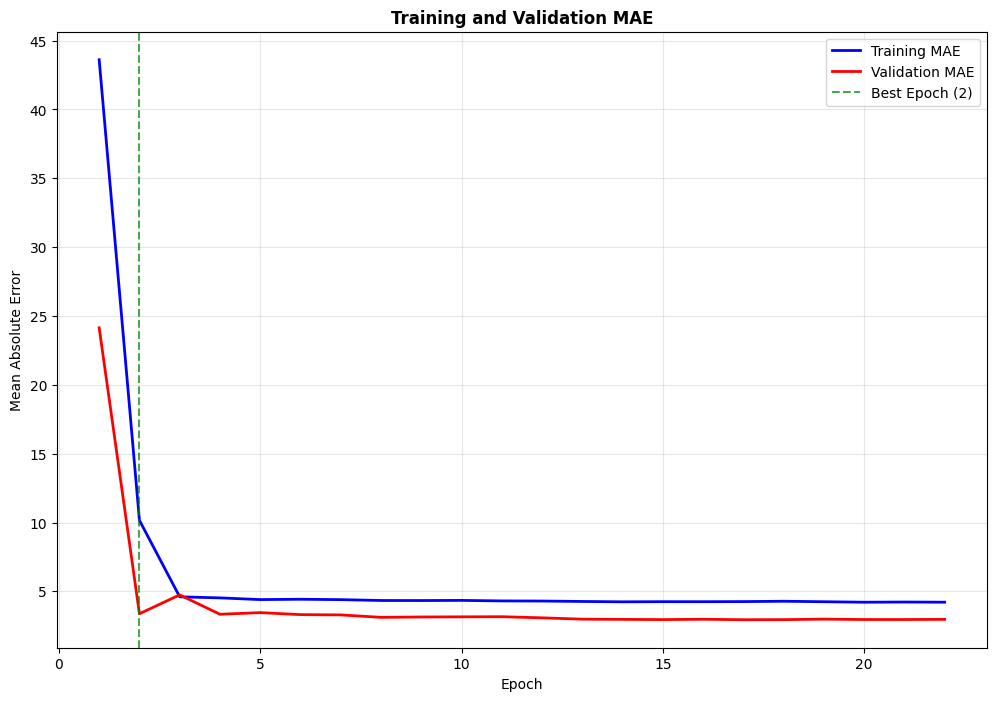

In [86]:
# Visualize training history and model performance
print("\n=== DEEP LEARNING MODEL VISUALIZATIONS ===")

# Training History - MAE
epochs_range = range(1, len(history.history['loss']) + 1)
plt.plot(epochs_range, history.history['mae'], 'b-', label='Training MAE', linewidth=2)
plt.plot(epochs_range, history.history['val_mae'], 'r-', label='Validation MAE', linewidth=2)
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
plt.title('Training and Validation MAE', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)


## Congestion classification

In [87]:
# Congestion Prediction Models
# Using existing model predictions to determine congestion likelihood for next 15 minutes

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("=== CONGESTION PREDICTION MODELS ===")
print("Predicting congestion likelihood for next 15 minutes based on predicted flow")

# Step 1: Define congestion threshold and create labels
X = df_model[selected_features].copy()
X['PRED_FLOW_RF'] = rf_model.predict(df_model[selected_features])
X['PRED_FLOW_GB'] = gb_model.predict(df_model[selected_features])


def future_congestion(row):
    t0 = row['DateTime']
    mask = df_model['DateTime'].between(
        t0 + pd.Timedelta(minutes=1),
        t0 + pd.Timedelta(minutes=15),
        inclusive='both'  # for pandas >= 1.3; use 'neither' or 'left'/'right' if needed
    )
    if df_model.loc[mask, 'IS_CONGESTED'].sum() + df_model.loc[mask, 'IS_NEAR_CAPACITY'].sum() > 0:
        return 1
    else:
        return 0
    
y = df_model.apply(future_congestion, axis=1)

if 'DateTime' in df_model.columns:
    df_model_sorted = df_model.sort_values('DateTime')
    #X_sorted = df_model[selected_features].copy()
    y_sorted = df_model_sorted.apply(future_congestion, axis=1)
    X_sorted = pd.DataFrame(index=df_model_sorted.index)
    X_sorted['PRED_FLOW_RF'] = rf_model.predict(df_model_sorted[selected_features])
    X_sorted['PRED_FLOW_GB'] = gb_model.predict(df_model_sorted[selected_features])

    # Use temporal split: 80% for training, 20% for testing
    split_idx = int(0.8 * len(X_sorted))
    X_cong_train, X_cong_test = X_sorted[:split_idx], X_sorted[split_idx:]
    y_cong_train, y_cong_test = y_sorted[:split_idx], y_sorted[split_idx:]

    print(f"Temporal split - Train: {len(X_cong_train)}, Test: {len(X_cong_test)}")

    if 'DateTime' in df_model_sorted.columns:
        train_period = df_model_sorted.iloc[:split_idx]['DateTime']
        test_period = df_model_sorted.iloc[split_idx:]['DateTime']
        print(f"Training period: {train_period.min()} to {train_period.max()}")
        print(f"Testing period: {test_period.min()} to {test_period.max()}")
else:
    # Fallback to random split if DateTime not available
    X_cong_train, X_cong_test, y_cong_train, y_cong_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Random split - Train: {len(X_cong_train)}, Test: {len(X_cong_test)}")

# Further split training data for validation
X_cong_train_final, X_cong_val, y_cong_train_final, y_cong_val = train_test_split(X_cong_train, y_cong_train, test_size=0.2, random_state=42)

# Step 3: Train multiple congestion prediction models
print(f"\n=== TRAINING CONGESTION MODELS ===")


print(f"Congestion training set: {len(X_cong_train)} samples")
print(f"Congestion test set: {len(X_cong_test)} samples")

# Initialize congestion models
congestion_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=6),
    'SVM': SVC(probability=True, random_state=42, kernel='rbf')
}

# Train and evaluate each model
congestion_results = {}

for model_name, model in congestion_models.items():
    print(f"\nTraining {model_name}...")
    
    # Train the model
    model.fit(X_cong_train, y_cong_train)
    
    # Make predictions
    y_pred_cong = model.predict(X_cong_test)
    y_pred_proba_cong = model.predict_proba(X_cong_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_cong_test, y_pred_cong)
    precision = precision_score(y_cong_test, y_pred_cong)
    recall = recall_score(y_cong_test, y_pred_cong)
    f1 = f1_score(y_cong_test, y_pred_cong)
    
    congestion_results[model_name] = {
        'model': model,
        'predictions': y_pred_cong,
        'probabilities': y_pred_proba_cong,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")

# Step 4: Feature importance analysis
print(f"\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from Random Forest
rf_cong_model = congestion_results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': ['PRED_FLOW_RF', 'PRED_FLOW_GB'],
    'importance': rf_cong_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top features for congestion prediction:")
for _, row in feature_importance.head(8).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Step 5: Ensemble prediction
print(f"\n=== ENSEMBLE CONGESTION PREDICTION ===")

# Create ensemble by averaging probabilities
ensemble_proba = np.mean([
    congestion_results['Random Forest']['probabilities'],
    congestion_results['Gradient Boosting']['probabilities'],
    congestion_results['Logistic Regression']['probabilities']
], axis=0)

ensemble_pred = (ensemble_proba > 0.5).astype(int)

# Ensemble metrics
ensemble_accuracy = accuracy_score(y_cong_test, ensemble_pred)
ensemble_precision = precision_score(y_cong_test, ensemble_pred)
ensemble_recall = recall_score(y_cong_test, ensemble_pred)
ensemble_f1 = f1_score(y_cong_test, ensemble_pred)

print(f"Ensemble Model Performance:")
print(f"  Accuracy: {ensemble_accuracy:.3f}")
print(f"  Precision: {ensemble_precision:.3f}")
print(f"  Recall: {ensemble_recall:.3f}")
print(f"  F1-Score: {ensemble_f1:.3f}")

congestion_results['Ensemble'] = {
    'predictions': ensemble_pred,
    'probabilities': ensemble_proba,
    'accuracy': ensemble_accuracy,
    'precision': ensemble_precision,
    'recall': ensemble_recall,
    'f1_score': ensemble_f1
}

print("\nCongestion prediction models trained successfully!")

=== CONGESTION PREDICTION MODELS ===
Predicting congestion likelihood for next 15 minutes based on predicted flow
Temporal split - Train: 19502, Test: 4876
Training period: 2021-06-01 07:00:00 to 2021-11-20 07:38:00
Testing period: 2021-11-20 07:39:00 to 2021-12-31 08:59:00

=== TRAINING CONGESTION MODELS ===
Congestion training set: 19502 samples
Congestion test set: 4876 samples

Training Logistic Regression...
  Accuracy: 0.945
  Precision: 0.925
  Recall: 0.975
  F1-Score: 0.949

Training Random Forest...
  Accuracy: 0.940
  Precision: 0.920
  Recall: 0.971
  F1-Score: 0.945

Training Gradient Boosting...
  Accuracy: 0.940
  Precision: 0.921
  Recall: 0.971
  F1-Score: 0.945

Training SVM...
  Accuracy: 0.944
  Precision: 0.923
  Recall: 0.977
  F1-Score: 0.949

=== FEATURE IMPORTANCE ANALYSIS ===
Top features for congestion prediction:
  PRED_FLOW_GB: 0.500
  PRED_FLOW_RF: 0.500

=== ENSEMBLE CONGESTION PREDICTION ===
Ensemble Model Performance:
  Accuracy: 0.943
  Precision: 0.92

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

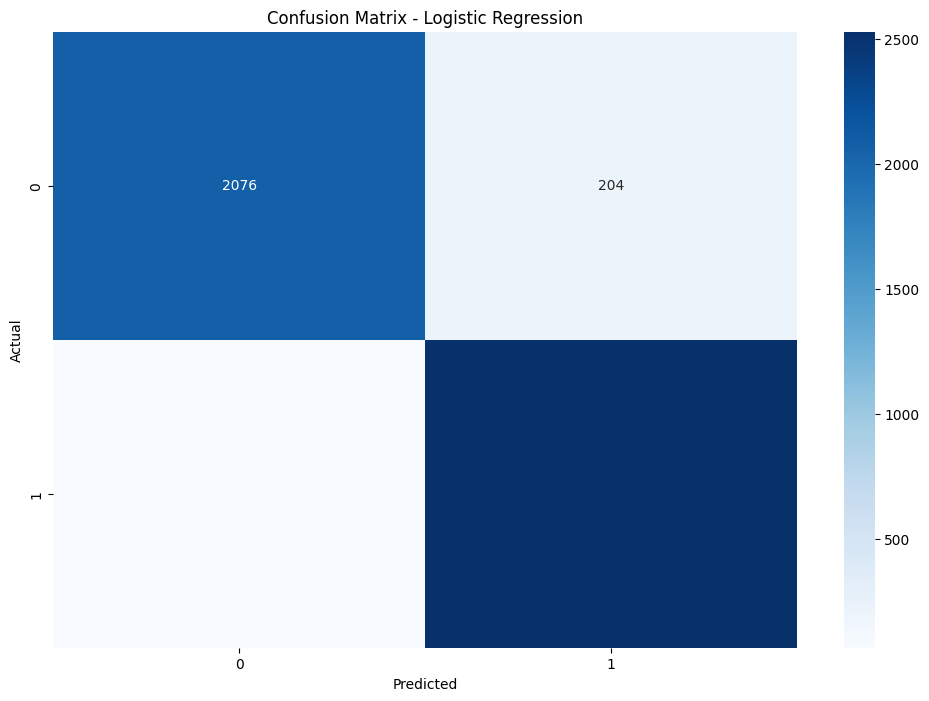

In [89]:
best_model_name = max(congestion_results.keys(), 
                     key=lambda x: congestion_results[x]['f1_score'])
best_predictions = congestion_results[best_model_name]['predictions']

cm = confusion_matrix(y_cong_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')

## F. Final test

In [100]:
df_final_test = pd.read_csv('final_evaluation_dataset.csv', sep=';')
df_final_test.isnull().sum()

DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            4
dtype: int64

In [101]:
df_nonans = df_final_test.dropna(subset=['FLOW'])

In [102]:
# STEP 1: SENSOR-LEVEL PROCESSING
df_sensors = df_nonans.copy()

del df_nonans

# Convert DateTime for time-based features
df_sensors['DateTime'] = pd.to_datetime(df_sensors['Date'].astype(str) + ' ' + df_sensors['Time'])
df_sensors = df_sensors.sort_values(['DP_ID', 'DateTime']).reset_index(drop=True)

# Basic macroscopic features per sensor
df_sensors['SPEED_CAPPED'] = np.maximum(df_sensors['SPEED_MS_AVG'], 1.0)
df_sensors['DENSITY'] = (df_sensors['FLOW'] / 60) / df_sensors['SPEED_CAPPED']

print("Macroscopic feature engineering - sensor level")

Macroscopic feature engineering - sensor level


In [103]:
# STEP 2: AGGREGATION TO PORTAL LEVEL

# Aggregate df_train by portal and time interval: mean for SPEED_MS_AVG, sum for FLOW, keep other features
df_portal_agg = df_sensors.groupby(['PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60']).agg({
    'SPEED_MS_AVG': 'mean',  # Average speed across sensors at this portal
    'FLOW': 'sum',           # Total flow (sum of all sensors at this portal)
    'DP_ID': 'count',        # Count of active sensors at this portal
    'DateTime': 'first',     # Keep DateTime
    'DENSITY': 'mean',      # Average density across sensors at this portal
    'SPEED_CAPPED': 'mean', # Average capped speed
}).reset_index()

# Rename DP_ID count to be more descriptive
df_portal_agg = df_portal_agg.rename(columns={'DP_ID': 'NUM_LANES'})


print(f" Portal-level aggregation")
print(f"  Original sensor records: {len(df_sensors):,}")
print(f"  Aggregated portal records: {len(df_portal_agg):,}")
print(f"  Portals: {df_portal_agg['PORTAL'].nunique()}")

del df_sensors

 Portal-level aggregation
  Original sensor records: 803,497
  Aggregated portal records: 249,839
  Portals: 8


In [104]:
# STEP 3: PORTAL-LEVEL MACROSCOPIC FEATURES

df_features = df_portal_agg.copy()

del df_portal_agg

# Sort by portal and time for spatial-temporal features
portal_order = ['E4S 58,140', 'E4S 57,820', 'E4S 57,435', 'E4S 57,055', 
                'E4S 56,780', 'E4S 56,490', 'E4S 56,160', 'E4S 55,620']
df_features['PORTAL_ORDER'] = df_features['PORTAL'].map({portal: i for i, portal in enumerate(portal_order)})
df_features = df_features.sort_values(['PORTAL_ORDER', 'DateTime']).reset_index(drop=True)

# Critical values and fundamental diagram features (portal level)
df_features['DENSITY_RATIO'] = df_features['DENSITY'] / global_kc
df_features['FLOW_RATIO'] = df_features['FLOW'] / global_qc
df_features['DIST_TO_KC'] = global_kc - df_features['DENSITY']
df_features['DIST_TO_QC'] = global_qc - df_features['FLOW']

# Traffic regime classification (portal level)
def classify_regime_portal(row):
    if row['SPEED_MS_AVG'] > global_ff * 0.9 and row['DENSITY'] < global_kc * 0.5:
        return 'free_flow'
    elif row['FLOW'] > global_qc  * 0.8:
        return 'near_capacity'
    elif row['SPEED_MS_AVG'] < global_ff * 0.7 and row['DENSITY'] > global_kc * 0.6:
        return 'congested'
    else:
        return 'intermediate'

df_features['TRAFFIC_REGIME'] = df_features.apply(classify_regime_portal, axis=1)

# Spatial-temporal features (portal level)

df_interval_1_flow = df_features[['PORTAL', 'Date', 'Interval_1', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_1'])['FLOW'].mean().reset_index()

df_interval_1_speed = df_features[['PORTAL', 'Date', 'Interval_1', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_1'])['SPEED_MS_AVG'].mean().reset_index()

df_interval_5_flow = df_features[['PORTAL', 'Date', 'Interval_5', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_5'])['FLOW'].mean().reset_index()

df_interval_5_speed = df_features[['PORTAL', 'Date', 'Interval_5', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_5'])['SPEED_MS_AVG'].mean().reset_index()

df_interval_15_flow = df_features[['PORTAL', 'Date', 'Interval_15', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_15'])['FLOW'].mean().reset_index()

df_interval_15_speed = df_features[['PORTAL', 'Date', 'Interval_15', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_15'])['SPEED_MS_AVG'].mean().reset_index()

df_interval_60_flow = df_features[['PORTAL', 'Date', 'Interval_60', 'FLOW']].groupby(['PORTAL', 'Date', 'Interval_60'])['FLOW'].mean().reset_index()

df_interval_60_speed = df_features[['PORTAL', 'Date', 'Interval_60', 'SPEED_MS_AVG']].groupby(['PORTAL', 'Date', 'Interval_60'])['SPEED_MS_AVG'].mean().reset_index()

# Merge lagged features back to main dataframe

def add_lagged_features(df_main, df_lag_source, interval_col, value_col, lags, feature_label):
    """
    Merge lagged features into df_main from df_lag_source.

    Parameters:
        df_main (pd.DataFrame): Original dataframe.
        df_lag_source (pd.DataFrame): Aggregated dataframe with one row per interval.
        interval_col (str): Name of the interval column (e.g., 'Interval_1').
        value_col (str): Name of the column to lag (e.g., 'FLOW').
        lags (list of int): List of lags to apply. 0 means current interval.
        feature_label (str): Suffix label to describe the time unit (e.g., '1MIN', '5MIN').

    Returns:
        pd.DataFrame: df_main with lagged features merged.
    """
    df_result = df_main.copy()
    
    for lag in lags:
        df_lag = df_lag_source.copy()
        # Shift interval to align lagged value with current row
        df_lag[interval_col] = df_lag[interval_col] + lag

        suffix = f'_LAG{lag}_{feature_label}'
        df_lag_renamed = df_lag.rename(columns={value_col: value_col + suffix})

        # Merge with main DataFrame
        df_result = df_result.merge(
            df_lag_renamed,
            on=['PORTAL', 'Date', interval_col],
            how='left'
        )
    return df_result

df_features = add_lagged_features(df_features, df_interval_1_flow, 'Interval_1', 'FLOW', lags=[0,1,2,3,4], feature_label='1MIN')
df_features = add_lagged_features(df_features, df_interval_1_speed, 'Interval_1', 'SPEED_MS_AVG', lags=[0,1,2,3,4], feature_label='1MIN')
df_features = add_lagged_features(df_features, df_interval_5_flow, 'Interval_5', 'FLOW', lags=[1,2,3], feature_label='5MIN')
df_features = add_lagged_features(df_features, df_interval_5_speed, 'Interval_5', 'SPEED_MS_AVG', lags=[1,2,3], feature_label='5MIN')
df_features = add_lagged_features(df_features, df_interval_15_flow, 'Interval_15', 'FLOW', lags=[1,2], feature_label='15MIN')
df_features = add_lagged_features(df_features, df_interval_15_speed, 'Interval_15', 'SPEED_MS_AVG', lags=[1,2], feature_label='15MIN')
df_features = add_lagged_features(df_features, df_interval_60_flow, 'Interval_60', 'FLOW', lags=[1,2], feature_label='60MIN')
df_features = add_lagged_features(df_features, df_interval_60_speed, 'Interval_60', 'SPEED_MS_AVG', lags=[1,2], feature_label='60MIN')

for portal in df_features['PORTAL'].unique():
    portal_mask = df_features['PORTAL'] == portal
    portal_data = df_features[portal_mask].copy().sort_values('DateTime')

    # Speed/flow trends (historical only)
    speed_change = portal_data['SPEED_MS_AVG'].diff()  # 1-minute change
    speed_trend_2min = portal_data[['SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN']].mean(axis=1) - portal_data[['SPEED_MS_AVG_LAG3_1MIN', 'SPEED_MS_AVG_LAG4_1MIN']].mean(axis=1)
    flow_trend_2min = portal_data[['FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN']].mean(axis=1) - portal_data[['FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN']].mean(axis=1)

    # Breakdown/recovery detection (historical only)
    breakdown_threshold = global_ff * 0.6
    recovery_threshold = global_ff * 0.8
    breakdown_flag = (portal_data['SPEED_MS_AVG'] < breakdown_threshold).astype(int)
    recovery_flag = (portal_data['SPEED_MS_AVG'] > recovery_threshold).astype(int)
    
    # Trend features (historical)
    df_features.loc[portal_mask, 'SPEED_CHANGE'] = speed_change.fillna(0)
    df_features.loc[portal_mask, 'SPEED_TREND_2MIN'] = speed_trend_2min.fillna(0)
    df_features.loc[portal_mask, 'FLOW_TREND_2MIN'] = flow_trend_2min.fillna(0)

    # State flags
    df_features.loc[portal_mask, 'BREAKDOWN_FLAG'] = breakdown_flag
    df_features.loc[portal_mask, 'RECOVERY_FLAG'] = recovery_flag

# Flow-speed-density interactions
df_features['DENSITY_SQUARED'] = df_features['DENSITY'] ** 2
df_features['FLOW_DENSITY'] = df_features['FLOW'] * df_features['DENSITY']
df_features['SPEED_DENSITY'] = df_features['SPEED_MS_AVG'] * df_features['DENSITY']
df_features['FLOW_SPEED'] = df_features['FLOW'] * df_features['SPEED_MS_AVG']
df_features['INV_SPEED'] = 1 / df_features['SPEED_CAPPED']

df_features['IS_CONGESTED'] = (df_features['TRAFFIC_REGIME'] == 'congested').astype(int)
df_features['IS_FREE_FLOW'] = (df_features['TRAFFIC_REGIME'] == 'free_flow').astype(int)
df_features['IS_NEAR_CAPACITY'] = (df_features['TRAFFIC_REGIME'] == 'near_capacity').astype(int)
df_features['IS_INTERMEDIATE'] = (df_features['TRAFFIC_REGIME'] == 'intermediate').astype(int)

df_features.drop(columns=['TRAFFIC_REGIME'], inplace=True)

print("Macroscopic feature engineering - portal level")

Macroscopic feature engineering - portal level


In [105]:
# STEP 4: SPATIAL-TEMPORAL FEATURES (INTER-PORTAL)

# Initialize spatial features
df_features['UPSTREAM_DEMAND'] = df_features['FLOW']  # Default fallback
df_features['DOWNSTREAM_SUPPLY'] = global_qc  # Default fallback
df_features['REALIZED_FLOW'] = df_features['FLOW']
df_features['DEMAND_SUPPLY_RATIO'] = 1.0

# Spatial gradient features
df_features['FLOW_GRADIENT'] = 0.0
df_features['SPEED_GRADIENT'] = 0.0
df_features['DENSITY_GRADIENT'] = 0.0

# Process spatial features by timestamp
unique_datetimes = df_features['DateTime'].unique()
sample_size = min(1000, len(unique_datetimes))  # Process subset for performance
sample_datetimes = unique_datetimes[:sample_size]

for datetime in sample_datetimes:
    time_mask = df_features['DateTime'] == datetime
    time_slice = df_features[time_mask].copy().sort_values('PORTAL_ORDER')
    
    if len(time_slice) > 1:  # Need at least 2 portals for spatial features
        
        # Spatial gradients (differences between adjacent portals)
        flow_gradient = time_slice['FLOW'].diff()
        speed_gradient = time_slice['SPEED_MS_AVG'].diff()
        density_gradient = time_slice['DENSITY'].diff()
        
        # CTM-based demand and supply
        upstream_flow = time_slice['FLOW'].shift(1)  # Previous portal
        upstream_density = time_slice['DENSITY'].shift(1)
        
        # Demand function (portal-adjusted)
        max_portal_flow = global_qc
        
        demand = np.minimum(upstream_flow.fillna(time_slice['FLOW']), 
                          max_portal_flow * (1 - upstream_density.fillna(0) / (2 * global_kc)))
        
        # Supply function 
        downstream_flow = time_slice['FLOW'].shift(-1)  # Next portal
        supply = np.maximum(0, max_portal_flow - downstream_flow.fillna(0))
        
        # Realized flow (Godunov scheme)
        realized = np.minimum.reduce([demand, supply, time_slice['FLOW']])
        
        # Update dataframe
        indices = time_slice.index
        df_features.loc[indices, 'FLOW_GRADIENT'] = flow_gradient.fillna(0)
        df_features.loc[indices, 'SPEED_GRADIENT'] = speed_gradient.fillna(0)
        df_features.loc[indices, 'DENSITY_GRADIENT'] = density_gradient.fillna(0)
        df_features.loc[indices, 'UPSTREAM_DEMAND'] = demand
        df_features.loc[indices, 'DOWNSTREAM_SUPPLY'] = supply
        df_features.loc[indices, 'REALIZED_FLOW'] = realized  # realized is already numpy array
        df_features.loc[indices, 'DEMAND_SUPPLY_RATIO'] = (demand / (supply + 1e-6))

print(" Spatial-temporal features created")

 Spatial-temporal features created


In [106]:
# STEP 5: CONGESTION PROPAGATION FEATURES

# Initialize congestion features
df_features['QUEUE_LENGTH'] = 0
df_features['QUEUE_PENETRATION'] = 0.0
df_features['CONGESTION_FRONT'] = 0  # 1 if this portal is congestion front

# Process congestion features by timestamp (sampled)
for datetime in sample_datetimes:
    time_mask = df_features['DateTime'] == datetime
    time_slice = df_features[time_mask].copy().sort_values('PORTAL_ORDER')
    
    if len(time_slice) > 1:
        congested_mask = time_slice['IS_CONGESTED'].values
        
        # Queue length: count of upstream congested portals
        queue_lengths = []
        penetrations = []
        congestion_fronts = []
        
        for i, (_, row) in enumerate(time_slice.iterrows()):
            # Count upstream congested portals
            upstream_congested = congested_mask[:i].sum() if i > 0 else 0
            total_upstream = max(1, i)
            penetration = upstream_congested / total_upstream
            
            # Congestion front: congested portal with free-flow upstream
            is_front = 0
            if row['IS_CONGESTED'] == 1:
                if i == 0:  # First portal
                    is_front = 1
                elif congested_mask[i-1] == 0:  # Previous portal not congested
                    is_front = 1
            
            queue_lengths.append(upstream_congested)
            penetrations.append(penetration)
            congestion_fronts.append(is_front)
        
        # Update dataframe
        indices = time_slice.index
        df_features.loc[indices, 'QUEUE_LENGTH'] = queue_lengths
        df_features.loc[indices, 'QUEUE_PENETRATION'] = penetrations
        df_features.loc[indices, 'CONGESTION_FRONT'] = congestion_fronts

# Add temporal congestion features per portal
for portal in df_features['PORTAL'].unique():
    portal_mask = df_features['PORTAL'] == portal
    portal_data = df_features[portal_mask].copy().sort_values('DateTime')
    
    # Queue growth rate
    queue_growth = portal_data['QUEUE_LENGTH'].diff().rolling(window=3, center=True).mean()
    df_features.loc[portal_mask, 'QUEUE_GROWTH_RATE'] = queue_growth.fillna(0)
    
    # Time since congestion started/ended
    congestion_starts = portal_data[portal_data['IS_CONGESTED'].diff() == 1].index
    congestion_ends = portal_data[portal_data['IS_CONGESTED'].diff() == -1].index
    
    time_since_congestion_start = np.full(len(portal_data), 999)
    time_since_congestion_end = np.full(len(portal_data), 999)
    
    for i, idx in enumerate(portal_data.index):
        # Time since congestion started
        prev_starts = congestion_starts[congestion_starts <= idx]
        if len(prev_starts) > 0:
            time_since_congestion_start[i] = i - portal_data.index.get_loc(prev_starts[-1])
        
        # Time since congestion ended
        prev_ends = congestion_ends[congestion_ends <= idx]
        if len(prev_ends) > 0:
            time_since_congestion_end[i] = i - portal_data.index.get_loc(prev_ends[-1])
    
    df_features.loc[portal_mask, 'TIME_SINCE_CONGESTION_START'] = time_since_congestion_start
    df_features.loc[portal_mask, 'TIME_SINCE_CONGESTION_END'] = time_since_congestion_end

print("✓ Congestion propagation features created")

✓ Congestion propagation features created


In [108]:
# STEP 6: FEATURE ENGINEERING SUMMARY AND VALIDATION

# Data cleanup and missing value handling
df_features = df_features.fillna({
    'TIME_SINCE_CONGESTION_START': 999,
    'TIME_SINCE_CONGESTION_END': 999,
    'QUEUE_GROWTH_RATE': 0,
    'FLOW_GRADIENT': 0,
    'SPEED_GRADIENT': 0,
    'DENSITY_GRADIENT': 0
})

# Add comprehensive temporal context features
df_features['HOUR'] = df_features['DateTime'].dt.hour
df_features['MINUTE_OF_HOUR'] = df_features['DateTime'].dt.minute

# Extended temporal features
df_features['MINUTE_OF_DAY'] = df_features['DateTime'].dt.hour * 60 + df_features['DateTime'].dt.minute
df_features['DAY_OF_WEEK'] = df_features['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df_features['IS_WEEKEND'] = (df_features['DateTime'].dt.dayofweek >= 5).astype(int)  # Saturday/Sunday
df_features['IS_WEEKDAY'] = (df_features['DateTime'].dt.dayofweek < 5).astype(int)   # Monday-Friday
df_features['MONTH'] = df_features['DateTime'].dt.month

# Cyclic encodings for temporal features
# Hour cyclic encoding (0-23 hours)
df_features['HOUR_SIN'] = np.sin(2 * np.pi * df_features['HOUR'] / 24)
df_features['HOUR_COS'] = np.cos(2 * np.pi * df_features['HOUR'] / 24)

# Minute cyclic encoding (0-59 minutes)
df_features['MINUTE_SIN'] = np.sin(2 * np.pi * df_features['MINUTE_OF_HOUR'] / 60)
df_features['MINUTE_COS'] = np.cos(2 * np.pi * df_features['MINUTE_OF_HOUR'] / 60)

# Day of week cyclic encoding (0-6 days)
df_features['DOW_SIN'] = np.sin(2 * np.pi * df_features['DAY_OF_WEEK'] / 7)
df_features['DOW_COS'] = np.cos(2 * np.pi * df_features['DAY_OF_WEEK'] / 7)

# Month cyclic encoding (1-12 months)
df_features['MONTH_SIN'] = np.sin(2 * np.pi * (df_features['MONTH'] - 1) / 12)
df_features['MONTH_COS'] = np.cos(2 * np.pi * (df_features['MONTH'] - 1) / 12)

# Optional: Swedish holiday flags (major holidays during study period)
# Note: This is a simplified holiday detection for major Swedish holidays in 2021
df_features['IS_HOLIDAY'] = 0

# Swedish holidays in 2021 (June-December period)
swedish_holidays_2021 = [
    '2021-06-06',  # National Day
    '2021-06-25',  # Midsummer's Eve
    '2021-06-26',  # Midsummer's Day
    '2021-11-06',  # All Saints' Day
    '2021-12-24',  # Christmas Eve
    '2021-12-25',  # Christmas Day
    '2021-12-26',  # Boxing Day
    '2021-12-31',  # New Year's Eve
]

# Convert to date strings for comparison
df_features['DATE_STR'] = df_features['DateTime'].dt.strftime('%Y-%m-%d')
df_features['IS_HOLIDAY'] = df_features['DATE_STR'].isin(swedish_holidays_2021).astype(int)
df_features.drop(columns=['DATE_STR'], inplace=True)  # Remove temporary column

print("Extended temporal features created:")
print("  - Minute of day, day of week, weekend/weekday flags")
print("  - Cyclic encodings for hour, minute, day of week, and month")
print("  - Swedish holiday flags for major holidays")

# Feature categorization for model organization
feature_groups = {
    'basic_traffic': ['FLOW', 'SPEED_MS_AVG', 'DENSITY', 'NUM_LANES'],
    
    'macroscopic_theory': ['DENSITY_RATIO', 'FLOW_RATIO', 'DIST_TO_KC', 'DIST_TO_QC',
                          'DENSITY_SQUARED', 'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED'],
    
    'temporal_lags': ['SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN', 'SPEED_MS_AVG_LAG3_1MIN', 'SPEED_MS_AVG_LAG4_1MIN',
                     'FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN', 'FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN',
                     'SPEED_MS_AVG_LAG1_5MIN', 'SPEED_MS_AVG_LAG2_5MIN', 'SPEED_MS_AVG_LAG3_5MIN',
                     'FLOW_LAG1_5MIN', 'FLOW_LAG2_5MIN', 'FLOW_LAG3_5MIN',
                     'SPEED_MS_AVG_LAG1_60MIN', 'SPEED_MS_AVG_LAG2_60MIN',
                     'FLOW_LAG1_60MIN', 'FLOW_LAG2_60MIN'],
    
    'traffic_dynamics': ['SPEED_CHANGE', 'SPEED_TREND_2MIN', 'FLOW_TREND_2MIN',
                        'BREAKDOWN_FLAG', 'RECOVERY_FLAG'],
    
    'traffic_states': ['IS_CONGESTED', 'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE'],
    
    'spatial_features': ['UPSTREAM_DEMAND', 'DOWNSTREAM_SUPPLY', 'REALIZED_FLOW', 'DEMAND_SUPPLY_RATIO',
                        'FLOW_GRADIENT', 'SPEED_GRADIENT', 'DENSITY_GRADIENT'],
    
    'congestion_propagation': ['QUEUE_LENGTH', 'QUEUE_PENETRATION', 'CONGESTION_FRONT',
                              'QUEUE_GROWTH_RATE', 'TIME_SINCE_CONGESTION_START', 'TIME_SINCE_CONGESTION_END'],
    
    'temporal_context': ['HOUR', 'MINUTE_OF_HOUR', 'MINUTE_OF_DAY', 
                        'DAY_OF_WEEK', 'IS_WEEKEND', 'IS_WEEKDAY', 'MONTH', 'IS_HOLIDAY',
                        'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 
                        'DOW_SIN', 'DOW_COS', 'MONTH_SIN', 'MONTH_COS']
}

# Calculate total features and validate completeness
all_features = []
for group_name, features in feature_groups.items():
    all_features.extend(features)

available_features = [f for f in all_features if f in df_features.columns]
missing_features = [f for f in all_features if f not in df_features.columns]

print("Feature Engineering Summary")
print("=" * 50)
print(f"Dataset shape: {df_features.shape}")
print(f"Total engineered features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")

print(f"\nFeature breakdown by category:")
for group_name, features in feature_groups.items():
    available_in_group = [f for f in features if f in df_features.columns]
    print(f"  {group_name.replace('_', ' ').title()}: {len(available_in_group)} features")

# Focus on target portal 'E4S 57,055' with other portals as features

print("Creating target portal focused dataset")

target_portal = 'E4S 57,055'
print(f"Target portal: {target_portal}")

other_portals = [0,1,2,4,5,6,7]

# Create morning peak subset for focused analysis
df_morning_peak = df_features[(df_features['DateTime'].dt.hour >= 7) & 
                             (df_features['DateTime'].dt.hour <= 9)].copy()

print(f"\nMorning peak subset (07:00-09:00):")
print(f"  Records: {len(df_morning_peak):,}")
print(f"  Portals covered: {df_morning_peak['PORTAL'].nunique()}")

# Check available columns in df_morning_peak
print(f"Available columns in df_morning_peak: {list(df_morning_peak.columns)}")

# Create the focused dataset
def create_target_portal_dataset(df, target_portal, features_to_include=None):
    """
    Creates a dataset focused on a target portal with data from other portals as features
    
    Parameters:
    df: DataFrame with all data
    target_portal: name of the target portal
    features_to_include: list of features to include from other portals (if None, use main features)
    """

    features_to_include = [
            'FLOW', 'SPEED_MS_AVG', 'DENSITY', 'NUM_LANES', 'DENSITY RATIO', 'FLOW_RATIO', 'BREAKDOWN_FLAG',
            'SPEED_MS_AVG_LAG1_1MIN', 'SPEED_MS_AVG_LAG2_1MIN', 'SPEED_MS_AVG_LAG3_1MIN', 'SPEED_MS_AVG_LAG4_1MIN', 'FLOW_LAG1_1MIN', 'FLOW_LAG2_1MIN', 'FLOW_LAG3_1MIN', 'FLOW_LAG4_1MIN', 
            'SPEED_MS_AVG_LAG1_5MIN', 'SPEED_MS_AVG_LAG2_5MIN', 'SPEED_MS_AVG_LAG3_5MIN', 'FLOW_LAG1_5MIN', 'FLOW_LAG2_5MIN', 'FLOW_LAG3_5MIN', 
            'SPEED_MS_AVG_LAG1_15MIN', 'SPEED_MS_AVG_LAG2_15MIN', 'FLOW_LAG1_15MIN', 'FLOW_LAG2_15MIN',
            'SPEED_MS_AVG_LAG1_60MIN', 'SPEED_MS_AVG_LAG2_60MIN', 'FLOW_LAG1_60MIN', 'FLOW_LAG2_60MIN', 
            'SPEED_CHANGE', 'SPEED_TREND_2MIN', 'FLOW_TREND_2MIN', 'DENSITY_SQUARED', 'FLOW_DENSITY', 'SPEED_DENSITY', 'FLOW_SPEED', 'INV_SPEED', 'IS_CONGESTED', 'IS_FREE_FLOW', 'IS_NEAR_CAPACITY', 'IS_INTERMEDIATE'
        ]
    
    
    print(f"Selected features: {features_to_include}")
    
    # Target portal data (these columns keep their original names)
    df_target_portal = df[df['PORTAL'] == target_portal].copy()
    
    
    # For each other portal, add its features with a suffix
    for portal in other_portals:
        portal_data = df[df['PORTAL_ORDER'] == portal].copy()
        portal_name = portal_data['PORTAL'].iloc[0] if not portal_data.empty else f'Portal_{portal}'
        # Create unique suffix for this portal
        suffix = f"_P{portal}"
        
        # Select features to include (only those that exist)
        available_features_for_portal = [col for col in features_to_include if col in portal_data.columns]
        portal_features = portal_data[['Date', 'Time'] + available_features_for_portal].copy()
        
        # Rename columns with suffix (except Date and Time for merge)
        feature_cols = {col: col + suffix for col in available_features_for_portal}
        portal_features = portal_features.rename(columns=feature_cols)
        
        # Merge with target portal data on Date and Time
        df_target_portal = df_target_portal.merge(
            portal_features,
            on=['Date', 'Time'],
            how='left',
            suffixes=('', '_dup')
        )

        print(f"Added features from portal {portal_name} (order {portal}) with suffix {suffix}")
    return df_target_portal

# Apply to df_features
df_target_portal = create_target_portal_dataset(df_features, target_portal, features_to_include=None)

# Add Target variable: average flow in the next 15 minutes at target portal
# Use shift(-15) to get future values, then apply rolling mean

import pandas as pd

# Ensure DateTime is datetime and sorted (important for time logic)
df_target_portal['DateTime'] = pd.to_datetime(df_target_portal['DateTime'])
df_target_portal = df_target_portal.sort_values('DateTime').reset_index(drop=True)

def future_mean(row):
    t0 = row['DateTime']
    mask = df_target_portal['DateTime'].between(
        t0 + pd.Timedelta(minutes=1),
        t0 + pd.Timedelta(minutes=15),
        inclusive='both'  # for pandas >= 1.3; use 'neither' or 'left'/'right' if needed
    )
    return df_target_portal.loc[mask, 'FLOW'].mean()

df_target_portal['TARGET_FLOW_15MIN'] = df_target_portal.apply(future_mean, axis=1)

#df_target_portal['TARGET_FLOW_15MIN_2'] = df_target_portal['FLOW'].shift(-15).rolling(window=15).mean()

df_morning_peak = df_target_portal[(df_target_portal['DateTime'].dt.hour >= 7) & 
                             (df_target_portal['DateTime'].dt.hour < 9)].copy()

df_target_portal = df_morning_peak.copy()


print(f"\nFocused dataset summary")
print(f"Original dataset shape: {df_morning_peak.shape}")
print(f"Focused dataset shape: {df_target_portal.shape}")
print(f"Number of records for {target_portal}: {len(df_target_portal)}")

# Check created columns
target_cols = [col for col in df_target_portal.columns if not any(f'_P{i}' in col for i in range(8))]
feature_cols = [col for col in df_target_portal.columns if any(f'_P{i}' in col for i in range(8))]

print(f"\nTarget portal columns ({len(target_cols)}): {target_cols[:10]}...")
print(f"Other portals feature columns ({len(feature_cols)}): {feature_cols[:10]}...")





Extended temporal features created:
  - Minute of day, day of week, weekend/weekday flags
  - Cyclic encodings for hour, minute, day of week, and month
  - Swedish holiday flags for major holidays
Feature Engineering Summary
Dataset shape: (249839, 86)
Total engineered features: 69
Missing features: 0

Feature breakdown by category:
  Basic Traffic: 4 features
  Macroscopic Theory: 9 features
  Temporal Lags: 18 features
  Traffic Dynamics: 5 features
  Traffic States: 4 features
  Spatial Features: 7 features
  Congestion Propagation: 6 features
  Temporal Context: 16 features
Creating target portal focused dataset
Target portal: E4S 57,055

Morning peak subset (07:00-09:00):
  Records: 125,079
  Portals covered: 8
Available columns in df_morning_peak: ['PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'SPEED_MS_AVG', 'FLOW', 'NUM_LANES', 'DateTime', 'DENSITY', 'SPEED_CAPPED', 'PORTAL_ORDER', 'DENSITY_RATIO', 'FLOW_RATIO', 'DIST_TO_KC',

In [111]:
actual_features_used

['FLOW_LAG3_1MIN',
 'SPEED_MS_AVG_LAG2_5MIN_P7',
 'FLOW_LAG3_5MIN',
 'SPEED_MS_AVG_LAG3_1MIN_P6',
 'FLOW_LAG3_5MIN_P7',
 'FLOW_P6',
 'MONTH',
 'FLOW_RATIO',
 'FLOW_DENSITY_P4',
 'SPEED_CAPPED',
 'SPEED_MS_AVG_LAG1_5MIN_P7',
 'SPEED_MS_AVG_P7',
 'FLOW_LAG1_1MIN_P6',
 'IS_WEEKDAY',
 'DENSITY_RATIO',
 'SPEED_MS_AVG_LAG1_1MIN',
 'SPEED_MS_AVG_LAG1_1MIN_P6',
 'BREAKDOWN_FLAG_P6',
 'IS_FREE_FLOW_P4',
 'MINUTE_OF_DAY',
 'NUM_LANES_P7',
 'SPEED_MS_AVG_LAG2_5MIN',
 'FLOW_LAG4_1MIN_P6',
 'NUM_LANES',
 'FLOW_LAG4_1MIN_P7',
 'UPSTREAM_DEMAND',
 'NUM_LANES_P4',
 'SPEED_MS_AVG_LAG3_1MIN',
 'FLOW_LAG2_5MIN_P6',
 'FLOW_LAG1_5MIN',
 'SPEED_DENSITY_P4',
 'SPEED_MS_AVG_LAG3_5MIN_P7',
 'HOUR',
 'SPEED_MS_AVG_LAG4_1MIN',
 'IS_HOLIDAY',
 'FLOW_P4',
 'IS_WEEKEND',
 'FLOW_DENSITY_P7',
 'SPEED_MS_AVG_LAG3_5MIN_P6',
 'FLOW_LAG2_1MIN_P7',
 'SPEED_MS_AVG_LAG2_1MIN_P6',
 'FLOW_LAG2_15MIN',
 'SPEED_MS_AVG_LAG3_1MIN_P7',
 'FLOW_LAG3_1MIN_P7',
 'IS_FREE_FLOW_P7',
 'FLOW_LAG2_1MIN_P6',
 'SPEED_DENSITY_P6',
 'FLOW_LAG0

In [112]:
df_target_portal_last = df_target_portal[actual_features_used + ['TARGET_FLOW_15MIN']].dropna().copy()

# Filter for data between 7:30 and 8:30 using HOUR and MINUTE columns
df_target_portal_last = df_target_portal_last[
    ((df_target_portal_last['HOUR'] == 7) & (df_target_portal_last['MINUTE_OF_DAY'] >= 30)) |
    ((df_target_portal_last['HOUR'] == 8) & (df_target_portal_last['MINUTE_OF_DAY'] < 30))
].copy()

X_final_test = df_target_portal_last[actual_features_used]
y_final_test = df_target_portal_last['TARGET_FLOW_15MIN']



In [113]:
y_pred_baseline = baseline_model(X_final_test)
calculate_metrics(y_final_test[15:], y_pred_baseline[15:])

{'MAE': 4.984516717084955,
 'RMSE': 7.577163792558982,
 'MAPE': 12.566420051929232,
 'R²': 0.7937994460541293}

In [114]:
models = {
    'GradientBoosting': gb_model,
    'RandomForest': rf_model,
    'LinearRegression': lr_model
}

models_results = {}
for model_name, model in models.items():
    metrics = calculate_metrics(y_final_test, model.predict(X_final_test))
    models_results[model_name] = metrics
    mape = metrics['MAPE']
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    r2 = metrics['R²']
    models_results[model_name] = {
        'mape': mape,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

print("\nFinal Model Evaluation on Focused Dataset:")
print("=" * 60)
for model_name, results in models_results.items():
    print(f"\nModel: {model_name}")
    print(f"  - MAPE: {results['mape']:.2f}")
    print(f"  - RMSE: {results['rmse']:.2f}")
    print(f"  - MAE: {results['mae']:.2f}")
    print(f"  - R²: {results['r2']:.4f}")

# Prepare scaled versions for neural network
# Use the same scaler from earlier in the notebook
X_final_test_dl = scaler.fit_transform(X_final_test)


# Convert to float32 for better GPU performance
X_final_test_dl = X_final_test_dl.astype(np.float32)

y_final_test_dl = y_final_test.values.astype(np.float32)

calculate_metrics(y_final_test_dl, dl_model.predict(X_final_test_dl))


Final Model Evaluation on Focused Dataset:

Model: GradientBoosting
  - MAPE: 7.95
  - RMSE: 4.32
  - MAE: 3.33
  - R²: 0.9329

Model: RandomForest
  - MAPE: 7.75
  - RMSE: 4.30
  - MAE: 3.34
  - R²: 0.9336

Model: LinearRegression
  - MAPE: 7.83
  - RMSE: 4.67
  - MAE: 3.45
  - R²: 0.9216
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


{'MAE': 5.225541114807129,
 'RMSE': 6.466262412790286,
 'MAPE': 52.15054750442505,
 'R²': 0.8496328592300415}